In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re
import platform
import time
import requests
from urllib3.exceptions import NewConnectionError, MaxRetryError

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2025-03-04 13:23:11.656912
File: ADAM_experiment26
Experiment Number: 26


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=30).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print(f"Clinical Microbiome Data Loaded. Dim: {clinical_microbiome_df.shape}")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448, 2042199113, 441301073, 236793113, 387615796, 1899788307, 788877054, 681076636, 504404028, 1620098870, 847071637, 1967649092, 1010220053, 644534191, 844067037, 59236795, 1814102137, 787036043, 1853222053, 745124550, 2136397237]
Data File Path: ../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded. Dim: (335, 1050)
Alzheimers Counts:
 0.0    225
1.0    110
Name: Alzheimers, dtype: int64
Normalized Alzheimers Counts:
 0.0    0.671642
1.0    0.328358
Name: Alzheimers, dtype: float64
Seed in this experiment: 1814102137


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

0    335
Name: Dementia Other, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 0.0    225
1.0    110
Name: Alzheimers, dtype: int64
Normalized Alzheimers Counts:
 0.0    0.671642
1.0    0.328358
Name: Alzheimers, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,feature_name,definition,feature_group_characteristics,feature_description,feature_description_down_sized
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...,the Sample ID is crucial for maintaining the i...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R...",study identification ### Clinical Feature Defi...
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...,this feature provides temporal information tha...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...,"the ""Date Sample"" refers to the specific date ..."
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...,age is a fundamental demographic characteristi...
...,...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...,"cirrhosis, steatohepatitis, and liver failure ..."
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...,the presence of an ostomy indicates that a pat...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...,Alzheimer's disease (AD) is a progressive neur...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...,"""Dementia Other"" refers to various forms of de..."


In [8]:
clinical_summaries_df['feature_name'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['feature_name']][clinical_summaries_df['feature_name'].str.startswith(('c', 'C'))]

,feature_name
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium prausnitzii',
 'Fusicatenibacter saccharivorans',
 'Eubacterium siraeum',
 'Gemmiger formicilis',
 'Eubacterium rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium rectale',
 'Eubacterium siraeum',
 'Faecalibacterium prausnitzii',
 'Fusicatenibacter saccharivorans',
 'Gemmiger formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

0    335
Name: Dementia Other, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['ADAM_experiment25.ipynb', 'ADAM_experiment13.ipynb', 'ADAM_experiment12.ipynb', 'ADAM_experiment17.ipynb', 'ADAM_experiment02.ipynb', 'ADAM_experiment21.ipynb', 'ADAM_experiment11.ipynb', 'ADAM_experiment29.ipynb']
cuda:1: ['ADAM_experiment04.ipynb', 'local_vector_db.ipynb', 'ADAM_experiment28.ipynb', 'ADAM_experiment01.ipynb', 'ADAM_experiment18.ipynb', 'ADAM_experiment19.ipynb', 'ADAM_experiment24.ipynb', 'ADAM_experiment22.ipynb']
cuda:2: ['ADAM_experiment03.ipynb', 'ADAM_experiment16.ipynb', 'ADAM_experiment14.ipynb', 'ADAM_experiment06.ipynb', 'ADAM_experiment20.ipynb', 'ADAM_experiment27.ipynb', 'ADAM_experiment23.ipynb', 'ADAM_experiment08.ipynb']
cuda:3: ['ADAM_experiment30.ipynb', 'ADAM_experiment10.ipynb', 'ADAM_experiment09.ipynb', 'ADAM_experiment15.ipynb', 'ADAM_experiment07.ipynb', 'ADAM_experiment05.ipynb', 'ADAM_experiment26.ipynb', 'ADAM_summarization.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 19501608

Experiment number: 26 | Seed number: 1814102137
No overlap Study ID found.
No overlap Sample ID found.


[I 2025-03-04 13:23:12,522] A new study created in memory with name: no-name-1f2113a5-f37c-4199-98b6-b501cd2c2646


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:13,443] Trial 0 finished with value: 0.6800204918032787 and parameters: {'threshold': '1.5*mean', 'max_features': 961, 'norm_order': 1, 'learning_rate': 0.140054791884571, 'max_depth': 18, 'min_child_weight': 8, 'subsample': 0.7263532532683655, 'colsample_bytree': 0.6199419812522649, 'gamma': 7.55412013229213, 'reg_alpha': 2.502907251568357, 'reg_lambda': 7.160139156284994, 'n_estimators': 156}. Best is trial 0 with value: 0.6800204918032787.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:14,085] Trial 1 finished with value: 0.6860344827586208 and parameters: {'threshold': 'mean', 'max_features': 193, 'norm_order': 1, 'learning_rate': 0.2152154683858181, 'max_depth': 23, 'min_child_weight': 9, 'subsample': 0.683072605822967, 'colsample_bytree': 0.7294734210374281, 'gamma': 0.054688525914468045, 'reg_alpha': 5.530040543349952, 'reg_lambda': 4.629846395397243, 'n_estimators': 78}. Best is trial 1 with value: 0.6860344827586208.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:15,086] Trial 2 finished with value: 0.8750552852720036 and parameters: {'threshold': 'very_low', 'max_features': 76, 'norm_order': 1, 'learning_rate': 0.1884063815249724, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.926675797121764, 'colsample_bytree': 0.9759974119371209, 'gamma': 2.7221353569455387, 'reg_alpha': 0.594304791761241, 'reg_lambda': 4.085197049423171, 'n_estimators': 282}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:15,880] Trial 3 finished with value: 0.6417340521114105 and parameters: {'threshold': '0.5*mean', 'max_features': 510, 'norm_order': 1, 'learning_rate': 0.09933217424368605, 'max_depth': 11, 'min_child_weight': 9, 'subsample': 0.8598884423784414, 'colsample_bytree': 0.7081372727116526, 'gamma': 7.379300694421634, 'reg_alpha': 6.530769427795422, 'reg_lambda': 6.505733773088158, 'n_estimators': 121}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:16,599] Trial 4 finished with value: 0.7389803684750298 and parameters: {'threshold': '0.5*mean', 'max_features': 640, 'norm_order': 2, 'learning_rate': 0.2577069658550011, 'max_depth': 29, 'min_child_weight': 7, 'subsample': 0.8549009492492663, 'colsample_bytree': 0.7699886115858318, 'gamma': 4.301042760414946, 'reg_alpha': 4.435400672341716, 'reg_lambda': 0.3814050833485372, 'n_estimators': 143}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:17,337] Trial 5 finished with value: 0.6735031126202603 and parameters: {'threshold': '0.5*mean', 'max_features': 903, 'norm_order': 1, 'learning_rate': 0.44178124287294873, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.9726255619143456, 'colsample_bytree': 0.7122016348583415, 'gamma': 9.676397325586569, 'reg_alpha': 5.238417243843755, 'reg_lambda': 1.7698284079714366, 'n_estimators': 187}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:18,204] Trial 6 finished with value: 0.7457259158751697 and parameters: {'threshold': 'very_low', 'max_features': 202, 'norm_order': 2, 'learning_rate': 0.16629422460268392, 'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9705185010990629, 'colsample_bytree': 0.7625927723138571, 'gamma': 5.652690925958675, 'reg_alpha': 3.287113177817923, 'reg_lambda': 3.1183743581423595, 'n_estimators': 175}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:19,255] Trial 7 finished with value: 0.8002634841407795 and parameters: {'threshold': '1.5*mean', 'max_features': 990, 'norm_order': 1, 'learning_rate': 0.08860524207168664, 'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.9790884084768532, 'colsample_bytree': 0.6106006036499596, 'gamma': 2.721483667232093, 'reg_alpha': 4.84645433027061, 'reg_lambda': 4.752881407786172, 'n_estimators': 219}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:20,248] Trial 8 finished with value: 0.6720823978888495 and parameters: {'threshold': 'mean', 'max_features': 57, 'norm_order': 2, 'learning_rate': 0.19466523381212597, 'max_depth': 21, 'min_child_weight': 9, 'subsample': 0.5150131052610845, 'colsample_bytree': 0.6131663356686954, 'gamma': 8.289371574922834, 'reg_alpha': 1.3170085375929608, 'reg_lambda': 8.370879023017666, 'n_estimators': 289}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:21,128] Trial 9 finished with value: 0.7169591963429088 and parameters: {'threshold': '0.5*mean', 'max_features': 785, 'norm_order': 1, 'learning_rate': 0.3904136328514467, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.622154185466729, 'colsample_bytree': 0.9109107813724989, 'gamma': 7.34080114612895, 'reg_alpha': 0.5143137651120433, 'reg_lambda': 2.7532852770894465, 'n_estimators': 56}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:22,024] Trial 10 finished with value: 0.7240606223657071 and parameters: {'threshold': 'median', 'max_features': 401, 'norm_order': 2, 'learning_rate': 0.3241482221114578, 'max_depth': 28, 'min_child_weight': 4, 'subsample': 0.853730976165323, 'colsample_bytree': 0.9997180864512879, 'gamma': 1.3737326767247344, 'reg_alpha': 9.722976530742336, 'reg_lambda': 9.999496951720257, 'n_estimators': 300}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:23,276] Trial 11 finished with value: 0.7656809746361986 and parameters: {'threshold': '1.5*mean', 'max_features': 678, 'norm_order': 1, 'learning_rate': 0.030992678123518837, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9967148705865819, 'colsample_bytree': 0.5423790960323344, 'gamma': 3.062599228885903, 'reg_alpha': 7.80664702930374, 'reg_lambda': 5.005546005668649, 'n_estimators': 243}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:25,212] Trial 12 finished with value: 0.8080786644029428 and parameters: {'threshold': 'very_low', 'max_features': 421, 'norm_order': 1, 'learning_rate': 0.013759212091216944, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.9059466700441821, 'colsample_bytree': 0.8725394841362282, 'gamma': 2.51712619392404, 'reg_alpha': 2.810455198519323, 'reg_lambda': 4.843824458699815, 'n_estimators': 232}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:27,315] Trial 13 finished with value: 0.812427895134662 and parameters: {'threshold': 'very_low', 'max_features': 335, 'norm_order': 1, 'learning_rate': 0.013793980533331042, 'max_depth': 14, 'min_child_weight': 5, 'subsample': 0.8824278332608633, 'colsample_bytree': 0.88394207738715, 'gamma': 2.578467224058299, 'reg_alpha': 2.092458992187999, 'reg_lambda': 6.0909736190780475, 'n_estimators': 254}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:28,779] Trial 14 finished with value: 0.7882076078484787 and parameters: {'threshold': 'very_low', 'max_features': 53, 'norm_order': 1, 'learning_rate': 0.28911696510792273, 'max_depth': 14, 'min_child_weight': 5, 'subsample': 0.7973616803241552, 'colsample_bytree': 0.9998916498728198, 'gamma': 4.163709938469796, 'reg_alpha': 0.7247456561611454, 'reg_lambda': 6.5774808656655255, 'n_estimators': 266}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:30,687] Trial 15 finished with value: 0.8213092254445638 and parameters: {'threshold': 'very_low', 'max_features': 257, 'norm_order': 1, 'learning_rate': 0.08379273256320915, 'max_depth': 25, 'min_child_weight': 6, 'subsample': 0.9060628624933061, 'colsample_bytree': 0.877152009060167, 'gamma': 1.080246608912372, 'reg_alpha': 2.002108628181556, 'reg_lambda': 3.4745618829987426, 'n_estimators': 265}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:32,583] Trial 16 finished with value: 0.8031505403129189 and parameters: {'threshold': 'very_low', 'max_features': 194, 'norm_order': 1, 'learning_rate': 0.09999161237538864, 'max_depth': 25, 'min_child_weight': 6, 'subsample': 0.7839472500955595, 'colsample_bytree': 0.9374298501508942, 'gamma': 0.43730902394997906, 'reg_alpha': 0.0569074503115099, 'reg_lambda': 3.397472201441519, 'n_estimators': 204}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:34,331] Trial 17 finished with value: 0.7988224529577913 and parameters: {'threshold': 'median', 'max_features': 278, 'norm_order': 2, 'learning_rate': 0.22502786119499302, 'max_depth': 25, 'min_child_weight': 6, 'subsample': 0.9208219513555221, 'colsample_bytree': 0.8281053025083944, 'gamma': 1.313577828012778, 'reg_alpha': 3.7165466561468206, 'reg_lambda': 0.7110965682689305, 'n_estimators': 269}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:35,901] Trial 18 finished with value: 0.7547412407585985 and parameters: {'threshold': 'very_low', 'max_features': 20, 'norm_order': 1, 'learning_rate': 0.1416392615090722, 'max_depth': 18, 'min_child_weight': 4, 'subsample': 0.8058432409630154, 'colsample_bytree': 0.9509846771021884, 'gamma': 5.653370054414217, 'reg_alpha': 1.6540535390679998, 'reg_lambda': 1.8073256306431253, 'n_estimators': 282}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:38,166] Trial 19 finished with value: 0.7450190820309666 and parameters: {'threshold': 'very_low', 'max_features': 137, 'norm_order': 1, 'learning_rate': 0.34102206940198015, 'max_depth': 26, 'min_child_weight': 10, 'subsample': 0.937226414597605, 'colsample_bytree': 0.8264132526103292, 'gamma': 1.405109846856002, 'reg_alpha': 1.3615400745747441, 'reg_lambda': 3.7699594790432363, 'n_estimators': 206}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:41,183] Trial 20 finished with value: 0.7612156350938791 and parameters: {'threshold': 'very_low', 'max_features': 311, 'norm_order': 2, 'learning_rate': 0.07741670203986796, 'max_depth': 22, 'min_child_weight': 7, 'subsample': 0.7217731464913998, 'colsample_bytree': 0.836004767152174, 'gamma': 3.6546121342544513, 'reg_alpha': 3.9583397480556837, 'reg_lambda': 1.971562618931185, 'n_estimators': 242}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:44,649] Trial 21 finished with value: 0.8040935672514621 and parameters: {'threshold': 'very_low', 'max_features': 364, 'norm_order': 1, 'learning_rate': 0.05182220189464852, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.8802055401899468, 'colsample_bytree': 0.8915997545941511, 'gamma': 2.0317478932693414, 'reg_alpha': 2.0572039081944915, 'reg_lambda': 5.5054009840023825, 'n_estimators': 259}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:46,705] Trial 22 finished with value: 0.8211003699725504 and parameters: {'threshold': 'very_low', 'max_features': 278, 'norm_order': 1, 'learning_rate': 0.1288296956476662, 'max_depth': 17, 'min_child_weight': 4, 'subsample': 0.9257533150861182, 'colsample_bytree': 0.9569958310065597, 'gamma': 1.936243035505209, 'reg_alpha': 2.2803466672669126, 'reg_lambda': 5.994198978729614, 'n_estimators': 253}. Best is trial 2 with value: 0.8750552852720036.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:49,667] Trial 23 finished with value: 0.8861132331720567 and parameters: {'threshold': 'very_low', 'max_features': 508, 'norm_order': 1, 'learning_rate': 0.15507334334050074, 'max_depth': 18, 'min_child_weight': 2, 'subsample': 0.9251918196154865, 'colsample_bytree': 0.9575193173136436, 'gamma': 0.855500938899995, 'reg_alpha': 0.9670547840679377, 'reg_lambda': 3.893942212378724, 'n_estimators': 299}. Best is trial 23 with value: 0.8861132331720567.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:52,469] Trial 24 finished with value: 0.9065671691457854 and parameters: {'threshold': 'mean', 'max_features': 500, 'norm_order': 1, 'learning_rate': 0.1827804487963265, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.8233245605822908, 'colsample_bytree': 0.9612770621878999, 'gamma': 0.8949901713895708, 'reg_alpha': 0.09970125842783617, 'reg_lambda': 3.9738888236527807, 'n_estimators': 297}. Best is trial 24 with value: 0.9065671691457854.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:54,957] Trial 25 finished with value: 0.9007310299763129 and parameters: {'threshold': 'mean', 'max_features': 545, 'norm_order': 1, 'learning_rate': 0.18823439602332498, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.8064543024022557, 'colsample_bytree': 0.9680822117524821, 'gamma': 0.5522481218619664, 'reg_alpha': 0.819910479207991, 'reg_lambda': 4.14059320100096, 'n_estimators': 299}. Best is trial 24 with value: 0.9065671691457854.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:23:57,708] Trial 26 finished with value: 0.8762484854438877 and parameters: {'threshold': 'mean', 'max_features': 548, 'norm_order': 1, 'learning_rate': 0.2485541508687429, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.8202387249798517, 'colsample_bytree': 0.9249682459761126, 'gamma': 0.6884871199584299, 'reg_alpha': 0.9792222017420759, 'reg_lambda': 2.6081185984893223, 'n_estimators': 297}. Best is trial 24 with value: 0.9065671691457854.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:01,398] Trial 27 finished with value: 0.8879444338563837 and parameters: {'threshold': 'mean', 'max_features': 486, 'norm_order': 1, 'learning_rate': 0.16466528778396977, 'max_depth': 23, 'min_child_weight': 2, 'subsample': 0.7512527202266172, 'colsample_bytree': 0.9668973505712113, 'gamma': 0.3475839777686004, 'reg_alpha': 0.30651803155596347, 'reg_lambda': 4.196589266510888, 'n_estimators': 279}. Best is trial 24 with value: 0.9065671691457854.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:04,567] Trial 28 finished with value: 0.8579291365669075 and parameters: {'threshold': 'mean', 'max_features': 674, 'norm_order': 1, 'learning_rate': 0.267617063505003, 'max_depth': 23, 'min_child_weight': 3, 'subsample': 0.6798008980230817, 'colsample_bytree': 0.7891690428770751, 'gamma': 0.09772134489746809, 'reg_alpha': 0.13903351134500525, 'reg_lambda': 7.365203598847623, 'n_estimators': 276}. Best is trial 24 with value: 0.9065671691457854.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:07,570] Trial 29 finished with value: 0.7839101796191771 and parameters: {'threshold': 'mean', 'max_features': 562, 'norm_order': 1, 'learning_rate': 0.486994199369153, 'max_depth': 27, 'min_child_weight': 2, 'subsample': 0.7463175042844482, 'colsample_bytree': 0.65771214486031, 'gamma': 3.4730998800196446, 'reg_alpha': 2.780811986721796, 'reg_lambda': 7.964158019911329, 'n_estimators': 229}. Best is trial 24 with value: 0.9065671691457854.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:09,550] Trial 30 finished with value: 0.8370330588375702 and parameters: {'threshold': 'mean', 'max_features': 801, 'norm_order': 1, 'learning_rate': 0.18635976843141108, 'max_depth': 30, 'min_child_weight': 3, 'subsample': 0.7675772330629433, 'colsample_bytree': 0.5033256936587392, 'gamma': 1.6646387286380437, 'reg_alpha': 0.04132011123469892, 'reg_lambda': 1.130737787512214, 'n_estimators': 94}. Best is trial 24 with value: 0.9065671691457854.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:12,559] Trial 31 finished with value: 0.876705055950339 and parameters: {'threshold': 'mean', 'max_features': 473, 'norm_order': 1, 'learning_rate': 0.1433816273539603, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.6974227021227499, 'colsample_bytree': 0.9670382302246296, 'gamma': 0.6247317634175786, 'reg_alpha': 0.8804096874723966, 'reg_lambda': 4.095871504924602, 'n_estimators': 298}. Best is trial 24 with value: 0.9065671691457854.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:16,282] Trial 32 finished with value: 0.9045803506587821 and parameters: {'threshold': 'mean', 'max_features': 617, 'norm_order': 1, 'learning_rate': 0.21022518207501287, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.8263923086045855, 'colsample_bytree': 0.9168949339437331, 'gamma': 0.1908778189567597, 'reg_alpha': 1.1371259818632176, 'reg_lambda': 4.392835257592793, 'n_estimators': 281}. Best is trial 24 with value: 0.9065671691457854.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:19,176] Trial 33 finished with value: 0.8864808031474699 and parameters: {'threshold': 'mean', 'max_features': 599, 'norm_order': 1, 'learning_rate': 0.21928737439610507, 'max_depth': 23, 'min_child_weight': 1, 'subsample': 0.8286497363519919, 'colsample_bytree': 0.9113075113375386, 'gamma': 0.09253097343047312, 'reg_alpha': 1.409635224465192, 'reg_lambda': 5.428456260363961, 'n_estimators': 281}. Best is trial 24 with value: 0.9065671691457854.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:22,277] Trial 34 finished with value: 0.9209796376463043 and parameters: {'threshold': 'mean', 'max_features': 729, 'norm_order': 1, 'learning_rate': 0.1853535006814393, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.6453298117746011, 'colsample_bytree': 0.9833156633169154, 'gamma': 0.07040865014564662, 'reg_alpha': 0.3744996376821202, 'reg_lambda': 4.501354870889137, 'n_estimators': 278}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:24,605] Trial 35 finished with value: 0.8028824432999006 and parameters: {'threshold': 'mean', 'max_features': 743, 'norm_order': 1, 'learning_rate': 0.2014679232914493, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.6241983478824545, 'colsample_bytree': 0.9989788115825181, 'gamma': 2.0581297648900687, 'reg_alpha': 2.8998365034262337, 'reg_lambda': 4.313556595084375, 'n_estimators': 248}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:26,583] Trial 36 finished with value: 0.755068128946494 and parameters: {'threshold': 'mean', 'max_features': 903, 'norm_order': 1, 'learning_rate': 0.2947271935338135, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.5360093794885923, 'colsample_bytree': 0.8597279649515488, 'gamma': 0.810598462039807, 'reg_alpha': 6.2136812976237135, 'reg_lambda': 2.5981879682113886, 'n_estimators': 131}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:28,878] Trial 37 finished with value: 0.8454066279493224 and parameters: {'threshold': 'mean', 'max_features': 613, 'norm_order': 1, 'learning_rate': 0.23809179110864911, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.6408028664987828, 'colsample_bytree': 0.9248197929639469, 'gamma': 0.11482663990995023, 'reg_alpha': 8.030638824195298, 'reg_lambda': 5.313326418532255, 'n_estimators': 165}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:31,730] Trial 38 finished with value: 0.7588808659874676 and parameters: {'threshold': 'mean', 'max_features': 717, 'norm_order': 1, 'learning_rate': 0.12404502946647071, 'max_depth': 16, 'min_child_weight': 3, 'subsample': 0.578496459045024, 'colsample_bytree': 0.9064469014130907, 'gamma': 5.135130980603614, 'reg_alpha': 1.6656764800111885, 'reg_lambda': 4.615733688601563, 'n_estimators': 286}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:34,714] Trial 39 finished with value: 0.8843915343915344 and parameters: {'threshold': '1.5*mean', 'max_features': 804, 'norm_order': 1, 'learning_rate': 0.26929892840451897, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.8394199447971767, 'colsample_bytree': 0.9801992216903167, 'gamma': 0.9580617627844283, 'reg_alpha': 0.6181797833312496, 'reg_lambda': 3.17238370968393, 'n_estimators': 270}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:36,636] Trial 40 finished with value: 0.6994708994708994 and parameters: {'threshold': 'mean', 'max_features': 862, 'norm_order': 2, 'learning_rate': 0.1791423451288624, 'max_depth': 24, 'min_child_weight': 1, 'subsample': 0.7166686742776898, 'colsample_bytree': 0.7976810522427052, 'gamma': 6.544816817985151, 'reg_alpha': 3.2628909489526627, 'reg_lambda': 6.015149852022564, 'n_estimators': 216}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:40,374] Trial 41 finished with value: 0.8848484848484849 and parameters: {'threshold': 'mean', 'max_features': 462, 'norm_order': 1, 'learning_rate': 0.16979642322851418, 'max_depth': 22, 'min_child_weight': 2, 'subsample': 0.7415594225924053, 'colsample_bytree': 0.9794873264350443, 'gamma': 0.06942584599460444, 'reg_alpha': 0.39870003207563864, 'reg_lambda': 4.331355806834535, 'n_estimators': 285}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:42,381] Trial 42 finished with value: 0.8665478312537136 and parameters: {'threshold': 'mean', 'max_features': 574, 'norm_order': 1, 'learning_rate': 0.21555926532850544, 'max_depth': 22, 'min_child_weight': 3, 'subsample': 0.7758449572537328, 'colsample_bytree': 0.940758629594159, 'gamma': 0.5051456842446393, 'reg_alpha': 1.0755787112383515, 'reg_lambda': 3.7163656706097328, 'n_estimators': 278}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:45,661] Trial 43 finished with value: 0.8598138245197068 and parameters: {'threshold': 'mean', 'max_features': 663, 'norm_order': 1, 'learning_rate': 0.11885954760566804, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.6556026061487965, 'colsample_bytree': 0.9800526341855609, 'gamma': 1.654050453773159, 'reg_alpha': 0.34534010029764894, 'reg_lambda': 4.474048828562956, 'n_estimators': 292}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:48,670] Trial 44 finished with value: 0.8700705467372134 and parameters: {'threshold': '0.5*mean', 'max_features': 512, 'norm_order': 1, 'learning_rate': 0.16264946054724583, 'max_depth': 27, 'min_child_weight': 1, 'subsample': 0.763236842620135, 'colsample_bytree': 0.9479222075430087, 'gamma': 1.1471515215916988, 'reg_alpha': 1.6902588355282604, 'reg_lambda': 2.93298659330842, 'n_estimators': 263}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:50,828] Trial 45 finished with value: 0.7527213982132016 and parameters: {'threshold': 'median', 'max_features': 420, 'norm_order': 1, 'learning_rate': 0.2014242374890649, 'max_depth': 24, 'min_child_weight': 2, 'subsample': 0.8512369167333177, 'colsample_bytree': 0.8506417153639555, 'gamma': 9.535725691180012, 'reg_alpha': 0.5776941144829411, 'reg_lambda': 5.097671427967137, 'n_estimators': 234}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:53,908] Trial 46 finished with value: 0.898968678380443 and parameters: {'threshold': 'mean', 'max_features': 1038, 'norm_order': 1, 'learning_rate': 0.18874437872455055, 'max_depth': 17, 'min_child_weight': 3, 'subsample': 0.8044041091779597, 'colsample_bytree': 0.9710390479269054, 'gamma': 0.46908432243972836, 'reg_alpha': 0.015727551766891223, 'reg_lambda': 2.2669784853013115, 'n_estimators': 276}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:56,415] Trial 47 finished with value: 0.8384399131703498 and parameters: {'threshold': '1.5*mean', 'max_features': 975, 'norm_order': 1, 'learning_rate': 0.23838548322630504, 'max_depth': 14, 'min_child_weight': 4, 'subsample': 0.8805476181165636, 'colsample_bytree': 0.742771344532528, 'gamma': 2.2848277170876514, 'reg_alpha': 1.2000746481210474, 'reg_lambda': 2.3156353098912463, 'n_estimators': 254}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:24:58,465] Trial 48 finished with value: 0.8134514183031705 and parameters: {'threshold': 'mean', 'max_features': 1034, 'norm_order': 1, 'learning_rate': 0.19591963639587523, 'max_depth': 18, 'min_child_weight': 3, 'subsample': 0.8024756439380509, 'colsample_bytree': 0.9003338267829125, 'gamma': 2.9756706671834, 'reg_alpha': 2.558677140428576, 'reg_lambda': 1.0745556202135744, 'n_estimators': 189}. Best is trial 34 with value: 0.9209796376463043.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:01,012] Trial 49 finished with value: 0.9380094748019276 and parameters: {'threshold': 'mean', 'max_features': 908, 'norm_order': 1, 'learning_rate': 0.3322099376365045, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8172906176177085, 'colsample_bytree': 0.9279031363208323, 'gamma': 1.2244055319411984, 'reg_alpha': 0.03966710752129559, 'reg_lambda': 2.209711645195957, 'n_estimators': 289}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:03,181] Trial 50 finished with value: 0.8188808090285923 and parameters: {'threshold': '0.5*mean', 'max_features': 730, 'norm_order': 2, 'learning_rate': 0.2995274509772632, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.866142434704619, 'colsample_bytree': 0.6787622064580645, 'gamma': 1.60746017480015, 'reg_alpha': 4.443818066737132, 'reg_lambda': 6.568411250579542, 'n_estimators': 103}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:05,510] Trial 51 finished with value: 0.9136915715863084 and parameters: {'threshold': 'mean', 'max_features': 886, 'norm_order': 1, 'learning_rate': 0.38733372890902934, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8155107211355253, 'colsample_bytree': 0.9279575914228712, 'gamma': 1.1206507742418919, 'reg_alpha': 0.004254088899662667, 'reg_lambda': 1.356188924598797, 'n_estimators': 289}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:07,753] Trial 52 finished with value: 0.9022516984284611 and parameters: {'threshold': 'mean', 'max_features': 902, 'norm_order': 1, 'learning_rate': 0.37622679126812164, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8325810285336901, 'colsample_bytree': 0.920652242993966, 'gamma': 1.106518169543918, 'reg_alpha': 0.6898266809586522, 'reg_lambda': 1.2800166209308343, 'n_estimators': 290}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:10,891] Trial 53 finished with value: 0.9272372851320219 and parameters: {'threshold': 'mean', 'max_features': 924, 'norm_order': 1, 'learning_rate': 0.3920950537597533, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.8313006799697931, 'colsample_bytree': 0.9247162429172505, 'gamma': 1.3250013555466515, 'reg_alpha': 0.5941106989952972, 'reg_lambda': 1.6811458809591293, 'n_estimators': 288}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:13,208] Trial 54 finished with value: 0.8608534322820037 and parameters: {'threshold': 'median', 'max_features': 854, 'norm_order': 1, 'learning_rate': 0.41683673149796513, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8598887096334252, 'colsample_bytree': 0.8699381639335194, 'gamma': 1.392361003419828, 'reg_alpha': 1.4968706302334933, 'reg_lambda': 0.2496591141708675, 'n_estimators': 269}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:14,935] Trial 55 finished with value: 0.7768210519955286 and parameters: {'threshold': 'mean', 'max_features': 930, 'norm_order': 1, 'learning_rate': 0.37101806154698047, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.782578164790314, 'colsample_bytree': 0.8978097862887338, 'gamma': 2.372288180004456, 'reg_alpha': 9.959961836260966, 'reg_lambda': 1.5168312100473325, 'n_estimators': 289}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:17,394] Trial 56 finished with value: 0.8941919191919192 and parameters: {'threshold': 'mean', 'max_features': 850, 'norm_order': 1, 'learning_rate': 0.4320307142809894, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.8996755703937976, 'colsample_bytree': 0.9346044076445315, 'gamma': 1.9644020939524247, 'reg_alpha': 0.4450509431421689, 'reg_lambda': 2.1880564729956364, 'n_estimators': 240}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:19,759] Trial 57 finished with value: 0.9263668430335098 and parameters: {'threshold': 'mean', 'max_features': 941, 'norm_order': 1, 'learning_rate': 0.3374423496650168, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.8202000706093745, 'colsample_bytree': 0.9962253994796347, 'gamma': 0.9932500043641017, 'reg_alpha': 1.8109354548736367, 'reg_lambda': 1.6907159145370532, 'n_estimators': 258}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:21,659] Trial 58 finished with value: 0.8512457614624798 and parameters: {'threshold': '1.5*mean', 'max_features': 970, 'norm_order': 1, 'learning_rate': 0.33686701406686004, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.7902636033754767, 'colsample_bytree': 0.9965335080429083, 'gamma': 2.7631017141024987, 'reg_alpha': 1.9170763723234407, 'reg_lambda': 0.8042173600675351, 'n_estimators': 259}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:23,631] Trial 59 finished with value: 0.7556859867938371 and parameters: {'threshold': '0.5*mean', 'max_features': 1009, 'norm_order': 1, 'learning_rate': 0.40140581760783534, 'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.8432519883661027, 'colsample_bytree': 0.9430932356124665, 'gamma': 3.4527013238711057, 'reg_alpha': 0.002388446350819636, 'reg_lambda': 0.5096038572556105, 'n_estimators': 271}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:25,701] Trial 60 finished with value: 0.8157993730407523 and parameters: {'threshold': 'mean', 'max_features': 951, 'norm_order': 1, 'learning_rate': 0.36201841750628727, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8664025043929108, 'colsample_bytree': 0.8885281863736079, 'gamma': 4.245886309814765, 'reg_alpha': 0.7408762362126435, 'reg_lambda': 1.7768753987204886, 'n_estimators': 292}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:27,861] Trial 61 finished with value: 0.9138585977666437 and parameters: {'threshold': 'mean', 'max_features': 760, 'norm_order': 1, 'learning_rate': 0.4605813048930325, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.8130095447095922, 'colsample_bytree': 0.9253389772454895, 'gamma': 0.9168113915827951, 'reg_alpha': 1.2470950266935752, 'reg_lambda': 3.415798293378903, 'n_estimators': 261}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:30,092] Trial 62 finished with value: 0.9072094572094572 and parameters: {'threshold': 'mean', 'max_features': 766, 'norm_order': 1, 'learning_rate': 0.4633800448051012, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.8160262894196469, 'colsample_bytree': 0.9864992558851164, 'gamma': 1.0981236290883223, 'reg_alpha': 0.43509153686770996, 'reg_lambda': 3.173000029963626, 'n_estimators': 260}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:32,227] Trial 63 finished with value: 0.9268077601410935 and parameters: {'threshold': 'mean', 'max_features': 827, 'norm_order': 1, 'learning_rate': 0.464046870579357, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.8136968190184346, 'colsample_bytree': 0.9822018911602984, 'gamma': 1.583027242310512, 'reg_alpha': 1.3623598982478224, 'reg_lambda': 3.415676327215457, 'n_estimators': 249}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:34,381] Trial 64 finished with value: 0.8474670072371221 and parameters: {'threshold': 'mean', 'max_features': 833, 'norm_order': 1, 'learning_rate': 0.46268357557073725, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.5748046536445686, 'colsample_bytree': 0.9316400416959697, 'gamma': 1.688707500506004, 'reg_alpha': 2.372239184090601, 'reg_lambda': 1.4640842917989279, 'n_estimators': 223}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:36,453] Trial 65 finished with value: 0.8639457454873276 and parameters: {'threshold': 'median', 'max_features': 912, 'norm_order': 1, 'learning_rate': 0.31653623845634027, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7616255385075889, 'colsample_bytree': 0.5779614732355596, 'gamma': 2.266438911914075, 'reg_alpha': 1.9663364712878928, 'reg_lambda': 0.04720786477153549, 'n_estimators': 253}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:38,773] Trial 66 finished with value: 0.9202605570530098 and parameters: {'threshold': 'mean', 'max_features': 871, 'norm_order': 1, 'learning_rate': 0.39610911270812643, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9524772956167384, 'colsample_bytree': 0.9430619858919478, 'gamma': 1.4365437650586133, 'reg_alpha': 1.2867927718051024, 'reg_lambda': 3.591984292606174, 'n_estimators': 247}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:40,701] Trial 67 finished with value: 0.898712189278227 and parameters: {'threshold': 'mean', 'max_features': 826, 'norm_order': 1, 'learning_rate': 0.4959423296674012, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9515179644462728, 'colsample_bytree': 0.9523263554946243, 'gamma': 1.398354671369034, 'reg_alpha': 1.3099034322272063, 'reg_lambda': 3.5556113173928203, 'n_estimators': 241}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:42,229] Trial 68 finished with value: 0.8729301208809406 and parameters: {'threshold': 'mean', 'max_features': 941, 'norm_order': 1, 'learning_rate': 0.4536941508952225, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.9980547698520685, 'colsample_bytree': 0.9569882497630122, 'gamma': 1.7798387965913198, 'reg_alpha': 1.8368732837512158, 'reg_lambda': 2.9241123982544526, 'n_estimators': 216}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:43,881] Trial 69 finished with value: 0.8331613347093224 and parameters: {'threshold': 'mean', 'max_features': 758, 'norm_order': 1, 'learning_rate': 0.41326054866531664, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.7029238397075455, 'colsample_bytree': 0.9897345938913864, 'gamma': 0.8325826080684615, 'reg_alpha': 2.211623999096749, 'reg_lambda': 2.5938546351229332, 'n_estimators': 57}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:46,074] Trial 70 finished with value: 0.8597594615469492 and parameters: {'threshold': 'mean', 'max_features': 1004, 'norm_order': 1, 'learning_rate': 0.3527878806724219, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.8955131430317735, 'colsample_bytree': 0.9695114886179891, 'gamma': 3.145861431549604, 'reg_alpha': 0.9537883211368494, 'reg_lambda': 3.5027616901192022, 'n_estimators': 246}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:49,018] Trial 71 finished with value: 0.810423494634021 and parameters: {'threshold': 'mean', 'max_features': 883, 'norm_order': 1, 'learning_rate': 0.43658514655434355, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.7338598673290562, 'colsample_bytree': 0.9350951687451261, 'gamma': 1.2212411757112378, 'reg_alpha': 1.24609269493587, 'reg_lambda': 2.0318345652381344, 'n_estimators': 271}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:50,977] Trial 72 finished with value: 0.6700910872823705 and parameters: {'threshold': 'mean', 'max_features': 873, 'norm_order': 1, 'learning_rate': 0.3822404975873879, 'max_depth': 14, 'min_child_weight': 10, 'subsample': 0.7917127855163473, 'colsample_bytree': 0.8797748940630058, 'gamma': 0.7049112609590593, 'reg_alpha': 1.5095882976611716, 'reg_lambda': 2.456292969761789, 'n_estimators': 233}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:54,293] Trial 73 finished with value: 0.9285714285714285 and parameters: {'threshold': 'mean', 'max_features': 813, 'norm_order': 1, 'learning_rate': 0.4027096186347763, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8160386166610852, 'colsample_bytree': 0.9167214406014098, 'gamma': 0.3771907145635985, 'reg_alpha': 0.7679234529266534, 'reg_lambda': 0.8534273814271918, 'n_estimators': 250}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:56,541] Trial 74 finished with value: 0.8166388811706956 and parameters: {'threshold': 'mean', 'max_features': 710, 'norm_order': 1, 'learning_rate': 0.4041339527631526, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9548873113949516, 'colsample_bytree': 0.9154200829969128, 'gamma': 0.3098253847121024, 'reg_alpha': 9.177201556631783, 'reg_lambda': 0.9322362949054411, 'n_estimators': 247}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:25:59,057] Trial 75 finished with value: 0.8534507588346072 and parameters: {'threshold': 'mean', 'max_features': 790, 'norm_order': 1, 'learning_rate': 0.4264958517047874, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.8459203950257947, 'colsample_bytree': 0.9578103823073355, 'gamma': 0.3928603719292675, 'reg_alpha': 5.5641005411256685, 'reg_lambda': 3.291167815524087, 'n_estimators': 262}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:02,685] Trial 76 finished with value: 0.8783068783068785 and parameters: {'threshold': 'mean', 'max_features': 811, 'norm_order': 1, 'learning_rate': 0.447826305319345, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.7750923336677514, 'colsample_bytree': 0.981680777371587, 'gamma': 1.5025813350839692, 'reg_alpha': 0.9454568876102442, 'reg_lambda': 9.843200731039374, 'n_estimators': 226}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:04,994] Trial 77 finished with value: 0.8796197266785502 and parameters: {'threshold': '1.5*mean', 'max_features': 694, 'norm_order': 1, 'learning_rate': 0.48422784693979254, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.879358307183195, 'colsample_bytree': 0.9993587558503005, 'gamma': 0.7328673475046993, 'reg_alpha': 0.6836708297656258, 'reg_lambda': 1.7888909547731506, 'n_estimators': 210}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:07,644] Trial 78 finished with value: 0.8694838162575301 and parameters: {'threshold': 'mean', 'max_features': 784, 'norm_order': 1, 'learning_rate': 0.3214437016497006, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.6742930346411257, 'colsample_bytree': 0.8519427146030437, 'gamma': 2.0610267308662107, 'reg_alpha': 0.32610847200225335, 'reg_lambda': 2.83603485123389, 'n_estimators': 237}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:10,823] Trial 79 finished with value: 0.858492975734355 and parameters: {'threshold': 'mean', 'max_features': 924, 'norm_order': 2, 'learning_rate': 0.47379352464258384, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.7561141617305375, 'colsample_bytree': 0.9053247047621742, 'gamma': 0.9539152972098126, 'reg_alpha': 2.567518877116275, 'reg_lambda': 4.742550782983624, 'n_estimators': 251}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:13,251] Trial 80 finished with value: 0.7964389659304913 and parameters: {'threshold': '0.5*mean', 'max_features': 843, 'norm_order': 1, 'learning_rate': 0.34575006216073556, 'max_depth': 11, 'min_child_weight': 7, 'subsample': 0.9806039576271599, 'colsample_bytree': 0.9460200140266177, 'gamma': 0.013315799171294565, 'reg_alpha': 3.4195823695830283, 'reg_lambda': 0.6243868083129609, 'n_estimators': 265}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:15,407] Trial 81 finished with value: 0.9083820662768032 and parameters: {'threshold': 'mean', 'max_features': 899, 'norm_order': 1, 'learning_rate': 0.38780010119569486, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8149331577666303, 'colsample_bytree': 0.9260168467613292, 'gamma': 1.2511409003769502, 'reg_alpha': 0.2865466063765139, 'reg_lambda': 1.4676850712698482, 'n_estimators': 275}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:18,182] Trial 82 finished with value: 0.9205307038640371 and parameters: {'threshold': 'mean', 'max_features': 870, 'norm_order': 1, 'learning_rate': 0.39930601306896296, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.8359833653790283, 'colsample_bytree': 0.9722579951445911, 'gamma': 0.5650215984059237, 'reg_alpha': 1.1090388347250841, 'reg_lambda': 2.0280263654218067, 'n_estimators': 283}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:21,240] Trial 83 finished with value: 0.9069844422376697 and parameters: {'threshold': 'mean', 'max_features': 763, 'norm_order': 1, 'learning_rate': 0.40551064652355145, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.8340698117393094, 'colsample_bytree': 0.969113339413445, 'gamma': 0.48869034411424955, 'reg_alpha': 1.7393336204529006, 'reg_lambda': 2.0326748035782196, 'n_estimators': 197}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:23,121] Trial 84 finished with value: 0.9030498323731405 and parameters: {'threshold': 'mean', 'max_features': 954, 'norm_order': 1, 'learning_rate': 0.41713480294115984, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9113672014080845, 'colsample_bytree': 0.9816571113167436, 'gamma': 0.303995003662775, 'reg_alpha': 1.1178085679549667, 'reg_lambda': 3.036134487981627, 'n_estimators': 283}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:25,726] Trial 85 finished with value: 0.8873626373626374 and parameters: {'threshold': 'mean', 'max_features': 652, 'norm_order': 1, 'learning_rate': 0.3086083782837294, 'max_depth': 15, 'min_child_weight': 2, 'subsample': 0.7976198325946797, 'colsample_bytree': 0.9440864077113094, 'gamma': 0.7325542335519917, 'reg_alpha': 1.5056107034446065, 'reg_lambda': 3.801772495192703, 'n_estimators': 259}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:28,059] Trial 86 finished with value: 0.8348233290762025 and parameters: {'threshold': 'median', 'max_features': 814, 'norm_order': 1, 'learning_rate': 0.3600006074569074, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.8524038840474042, 'colsample_bytree': 0.9643397205262324, 'gamma': 4.5433847151866456, 'reg_alpha': 0.8297787368479065, 'reg_lambda': 1.6784257029574992, 'n_estimators': 279}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:29,928] Trial 87 finished with value: 0.7576083064804869 and parameters: {'threshold': 'mean', 'max_features': 871, 'norm_order': 1, 'learning_rate': 0.39595923285272233, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.8697740373198217, 'colsample_bytree': 0.9125358471053974, 'gamma': 8.112045308756546, 'reg_alpha': 1.313360539772858, 'reg_lambda': 1.1102658228349256, 'n_estimators': 146}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:32,140] Trial 88 finished with value: 0.7080040526849037 and parameters: {'threshold': 'mean', 'max_features': 992, 'norm_order': 1, 'learning_rate': 0.2793461367853344, 'max_depth': 16, 'min_child_weight': 9, 'subsample': 0.825654783322449, 'colsample_bytree': 0.8916386204049201, 'gamma': 1.7907234982519544, 'reg_alpha': 1.054059090378924, 'reg_lambda': 2.430456899435738, 'n_estimators': 256}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:33,911] Trial 89 finished with value: 0.7839973876618043 and parameters: {'threshold': 'mean', 'max_features': 831, 'norm_order': 1, 'learning_rate': 0.44140384500909036, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8116225529770337, 'colsample_bytree': 0.9534991601578545, 'gamma': 6.603463005913773, 'reg_alpha': 0.6064552001360055, 'reg_lambda': 5.042004899217785, 'n_estimators': 271}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:37,441] Trial 90 finished with value: 0.8721531100478469 and parameters: {'threshold': 'mean', 'max_features': 927, 'norm_order': 1, 'learning_rate': 0.33073568127390685, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.7728042419785622, 'colsample_bytree': 0.8129650021986549, 'gamma': 1.3971907991808554, 'reg_alpha': 0.537484480001925, 'reg_lambda': 4.02433805014062, 'n_estimators': 266}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:39,545] Trial 91 finished with value: 0.8756553388132335 and parameters: {'threshold': 'mean', 'max_features': 866, 'norm_order': 1, 'learning_rate': 0.3700230901636234, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8387892386439973, 'colsample_bytree': 0.924943156094647, 'gamma': 1.0508468175456749, 'reg_alpha': 0.10682739789714124, 'reg_lambda': 1.2778169650685864, 'n_estimators': 296}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:41,759] Trial 92 finished with value: 0.9014048844237523 and parameters: {'threshold': 'mean', 'max_features': 899, 'norm_order': 1, 'learning_rate': 0.39014560008925137, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.7857242874106776, 'colsample_bytree': 0.9878531232447642, 'gamma': 0.537602782073114, 'reg_alpha': 0.2643322903806399, 'reg_lambda': 2.0029165960630904, 'n_estimators': 286}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:44,543] Trial 93 finished with value: 0.9097288676236044 and parameters: {'threshold': 'mean', 'max_features': 883, 'norm_order': 1, 'learning_rate': 0.4266387328624493, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8218098571870955, 'colsample_bytree': 0.8681251298450474, 'gamma': 1.0492691915561343, 'reg_alpha': 0.8360911046935409, 'reg_lambda': 0.9133650163722487, 'n_estimators': 292}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:46,948] Trial 94 finished with value: 0.8041652005629838 and parameters: {'threshold': 'mean', 'max_features': 953, 'norm_order': 1, 'learning_rate': 0.46087802958917096, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.8029293422390624, 'colsample_bytree': 0.9343570291234256, 'gamma': 0.9254652668894663, 'reg_alpha': 7.064243769621378, 'reg_lambda': 2.6380678047973745, 'n_estimators': 277}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:49,312] Trial 95 finished with value: 0.864233427391322 and parameters: {'threshold': 'very_low', 'max_features': 734, 'norm_order': 1, 'learning_rate': 0.3807034424704002, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.8120927390937316, 'colsample_bytree': 0.9746936857949565, 'gamma': 0.23065742493717564, 'reg_alpha': 0.2247874531679348, 'reg_lambda': 0.44222842070384705, 'n_estimators': 300}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:51,068] Trial 96 finished with value: 0.8911255411255411 and parameters: {'threshold': 'mean', 'max_features': 796, 'norm_order': 1, 'learning_rate': 0.36241227116638514, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.8344810809205349, 'colsample_bytree': 0.9618086521422454, 'gamma': 1.2932610785410894, 'reg_alpha': 1.549876095570389, 'reg_lambda': 1.5806122264726281, 'n_estimators': 286}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:52,907] Trial 97 finished with value: 0.8800097305844433 and parameters: {'threshold': '1.5*mean', 'max_features': 850, 'norm_order': 1, 'learning_rate': 0.4111584129131322, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.7938732058112612, 'colsample_bytree': 0.9024583387830898, 'gamma': 0.634659668824355, 'reg_alpha': 0.5181153702504867, 'reg_lambda': 2.101127761092928, 'n_estimators': 273}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:55,350] Trial 98 finished with value: 0.8224821155855638 and parameters: {'threshold': 'mean', 'max_features': 977, 'norm_order': 1, 'learning_rate': 0.34740721610036573, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.5876305519079678, 'colsample_bytree': 0.9436705047384529, 'gamma': 1.5391948614980562, 'reg_alpha': 2.1438030474356373, 'reg_lambda': 1.2931244708893153, 'n_estimators': 246}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:26:57,649] Trial 99 finished with value: 0.7979781828518636 and parameters: {'threshold': 'mean', 'max_features': 773, 'norm_order': 1, 'learning_rate': 0.47621732932550404, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.5048013186057427, 'colsample_bytree': 0.9749484082669181, 'gamma': 1.9076613711713004, 'reg_alpha': 1.1570019026647294, 'reg_lambda': 3.6502857157430406, 'n_estimators': 293}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:00,032] Trial 100 finished with value: 0.8095416604188533 and parameters: {'threshold': '0.5*mean', 'max_features': 888, 'norm_order': 1, 'learning_rate': 0.4233122570227586, 'max_depth': 18, 'min_child_weight': 5, 'subsample': 0.8539409804093799, 'colsample_bytree': 0.9923257097981648, 'gamma': 2.187802552270602, 'reg_alpha': 0.8325268748525168, 'reg_lambda': 1.882038246740152, 'n_estimators': 265}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:02,906] Trial 101 finished with value: 0.8750049091388529 and parameters: {'threshold': 'mean', 'max_features': 919, 'norm_order': 1, 'learning_rate': 0.4353518212333858, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.825555085194714, 'colsample_bytree': 0.7089612852485316, 'gamma': 2.5342811385708286, 'reg_alpha': 0.8547210017551816, 'reg_lambda': 0.8490612400201052, 'n_estimators': 289}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:05,922] Trial 102 finished with value: 0.8921377517868746 and parameters: {'threshold': 'mean', 'max_features': 822, 'norm_order': 1, 'learning_rate': 0.424970880393356, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8187535958520191, 'colsample_bytree': 0.8714541023570083, 'gamma': 1.011783831529955, 'reg_alpha': 1.3511199497628017, 'reg_lambda': 5.680771352171738, 'n_estimators': 282}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:08,032] Trial 103 finished with value: 0.8719119226638022 and parameters: {'threshold': 'mean', 'max_features': 890, 'norm_order': 1, 'learning_rate': 0.44689486522483357, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8715823178042849, 'colsample_bytree': 0.9162471604736963, 'gamma': 1.162178568901704, 'reg_alpha': 1.7911006152119422, 'reg_lambda': 0.11234534001843999, 'n_estimators': 293}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:10,581] Trial 104 finished with value: 0.894282902090319 and parameters: {'threshold': 'mean', 'max_features': 746, 'norm_order': 1, 'learning_rate': 0.39648684057915057, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.8435539137695398, 'colsample_bytree': 0.7741053739199761, 'gamma': 0.2532731921419217, 'reg_alpha': 0.6538869747059389, 'reg_lambda': 0.9505932414296654, 'n_estimators': 255}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:12,688] Trial 105 finished with value: 0.8910744875657156 and parameters: {'threshold': 'mean', 'max_features': 1021, 'norm_order': 1, 'learning_rate': 0.45710556083319065, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.7829010082229776, 'colsample_bytree': 0.9317333943263164, 'gamma': 0.003652831324677655, 'reg_alpha': 0.42449322801734557, 'reg_lambda': 1.328364152177695, 'n_estimators': 280}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:14,362] Trial 106 finished with value: 0.7239810583763687 and parameters: {'threshold': 'mean', 'max_features': 865, 'norm_order': 1, 'learning_rate': 0.3709114510215786, 'max_depth': 12, 'min_child_weight': 8, 'subsample': 0.8027898454183704, 'colsample_bytree': 0.9512942962617232, 'gamma': 0.8418989555485592, 'reg_alpha': 0.027836808289915638, 'reg_lambda': 4.588170853711155, 'n_estimators': 287}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:16,341] Trial 107 finished with value: 0.8307990314769976 and parameters: {'threshold': 'median', 'max_features': 937, 'norm_order': 1, 'learning_rate': 0.38902751220672466, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8904176587388627, 'colsample_bytree': 0.920121226974857, 'gamma': 1.5302764351702882, 'reg_alpha': 1.0428424135647074, 'reg_lambda': 0.6458868723550245, 'n_estimators': 294}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:19,533] Trial 108 finished with value: 0.900725817392484 and parameters: {'threshold': 'mean', 'max_features': 975, 'norm_order': 1, 'learning_rate': 0.40757764558876924, 'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.8614592293838278, 'colsample_bytree': 0.8627243397338527, 'gamma': 0.6042003271502123, 'reg_alpha': 0.7460934630333518, 'reg_lambda': 2.312995675785138, 'n_estimators': 267}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:22,218] Trial 109 finished with value: 0.8902116402116403 and parameters: {'threshold': 'mean', 'max_features': 842, 'norm_order': 1, 'learning_rate': 0.061584484852779425, 'max_depth': 14, 'min_child_weight': 2, 'subsample': 0.5358594940996012, 'colsample_bytree': 0.8824972438401547, 'gamma': 1.8134061437658429, 'reg_alpha': 0.23945602918286715, 'reg_lambda': 1.0336938108660196, 'n_estimators': 174}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:24,283] Trial 110 finished with value: 0.8923451044516421 and parameters: {'threshold': 'mean', 'max_features': 691, 'norm_order': 1, 'learning_rate': 0.46973571582273155, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.938074088803083, 'colsample_bytree': 0.8954984621727919, 'gamma': 0.44249678331568787, 'reg_alpha': 1.641975830795647, 'reg_lambda': 3.212116742734478, 'n_estimators': 300}. Best is trial 49 with value: 0.9380094748019276.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:26,544] Trial 111 finished with value: 0.940248348143085 and parameters: {'threshold': 'mean', 'max_features': 910, 'norm_order': 1, 'learning_rate': 0.3832959198408345, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.817176441249044, 'colsample_bytree': 0.9246802306181846, 'gamma': 1.1433202450141717, 'reg_alpha': 0.2620675163286595, 'reg_lambda': 1.4357776123759702, 'n_estimators': 275}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:29,372] Trial 112 finished with value: 0.9083820662768031 and parameters: {'threshold': 'mean', 'max_features': 910, 'norm_order': 1, 'learning_rate': 0.35533836561189597, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8232654780754786, 'colsample_bytree': 0.9377090826310195, 'gamma': 1.3014682854866813, 'reg_alpha': 0.4550227935146901, 'reg_lambda': 1.4796930599755402, 'n_estimators': 275}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:31,570] Trial 113 finished with value: 0.9051132860233859 and parameters: {'threshold': 'mean', 'max_features': 881, 'norm_order': 1, 'learning_rate': 0.41814734501749856, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8062652039817596, 'colsample_bytree': 0.9619511490197556, 'gamma': 0.911992270341399, 'reg_alpha': 1.2454267381463147, 'reg_lambda': 1.6865698773387028, 'n_estimators': 260}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:33,750] Trial 114 finished with value: 0.7763742690058479 and parameters: {'threshold': 'mean', 'max_features': 943, 'norm_order': 1, 'learning_rate': 0.33174339516544976, 'max_depth': 17, 'min_child_weight': 6, 'subsample': 0.8474750507060791, 'colsample_bytree': 0.9030276992421592, 'gamma': 1.1498368264789485, 'reg_alpha': 1.0479938543277783, 'reg_lambda': 0.339576457281883, 'n_estimators': 249}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:36,446] Trial 115 finished with value: 0.8939060939060939 and parameters: {'threshold': 'mean', 'max_features': 803, 'norm_order': 1, 'learning_rate': 0.3762825759657682, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8281600256434446, 'colsample_bytree': 0.9896952589539111, 'gamma': 1.637077312383743, 'reg_alpha': 0.16733946653308684, 'reg_lambda': 1.1964358272543978, 'n_estimators': 283}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:39,957] Trial 116 finished with value: 0.8514546169344931 and parameters: {'threshold': 'very_low', 'max_features': 854, 'norm_order': 1, 'learning_rate': 0.4016707253736088, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.7439097315610277, 'colsample_bytree': 0.9257023198893043, 'gamma': 0.6817698934511149, 'reg_alpha': 0.8356294347526503, 'reg_lambda': 0.7716563866194504, 'n_estimators': 274}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:42,486] Trial 117 finished with value: 0.8935574229691877 and parameters: {'threshold': 'mean', 'max_features': 158, 'norm_order': 1, 'learning_rate': 0.4312332041523156, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.8162294459902324, 'colsample_bytree': 0.9496743583875267, 'gamma': 0.359242570771887, 'reg_alpha': 0.5748852630171706, 'reg_lambda': 3.38308043688801, 'n_estimators': 237}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:44,921] Trial 118 finished with value: 0.8800751879699248 and parameters: {'threshold': 'mean', 'max_features': 826, 'norm_order': 2, 'learning_rate': 0.38362992719676337, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.7643557052288023, 'colsample_bytree': 0.9746422814308336, 'gamma': 1.430457419344675, 'reg_alpha': 1.4105511171250096, 'reg_lambda': 1.7944428650681066, 'n_estimators': 289}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:46,686] Trial 119 finished with value: 0.9052579654834458 and parameters: {'threshold': 'mean', 'max_features': 992, 'norm_order': 1, 'learning_rate': 0.4982860354881026, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.7932965869708902, 'colsample_bytree': 0.9114901191768559, 'gamma': 0.9421162193700664, 'reg_alpha': 0.39004918491295165, 'reg_lambda': 2.8079014207848996, 'n_estimators': 270}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:48,878] Trial 120 finished with value: 0.8503046889253785 and parameters: {'threshold': 'mean', 'max_features': 917, 'norm_order': 1, 'learning_rate': 0.44794054066615246, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.7796810761467123, 'colsample_bytree': 0.6449546058748189, 'gamma': 0.7608861557381436, 'reg_alpha': 4.983162862648504, 'reg_lambda': 2.2070016650533635, 'n_estimators': 244}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:51,154] Trial 121 finished with value: 0.8960350737080297 and parameters: {'threshold': 'mean', 'max_features': 896, 'norm_order': 1, 'learning_rate': 0.3698023393579917, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8145694316425384, 'colsample_bytree': 0.9216511429895544, 'gamma': 1.370570985863328, 'reg_alpha': 0.20975701030682223, 'reg_lambda': 1.6287289393324507, 'n_estimators': 276}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:53,731] Trial 122 finished with value: 0.9258127837075204 and parameters: {'threshold': 'mean', 'max_features': 881, 'norm_order': 1, 'learning_rate': 0.3925501629143401, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8368927298436876, 'colsample_bytree': 0.92815907024493, 'gamma': 1.1539258190353154, 'reg_alpha': 0.013975861468894069, 'reg_lambda': 1.377865041083717, 'n_estimators': 281}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:56,269] Trial 123 finished with value: 0.8715969215969216 and parameters: {'threshold': 'mean', 'max_features': 877, 'norm_order': 1, 'learning_rate': 0.39172472260736685, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8407413737428856, 'colsample_bytree': 0.7301065075120179, 'gamma': 1.1433640686614783, 'reg_alpha': 0.737740290186737, 'reg_lambda': 4.179443746763695, 'n_estimators': 282}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:27:58,713] Trial 124 finished with value: 0.8719345626125289 and parameters: {'threshold': '1.5*mean', 'max_features': 965, 'norm_order': 1, 'learning_rate': 0.2578181021207202, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.8576477301208943, 'colsample_bytree': 0.9400191802371631, 'gamma': 2.1031649484823256, 'reg_alpha': 4.306853805158624, 'reg_lambda': 1.0168819505162239, 'n_estimators': 263}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:01,481] Trial 125 finished with value: 0.9193787228378424 and parameters: {'threshold': 'mean', 'max_features': 792, 'norm_order': 1, 'learning_rate': 0.40025714707999477, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8325657853544971, 'colsample_bytree': 0.9598369256343878, 'gamma': 0.5381400265791689, 'reg_alpha': 0.08875066259408272, 'reg_lambda': 1.918729860046206, 'n_estimators': 256}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:03,649] Trial 126 finished with value: 0.9126235399820306 and parameters: {'threshold': 'mean', 'max_features': 779, 'norm_order': 1, 'learning_rate': 0.3960164164010192, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8328582922915365, 'colsample_bytree': 0.9646389380020796, 'gamma': 0.17020736756048116, 'reg_alpha': 0.048624305163781356, 'reg_lambda': 1.9116654688856571, 'n_estimators': 256}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:05,721] Trial 127 finished with value: 0.8387861846981344 and parameters: {'threshold': '0.5*mean', 'max_features': 711, 'norm_order': 1, 'learning_rate': 0.34554718541668744, 'max_depth': 19, 'min_child_weight': 2, 'subsample': 0.6070381236198296, 'colsample_bytree': 0.9517570143650798, 'gamma': 0.549506856874961, 'reg_alpha': 0.007456520263922628, 'reg_lambda': 2.479640866879897, 'n_estimators': 253}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:07,956] Trial 128 finished with value: 0.9376441903825271 and parameters: {'threshold': 'mean', 'max_features': 811, 'norm_order': 1, 'learning_rate': 0.4089112209612081, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.8864619787005004, 'colsample_bytree': 0.9838386621172809, 'gamma': 0.7959333132668287, 'reg_alpha': 0.32320628593749845, 'reg_lambda': 1.4415235806298305, 'n_estimators': 230}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:09,911] Trial 129 finished with value: 0.8910981156595192 and parameters: {'threshold': 'mean', 'max_features': 810, 'norm_order': 1, 'learning_rate': 0.3032798055351883, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.8757472539460157, 'colsample_bytree': 0.9982376743155347, 'gamma': 0.37105510571029965, 'reg_alpha': 0.4492389516248505, 'reg_lambda': 3.0048082274021786, 'n_estimators': 230}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:11,705] Trial 130 finished with value: 0.8705096073517126 and parameters: {'threshold': 'mean', 'max_features': 754, 'norm_order': 1, 'learning_rate': 0.41128847056502155, 'max_depth': 22, 'min_child_weight': 4, 'subsample': 0.9178524692381269, 'colsample_bytree': 0.980891926099607, 'gamma': 0.8257212570958385, 'reg_alpha': 0.6055160687404345, 'reg_lambda': 3.8457511230891015, 'n_estimators': 242}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:13,719] Trial 131 finished with value: 0.9186313686313686 and parameters: {'threshold': 'mean', 'max_features': 848, 'norm_order': 1, 'learning_rate': 0.38301733628858514, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.8850608168109555, 'colsample_bytree': 0.9682285582074575, 'gamma': 0.558666165138642, 'reg_alpha': 0.28406921161614584, 'reg_lambda': 1.3514961921360003, 'n_estimators': 268}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:15,797] Trial 132 finished with value: 0.9060273060273061 and parameters: {'threshold': 'mean', 'max_features': 843, 'norm_order': 1, 'learning_rate': 0.3645344051978143, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.8880621754504167, 'colsample_bytree': 0.9726441716045667, 'gamma': 0.566647395682476, 'reg_alpha': 0.28140434046318197, 'reg_lambda': 1.448073914932119, 'n_estimators': 260}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:18,562] Trial 133 finished with value: 0.9044314489928524 and parameters: {'threshold': 'mean', 'max_features': 799, 'norm_order': 1, 'learning_rate': 0.39778841431603873, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.9381086530152075, 'colsample_bytree': 0.9850561173512067, 'gamma': 0.19642494522343812, 'reg_alpha': 0.36164813656463546, 'reg_lambda': 2.179548427178679, 'n_estimators': 252}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:21,281] Trial 134 finished with value: 0.8889481987592376 and parameters: {'threshold': 'mean', 'max_features': 773, 'norm_order': 1, 'learning_rate': 0.3772576417660261, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.9594799553496923, 'colsample_bytree': 0.9569955586398194, 'gamma': 0.7477229078471366, 'reg_alpha': 0.9427873674988666, 'reg_lambda': 1.6581729041861013, 'n_estimators': 268}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:24,035] Trial 135 finished with value: 0.9002509835843169 and parameters: {'threshold': 'mean', 'max_features': 861, 'norm_order': 1, 'learning_rate': 0.40824833856355897, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.8496777766920713, 'colsample_bytree': 0.9681255754903791, 'gamma': 0.01266300132542407, 'reg_alpha': 1.1518093392134436, 'reg_lambda': 1.9158616197925262, 'n_estimators': 249}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:27,132] Trial 136 finished with value: 0.869552957289747 and parameters: {'threshold': 'median', 'max_features': 821, 'norm_order': 1, 'learning_rate': 0.2871605460198364, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.9033743405889617, 'colsample_bytree': 0.9999598851955065, 'gamma': 0.44393716920351434, 'reg_alpha': 0.5922898370981456, 'reg_lambda': 1.407190704556146, 'n_estimators': 239}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:29,017] Trial 137 finished with value: 0.898968678380443 and parameters: {'threshold': 'mean', 'max_features': 933, 'norm_order': 1, 'learning_rate': 0.42114365037388485, 'max_depth': 22, 'min_child_weight': 1, 'subsample': 0.9718756730646553, 'colsample_bytree': 0.9426062878687509, 'gamma': 1.650350012054823, 'reg_alpha': 0.19548817973720634, 'reg_lambda': 4.889111940712767, 'n_estimators': 222}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:30,903] Trial 138 finished with value: 0.9031406342140805 and parameters: {'threshold': 'mean', 'max_features': 840, 'norm_order': 1, 'learning_rate': 0.4374207751701781, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.8655469756051495, 'colsample_bytree': 0.989796363626958, 'gamma': 1.2465284255342928, 'reg_alpha': 0.6981674033368576, 'reg_lambda': 1.2240876006587866, 'n_estimators': 263}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:32,666] Trial 139 finished with value: 0.8542686117891535 and parameters: {'threshold': 'mean', 'max_features': 788, 'norm_order': 1, 'learning_rate': 0.3565939814447259, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.8384441849447736, 'colsample_bytree': 0.9593677343204197, 'gamma': 3.991621996467303, 'reg_alpha': 0.9940710112762754, 'reg_lambda': 2.723309563576766, 'n_estimators': 271}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:35,671] Trial 140 finished with value: 0.8832328590949281 and parameters: {'threshold': 'mean', 'max_features': 918, 'norm_order': 1, 'learning_rate': 0.3833852981061464, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.8054840118371562, 'colsample_bytree': 0.9782973728745007, 'gamma': 0.9482944329145186, 'reg_alpha': 1.974540305527567, 'reg_lambda': 6.862696981403369, 'n_estimators': 255}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:39,536] Trial 141 finished with value: 0.8915360501567399 and parameters: {'threshold': 'mean', 'max_features': 729, 'norm_order': 1, 'learning_rate': 0.11187729269533755, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.9823599705698463, 'colsample_bytree': 0.9339972410116073, 'gamma': 1.1297032832734168, 'reg_alpha': 0.016620642284395824, 'reg_lambda': 1.5434491147312155, 'n_estimators': 280}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:42,719] Trial 142 finished with value: 0.8962802629469296 and parameters: {'threshold': 'mean', 'max_features': 865, 'norm_order': 1, 'learning_rate': 0.3849714488860167, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.8290762957697209, 'colsample_bytree': 0.9262265875952438, 'gamma': 0.649894227270213, 'reg_alpha': 0.3557423916331824, 'reg_lambda': 1.1298591705564647, 'n_estimators': 286}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:45,942] Trial 143 finished with value: 0.9082949789954778 and parameters: {'threshold': 'mean', 'max_features': 902, 'norm_order': 1, 'learning_rate': 0.4058383685683729, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.7981981409842636, 'colsample_bytree': 0.910629088735558, 'gamma': 1.4529336540384024, 'reg_alpha': 0.49319249778581037, 'reg_lambda': 0.653921919433754, 'n_estimators': 266}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:48,970] Trial 144 finished with value: 0.8687459389213775 and parameters: {'threshold': 'mean', 'max_features': 834, 'norm_order': 1, 'learning_rate': 0.4858957146581243, 'max_depth': 21, 'min_child_weight': 1, 'subsample': 0.8114946183294338, 'colsample_bytree': 0.9490772543332634, 'gamma': 5.212690029113563, 'reg_alpha': 0.24821451458651222, 'reg_lambda': 1.7715718434434922, 'n_estimators': 274}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:51,786] Trial 145 finished with value: 0.9142244547904926 and parameters: {'threshold': 'mean', 'max_features': 889, 'norm_order': 1, 'learning_rate': 0.39603068742051656, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8374032102074397, 'colsample_bytree': 0.9682112633017461, 'gamma': 0.9974270052705082, 'reg_alpha': 0.19190386617317243, 'reg_lambda': 2.057987898955574, 'n_estimators': 278}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:54,439] Trial 146 finished with value: 0.8641803969016523 and parameters: {'threshold': 'very_low', 'max_features': 810, 'norm_order': 1, 'learning_rate': 0.3972644731339889, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8515360079251776, 'colsample_bytree': 0.9645287183739489, 'gamma': 0.8620053254878308, 'reg_alpha': 0.7333719993133575, 'reg_lambda': 2.4403259646385385, 'n_estimators': 260}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:56,578] Trial 147 finished with value: 0.9053666459326837 and parameters: {'threshold': 'mean', 'max_features': 857, 'norm_order': 1, 'learning_rate': 0.4159110923673369, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.8402363789850451, 'colsample_bytree': 0.9847526238266917, 'gamma': 0.46535618052833994, 'reg_alpha': 1.3146184116064896, 'reg_lambda': 2.07000172493819, 'n_estimators': 278}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:28:58,262] Trial 148 finished with value: 0.9155295646523717 and parameters: {'threshold': 'mean', 'max_features': 961, 'norm_order': 1, 'learning_rate': 0.3763447142507914, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.8256260154963718, 'colsample_bytree': 0.9706661533925995, 'gamma': 1.8274967550508225, 'reg_alpha': 0.4995779572901461, 'reg_lambda': 2.297183659986112, 'n_estimators': 249}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:01,657] Trial 149 finished with value: 0.8924052555631503 and parameters: {'threshold': 'mean', 'max_features': 950, 'norm_order': 1, 'learning_rate': 0.3371739447481937, 'max_depth': 20, 'min_child_weight': 2, 'subsample': 0.8307310272425309, 'colsample_bytree': 0.9786933149488093, 'gamma': 1.74060900029927, 'reg_alpha': 0.5127346344455451, 'reg_lambda': 2.2149047481389217, 'n_estimators': 235}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:04,010] Trial 150 finished with value: 0.9090444676651573 and parameters: {'threshold': '1.5*mean', 'max_features': 1011, 'norm_order': 1, 'learning_rate': 0.3720099703291208, 'max_depth': 22, 'min_child_weight': 1, 'subsample': 0.8600275983960818, 'colsample_bytree': 0.9721012832666842, 'gamma': 1.2719444203073627, 'reg_alpha': 0.21260308794991473, 'reg_lambda': 1.995073325091206, 'n_estimators': 245}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:05,307] Trial 151 finished with value: 0.9310109643442975 and parameters: {'threshold': 'mean', 'max_features': 918, 'norm_order': 1, 'learning_rate': 0.392203112678255, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8220579462690227, 'colsample_bytree': 0.9569005206401375, 'gamma': 0.9880189965454229, 'reg_alpha': 0.8675747446865028, 'reg_lambda': 1.7796866690501019, 'n_estimators': 257}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:08,058] Trial 152 finished with value: 0.8939060939060939 and parameters: {'threshold': 'mean', 'max_features': 932, 'norm_order': 1, 'learning_rate': 0.3916237515023454, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8236996314137616, 'colsample_bytree': 0.9904517705726381, 'gamma': 1.9821376545533091, 'reg_alpha': 0.913670095950451, 'reg_lambda': 1.8346233050026597, 'n_estimators': 249}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:10,355] Trial 153 finished with value: 0.918429055221508 and parameters: {'threshold': 'mean', 'max_features': 967, 'norm_order': 1, 'learning_rate': 0.3800744602163853, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.8425897727163194, 'colsample_bytree': 0.9565514874284302, 'gamma': 1.0886991727825932, 'reg_alpha': 0.4309734609711582, 'reg_lambda': 1.6427489751323392, 'n_estimators': 256}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:12,255] Trial 154 finished with value: 0.8634920634920635 and parameters: {'threshold': 'mean', 'max_features': 972, 'norm_order': 1, 'learning_rate': 0.36582204651457995, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.8802085662835071, 'colsample_bytree': 0.9503169689600837, 'gamma': 1.4364371313761763, 'reg_alpha': 5.634279497999362, 'reg_lambda': 1.6073634256677651, 'n_estimators': 257}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:14,814] Trial 155 finished with value: 0.9141184124918672 and parameters: {'threshold': 'mean', 'max_features': 984, 'norm_order': 1, 'learning_rate': 0.38096926835260764, 'max_depth': 20, 'min_child_weight': 1, 'subsample': 0.8477923050081221, 'colsample_bytree': 0.9603104209232909, 'gamma': 0.3136655573650007, 'reg_alpha': 0.6438580601848809, 'reg_lambda': 1.3507251156920388, 'n_estimators': 243}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:17,748] Trial 156 finished with value: 0.9317244018501879 and parameters: {'threshold': 'mean', 'max_features': 957, 'norm_order': 1, 'learning_rate': 0.347732273423867, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.8194038832207827, 'colsample_bytree': 0.9411334178071084, 'gamma': 0.7252723192536963, 'reg_alpha': 0.4297414708109001, 'reg_lambda': 2.4219658463430362, 'n_estimators': 268}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:20,199] Trial 157 finished with value: 0.9328391734052112 and parameters: {'threshold': 'mean', 'max_features': 901, 'norm_order': 2, 'learning_rate': 0.3259296663698995, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.7912861099460886, 'colsample_bytree': 0.9430451864457347, 'gamma': 0.770328954961869, 'reg_alpha': 0.0046975736029502835, 'reg_lambda': 1.7156707360697312, 'n_estimators': 268}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:22,854] Trial 158 finished with value: 0.9099415204678363 and parameters: {'threshold': '0.5*mean', 'max_features': 914, 'norm_order': 2, 'learning_rate': 0.3145922790534954, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.7874619847808578, 'colsample_bytree': 0.9382921875187659, 'gamma': 0.5659341043642567, 'reg_alpha': 0.031858760878801434, 'reg_lambda': 2.57701652167638, 'n_estimators': 269}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:25,770] Trial 159 finished with value: 0.8991851285968933 and parameters: {'threshold': 'mean', 'max_features': 904, 'norm_order': 2, 'learning_rate': 0.3475661522630775, 'max_depth': 21, 'min_child_weight': 2, 'subsample': 0.7952192829114617, 'colsample_bytree': 0.9457884736539175, 'gamma': 0.728058641911145, 'reg_alpha': 0.9030089622555744, 'reg_lambda': 1.2280634914696507, 'n_estimators': 264}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:28,055] Trial 160 finished with value: 0.9252021563342318 and parameters: {'threshold': 'mean', 'max_features': 874, 'norm_order': 2, 'learning_rate': 0.3302798087573319, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8086704124281274, 'colsample_bytree': 0.933032097799333, 'gamma': 0.2655937935021149, 'reg_alpha': 0.003149607252764461, 'reg_lambda': 1.886762001527207, 'n_estimators': 273}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:30,193] Trial 161 finished with value: 0.9053666459326837 and parameters: {'threshold': 'mean', 'max_features': 875, 'norm_order': 2, 'learning_rate': 0.3179417558514723, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8090195269845029, 'colsample_bytree': 0.9389562069978737, 'gamma': 0.10785176526536633, 'reg_alpha': 0.3010534433394978, 'reg_lambda': 1.720587816238952, 'n_estimators': 273}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:32,551] Trial 162 finished with value: 0.8411234991423671 and parameters: {'threshold': 'mean', 'max_features': 932, 'norm_order': 2, 'learning_rate': 0.3091392111972613, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8206331880134594, 'colsample_bytree': 0.9305088482355688, 'gamma': 9.201462356939576, 'reg_alpha': 0.2608480680319123, 'reg_lambda': 1.5159718739598802, 'n_estimators': 268}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:35,436] Trial 163 finished with value: 0.882188078674741 and parameters: {'threshold': 'mean', 'max_features': 887, 'norm_order': 2, 'learning_rate': 0.3259919636166704, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.8005556546596067, 'colsample_bytree': 0.688376966526546, 'gamma': 0.2424265213475587, 'reg_alpha': 0.02005701027881815, 'reg_lambda': 1.85336993757054, 'n_estimators': 281}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:37,446] Trial 164 finished with value: 0.9324893497307291 and parameters: {'threshold': 'mean', 'max_features': 850, 'norm_order': 2, 'learning_rate': 0.3292100848085567, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8163079923190104, 'colsample_bytree': 0.9192083691567466, 'gamma': 0.7008256658163705, 'reg_alpha': 0.7153502028314253, 'reg_lambda': 1.0689635456410036, 'n_estimators': 285}. Best is trial 111 with value: 0.940248348143085.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:40,766] Trial 165 finished with value: 0.9454385121051788 and parameters: {'threshold': 'mean', 'max_features': 908, 'norm_order': 2, 'learning_rate': 0.3368611101425472, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8163341978144358, 'colsample_bytree': 0.9197543962765925, 'gamma': 0.8481326383078769, 'reg_alpha': 1.1343304059807875, 'reg_lambda': 1.100520183042797, 'n_estimators': 285}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:43,020] Trial 166 finished with value: 0.9153405399019433 and parameters: {'threshold': 'mean', 'max_features': 917, 'norm_order': 2, 'learning_rate': 0.3327558918032798, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8086605620465857, 'colsample_bytree': 0.9099126710698828, 'gamma': 0.8361033029970799, 'reg_alpha': 1.622716311042008, 'reg_lambda': 1.0353031227774894, 'n_estimators': 285}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:45,542] Trial 167 finished with value: 0.8922523180647346 and parameters: {'threshold': 'mean', 'max_features': 952, 'norm_order': 2, 'learning_rate': 0.33880676510858393, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.7870961099403617, 'colsample_bytree': 0.8893250041260891, 'gamma': 1.2708935419375083, 'reg_alpha': 1.165409165269545, 'reg_lambda': 0.7578712706221066, 'n_estimators': 296}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:48,826] Trial 168 finished with value: 0.8843404808317089 and parameters: {'threshold': 'mean', 'max_features': 871, 'norm_order': 2, 'learning_rate': 0.32311104972057003, 'max_depth': 16, 'min_child_weight': 2, 'subsample': 0.8205767289998926, 'colsample_bytree': 0.9098766339793817, 'gamma': 0.3315054132177059, 'reg_alpha': 1.4217554527193195, 'reg_lambda': 0.5553769746066599, 'n_estimators': 290}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:50,973] Trial 169 finished with value: 0.8602013508347138 and parameters: {'threshold': 'median', 'max_features': 902, 'norm_order': 2, 'learning_rate': 0.29268034488708516, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.7742510670111529, 'colsample_bytree': 0.922208689437128, 'gamma': 6.3954836454919235, 'reg_alpha': 0.7542039497256803, 'reg_lambda': 0.8973815373250233, 'n_estimators': 117}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:52,825] Trial 170 finished with value: 0.8779030910609857 and parameters: {'threshold': 'mean', 'max_features': 945, 'norm_order': 2, 'learning_rate': 0.350197100889047, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.660642923186232, 'colsample_bytree': 0.8975805648102245, 'gamma': 0.7407362068225034, 'reg_alpha': 1.0856180656427827, 'reg_lambda': 1.1522450427950317, 'n_estimators': 284}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:55,807] Trial 171 finished with value: 0.9057474841788568 and parameters: {'threshold': 'mean', 'max_features': 827, 'norm_order': 2, 'learning_rate': 0.3392016310542102, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8151128729592549, 'colsample_bytree': 0.9304981156756064, 'gamma': 1.0359803346468872, 'reg_alpha': 0.5878932464756462, 'reg_lambda': 2.3496117883934247, 'n_estimators': 275}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:29:57,920] Trial 172 finished with value: 0.8763546395125342 and parameters: {'threshold': 'mean', 'max_features': 859, 'norm_order': 2, 'learning_rate': 0.35748561963467224, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.7984735274173067, 'colsample_bytree': 0.920476192479955, 'gamma': 0.6201356032528418, 'reg_alpha': 0.8479522538308367, 'reg_lambda': 1.9518557066475504, 'n_estimators': 278}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:01,959] Trial 173 finished with value: 0.9274891774891775 and parameters: {'threshold': 'mean', 'max_features': 904, 'norm_order': 2, 'learning_rate': 0.3056153506081848, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8245165295127294, 'colsample_bytree': 0.9400328862232736, 'gamma': 0.42359768197626635, 'reg_alpha': 0.43424429811921383, 'reg_lambda': 1.4352234632518832, 'n_estimators': 292}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:04,841] Trial 174 finished with value: 0.9090828924162256 and parameters: {'threshold': 'mean', 'max_features': 921, 'norm_order': 2, 'learning_rate': 0.32644665739283396, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.8200896305332875, 'colsample_bytree': 0.9382372119367465, 'gamma': 0.8957108453513027, 'reg_alpha': 0.669028236887443, 'reg_lambda': 1.4811371421228916, 'n_estimators': 294}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:08,122] Trial 175 finished with value: 0.8969215491559087 and parameters: {'threshold': 'mean', 'max_features': 895, 'norm_order': 2, 'learning_rate': 0.30771944838792986, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.806034525278259, 'colsample_bytree': 0.9484751559381677, 'gamma': 0.01915250631224763, 'reg_alpha': 0.43578325905903037, 'reg_lambda': 1.2804591267514023, 'n_estimators': 285}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:10,884] Trial 176 finished with value: 0.9130714964048297 and parameters: {'threshold': 'mean', 'max_features': 879, 'norm_order': 2, 'learning_rate': 0.31831474727452, 'max_depth': 13, 'min_child_weight': 1, 'subsample': 0.8280949322063252, 'colsample_bytree': 0.9151571364644687, 'gamma': 0.357781124322441, 'reg_alpha': 1.0341502862038296, 'reg_lambda': 1.7334241452163308, 'n_estimators': 290}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:13,183] Trial 177 finished with value: 0.788688310638347 and parameters: {'threshold': 'mean', 'max_features': 939, 'norm_order': 2, 'learning_rate': 0.29903243779131483, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8124824006255071, 'colsample_bytree': 0.5903036758698673, 'gamma': 1.166477263049914, 'reg_alpha': 8.211918087888819, 'reg_lambda': 0.9061713770286846, 'n_estimators': 297}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:15,790] Trial 178 finished with value: 0.9068615184425205 and parameters: {'threshold': 'mean', 'max_features': 909, 'norm_order': 2, 'learning_rate': 0.2776465218613675, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.7959593380049916, 'colsample_bytree': 0.9028090864985054, 'gamma': 0.7381995571564858, 'reg_alpha': 0.8028158649738337, 'reg_lambda': 1.538602931422226, 'n_estimators': 281}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:19,466] Trial 179 finished with value: 0.8913381150349492 and parameters: {'threshold': 'very_low', 'max_features': 847, 'norm_order': 2, 'learning_rate': 0.33021310398757636, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.8340716816111099, 'colsample_bytree': 0.931687134087441, 'gamma': 1.5448918885353615, 'reg_alpha': 1.2336178023138413, 'reg_lambda': 2.1252911968709496, 'n_estimators': 291}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:22,639] Trial 180 finished with value: 0.8787909917930806 and parameters: {'threshold': 'mean', 'max_features': 993, 'norm_order': 2, 'learning_rate': 0.34123280235004716, 'max_depth': 19, 'min_child_weight': 1, 'subsample': 0.7027550241126058, 'colsample_bytree': 0.9196084581931042, 'gamma': 0.9837229128797326, 'reg_alpha': 0.4907760770836894, 'reg_lambda': 4.380864676780965, 'n_estimators': 288}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:26,783] Trial 181 finished with value: 0.9328277812885558 and parameters: {'threshold': 'mean', 'max_features': 874, 'norm_order': 2, 'learning_rate': 0.3540931491451357, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8338932708579482, 'colsample_bytree': 0.9560026423421294, 'gamma': 0.4739875435344624, 'reg_alpha': 0.18319632969226318, 'reg_lambda': 1.82434310748466, 'n_estimators': 273}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:29,912] Trial 182 finished with value: 0.9010380849461309 and parameters: {'threshold': 'mean', 'max_features': 879, 'norm_order': 2, 'learning_rate': 0.3572728295352408, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8190656969070251, 'colsample_bytree': 0.9509628821920653, 'gamma': 0.2302756523048406, 'reg_alpha': 0.19646508041265104, 'reg_lambda': 1.112789859648421, 'n_estimators': 274}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:32,276] Trial 183 finished with value: 0.9128949825544254 and parameters: {'threshold': 'mean', 'max_features': 902, 'norm_order': 2, 'learning_rate': 0.3492980454256518, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8331457076093227, 'colsample_bytree': 0.5096519710986616, 'gamma': 0.5603928446654736, 'reg_alpha': 0.34929028301646703, 'reg_lambda': 1.6678423925678005, 'n_estimators': 284}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:35,871] Trial 184 finished with value: 0.908409491742825 and parameters: {'threshold': 'mean', 'max_features': 863, 'norm_order': 2, 'learning_rate': 0.3414243879497772, 'max_depth': 15, 'min_child_weight': 1, 'subsample': 0.8089521609826438, 'colsample_bytree': 0.9385292349847738, 'gamma': 0.7777838393975489, 'reg_alpha': 0.022104753323373916, 'reg_lambda': 5.227303873812243, 'n_estimators': 264}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:39,082] Trial 185 finished with value: 0.9222943722943723 and parameters: {'threshold': 'mean', 'max_features': 925, 'norm_order': 2, 'learning_rate': 0.32732364289097826, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.844732034181621, 'colsample_bytree': 0.9444579703780618, 'gamma': 0.3929702392692859, 'reg_alpha': 0.637548132075853, 'reg_lambda': 1.3695295477103113, 'n_estimators': 272}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:42,226] Trial 186 finished with value: 0.9065671691457854 and parameters: {'threshold': 'mean', 'max_features': 939, 'norm_order': 2, 'learning_rate': 0.3137878219413791, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8468682811494562, 'colsample_bytree': 0.9267883863359224, 'gamma': 0.4651337117438441, 'reg_alpha': 0.6050477996263424, 'reg_lambda': 9.397459649902878, 'n_estimators': 272}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:44,455] Trial 187 finished with value: 0.8945440524387894 and parameters: {'threshold': 'mean', 'max_features': 928, 'norm_order': 2, 'learning_rate': 0.32434536548902887, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.8558218812959578, 'colsample_bytree': 0.9818226574900907, 'gamma': 0.1846220778708531, 'reg_alpha': 0.3370250019082271, 'reg_lambda': 1.3317992104141196, 'n_estimators': 279}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:46,979] Trial 188 finished with value: 0.7712454212454212 and parameters: {'threshold': 'mean', 'max_features': 960, 'norm_order': 2, 'learning_rate': 0.3298311736225084, 'max_depth': 19, 'min_child_weight': 7, 'subsample': 0.8256021591964514, 'colsample_bytree': 0.941171833467661, 'gamma': 0.37752360932282997, 'reg_alpha': 0.7152707718005682, 'reg_lambda': 1.4935922561972739, 'n_estimators': 270}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:49,167] Trial 189 finished with value: 0.9143908722856091 and parameters: {'threshold': '1.5*mean', 'max_features': 894, 'norm_order': 2, 'learning_rate': 0.35168885089901303, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8393310385168223, 'colsample_bytree': 0.9575190729321057, 'gamma': 0.7075414090653613, 'reg_alpha': 0.4738581796837371, 'reg_lambda': 2.1338030569130733, 'n_estimators': 277}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:51,517] Trial 190 finished with value: 0.9173669467787114 and parameters: {'threshold': 'mean', 'max_features': 920, 'norm_order': 2, 'learning_rate': 0.33718056125879226, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8178781684422491, 'colsample_bytree': 0.9911038082875232, 'gamma': 0.4204398495086181, 'reg_alpha': 0.1814213376579984, 'reg_lambda': 1.7962317987666654, 'n_estimators': 300}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:54,447] Trial 191 finished with value: 0.9270128182408884 and parameters: {'threshold': 'mean', 'max_features': 836, 'norm_order': 2, 'learning_rate': 0.3659824785337817, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.829341096686679, 'colsample_bytree': 0.9450977226895578, 'gamma': 1.312110436808737, 'reg_alpha': 1.0022552482350446, 'reg_lambda': 1.20286974923955, 'n_estimators': 282}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:30:57,837] Trial 192 finished with value: 0.9155844155844156 and parameters: {'threshold': 'mean', 'max_features': 832, 'norm_order': 2, 'learning_rate': 0.36538098711011374, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8013489026202201, 'colsample_bytree': 0.9342134119020814, 'gamma': 0.9712643147401547, 'reg_alpha': 0.8373386919319288, 'reg_lambda': 1.1233700890385288, 'n_estimators': 283}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:31:01,287] Trial 193 finished with value: 0.9126696050471006 and parameters: {'threshold': 'mean', 'max_features': 845, 'norm_order': 2, 'learning_rate': 0.3593242583880207, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8324696216773452, 'colsample_bytree': 0.944546433256437, 'gamma': 1.259617795463953, 'reg_alpha': 1.0452800092655712, 'reg_lambda': 1.35775894178628, 'n_estimators': 289}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:31:04,930] Trial 194 finished with value: 0.9038961038961039 and parameters: {'threshold': 'mean', 'max_features': 883, 'norm_order': 2, 'learning_rate': 0.344856945671526, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8435888395746629, 'colsample_bytree': 0.9166168312591771, 'gamma': 0.8773725141915848, 'reg_alpha': 0.4566226939062573, 'reg_lambda': 0.8801340243333629, 'n_estimators': 275}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:31:07,145] Trial 195 finished with value: 0.9348138865682726 and parameters: {'threshold': 'mean', 'max_features': 910, 'norm_order': 2, 'learning_rate': 0.333230561698275, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.824786879149573, 'colsample_bytree': 0.9521034008518634, 'gamma': 0.618065861787868, 'reg_alpha': 0.9483848432522384, 'reg_lambda': 1.6161761014908405, 'n_estimators': 280}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:31:09,594] Trial 196 finished with value: 0.8322994587362403 and parameters: {'threshold': 'mean', 'max_features': 916, 'norm_order': 2, 'learning_rate': 0.3200670757154392, 'max_depth': 17, 'min_child_weight': 5, 'subsample': 0.8235363995366117, 'colsample_bytree': 0.9539292771590183, 'gamma': 1.0954009547783343, 'reg_alpha': 0.6435834964165956, 'reg_lambda': 1.5625010499417555, 'n_estimators': 157}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:31:12,466] Trial 197 finished with value: 0.9090296495956873 and parameters: {'threshold': 'mean', 'max_features': 954, 'norm_order': 2, 'learning_rate': 0.22777468303526494, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.8109299898266304, 'colsample_bytree': 0.928620141058339, 'gamma': 0.2321880564391454, 'reg_alpha': 0.1842365011141623, 'reg_lambda': 1.186393302928309, 'n_estimators': 267}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:31:15,320] Trial 198 finished with value: 0.9025573192239859 and parameters: {'threshold': '0.5*mean', 'max_features': 905, 'norm_order': 2, 'learning_rate': 0.33292555001965124, 'max_depth': 17, 'min_child_weight': 1, 'subsample': 0.8269358112521765, 'colsample_bytree': 0.9479316903291352, 'gamma': 0.6995304120860879, 'reg_alpha': 0.9212838084585938, 'reg_lambda': 1.4238390520187019, 'n_estimators': 261}. Best is trial 165 with value: 0.9454385121051788.


Seed in the model 1814102137 on Device cuda:3


[I 2025-03-04 13:31:18,326] Trial 199 finished with value: 0.8957688338493291 and parameters: {'threshold': 'mean', 'max_features': 342, 'norm_order': 2, 'learning_rate': 0.303954091065563, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.7853559653533781, 'colsample_bytree': 0.9199468520312114, 'gamma': 1.3473613160035434, 'reg_alpha': 0.011549639015521307, 'reg_lambda': 1.8254493914550747, 'n_estimators': 279}. Best is trial 165 with value: 0.9454385121051788.


Best Parameters: {'threshold': 'mean', 'max_features': 908, 'norm_order': 2, 'learning_rate': 0.3368611101425472, 'max_depth': 16, 'min_child_weight': 1, 'subsample': 0.8163341978144358, 'colsample_bytree': 0.9197543962765925, 'gamma': 0.8481326383078769, 'reg_alpha': 1.1343304059807875, 'reg_lambda': 1.100520183042797, 'n_estimators': 285}

Test Metrics:
ROC AUC: 0.7000000000000001
Accuracy: 0.7
F1 Score: 0.6896551724137931
Confusion Matrix:
[[11  4]
 [ 5 10]]


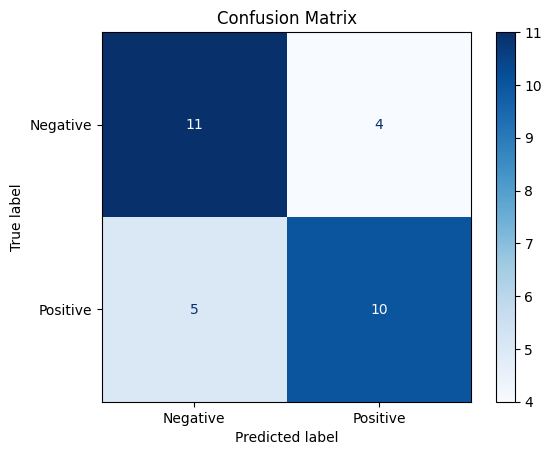


Classification Report:
              precision    recall  f1-score   support

    Negative       0.69      0.73      0.71        15
    Positive       0.71      0.67      0.69        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30

Number of selected features: 72
Shape of SHAP values: (244, 72)


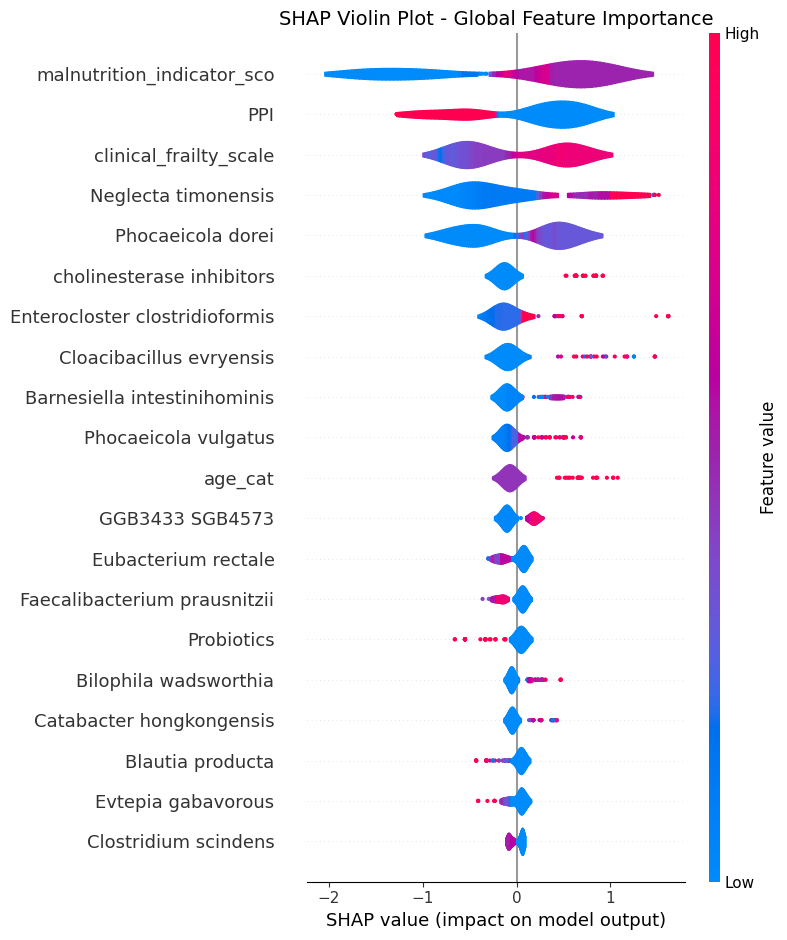

Overlap bacteria found: {'Evtepia_gabavorous', 'Gemmiger_formicilis', 'Anaerotruncus_colihominis', 'Barnesiella_intestinihominis', 'Ruminococcaceae_unclassified_SGB15260', 'Alistipes_finegoldii', 'Parasutterella_excrementihominis', 'Cloacibacillus_evryensis', 'Bacteroides_ovatus', 'Bilophila_wadsworthia', 'Ligilactobacillus_salivarius', 'Methanobrevibacter_smithii', 'Clostridiaceae_bacterium', 'Faecalibacterium_prausnitzii', 'Phocaeicola_dorei', 'Eubacterium_rectale', 'Bacteroides_xylanisolvens', 'Clostridiales_bacterium', 'Longicatena_caecimuris', 'Blautia_caecimuris', 'GGB9712_SGB15244', 'Pseudoruminococcus_massiliensis', 'Bacteroides_uniformis', 'Phascolarctobacterium_faecium', 'Ruminococcus_gnavus', 'Streptococcus_salivarius', 'Eggerthella_lenta', 'GGB3433_SGB4573', 'GGB9694_SGB15201', 'Holdemania_sp_Marseille_P2844', 'Clostridium_sp_AF34_10BH', 'Enterocloster_clostridioformis', 'Megasphaera_sp_MJR8396C', 'Alistipes_shahii', 'Clostridium_leptum', 'Massilimicrobiota_sp_An134', 'Negl

In [14]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria

        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    # scaler = StandardScaler()
    # train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    # test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device,

        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'seed': seed,
        'tree_method': gpu_device,
        'device': device,

    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 50, 300),
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        y_val_pred = model.predict(dval)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        f1_scores.append(f1_score(y_val_fold, y_val_pred_binary))
    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age", "Dementia Other"] # "malnutrition_indicator_sco", "clinical_frailty_scale", "PPI", 

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)

test_data = test_data.groupby('Alzheimers', group_keys=False).apply(
    lambda x: x.sample(n=15, random_state=seed)
).reset_index(drop=True)

X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=200)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        tree_method=gpu_device,
        device=device,
        scale_pos_weight=scale_pos_weight,

    ),
    
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model_params = {
    **{k: v for k, v in best_params.items() if k not in ['threshold', 'norm_order', 'max_features', 'n_estimators']},
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'seed': seed,
    'tree_method': gpu_device,
    'device': device,

}

dtrain_final = xgb.DMatrix(X_train_selected, label=y_train)
dtest_final = xgb.DMatrix(X_test_selected)

final_model = xgb.train(
    params=final_model_params,
    dtrain=dtrain_final,
    num_boost_round=best_params['n_estimators'],
)

# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred_binary)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in final_selector.get_support(indices=True)]
print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected, check_additivity=False)

# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 1000
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_found = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [15]:
roc_auc_score(y_test, y_test_pred_binary)

0.7000000000000001

In [16]:
pred_results = pd.DataFrame({
    'Sample ID': test_data['Sample ID'],
    'XGB True Label': y_test.astype(int),
    'XGB Predicted Binary': y_test_pred_binary
})

pred_results

,Sample ID,XGB True Label,XGB Predicted Binary
0,FB106,0,0
1,FB128,0,1
2,DC030,0,0
3,FB124,0,1
4,FB438,0,1
5,FB137,0,0
6,DC026,0,0
7,FB111,0,0
8,FB097,0,0
9,DC056,0,0


In [17]:
auc

0.7000000000000001

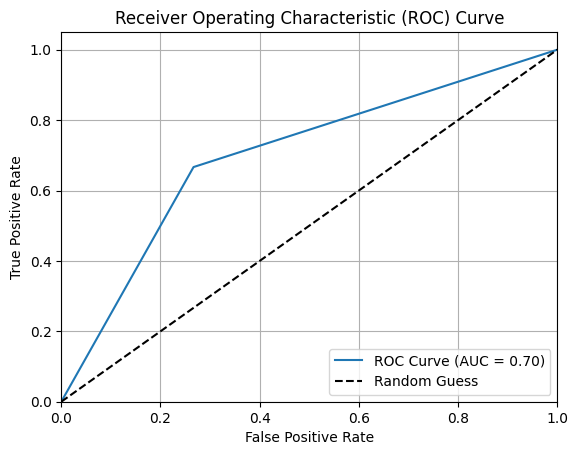

In [18]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_binary)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [19]:
accuracy

0.7

In [20]:
f1

0.6896551724137931

In [21]:
conf_matrix

array([[11,  4],
       [ 5, 10]])

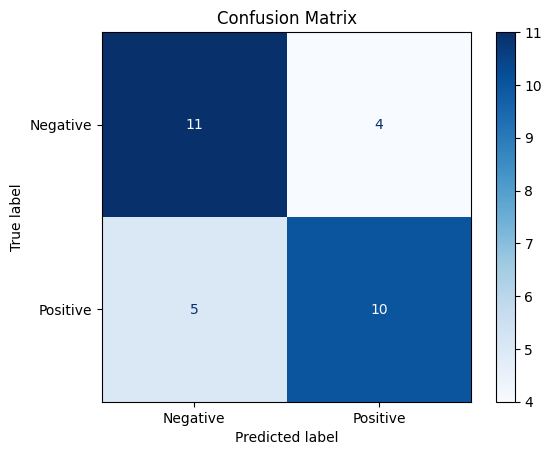

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

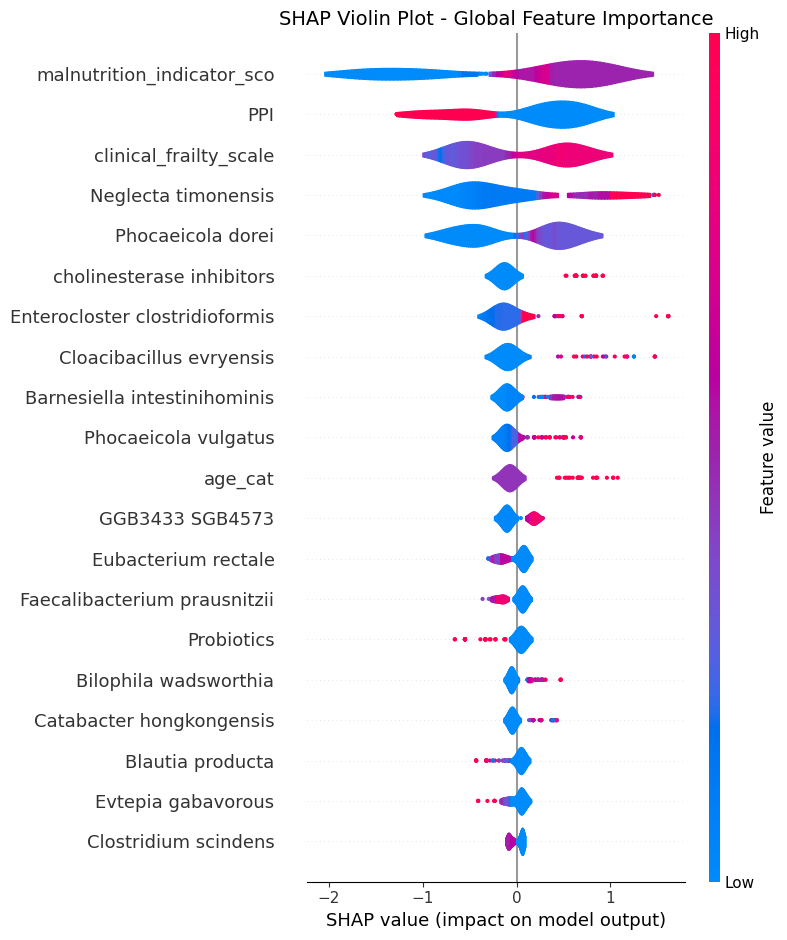

Overlap bacteria found: {'Evtepia_gabavorous', 'Gemmiger_formicilis', 'Anaerotruncus_colihominis', 'Barnesiella_intestinihominis', 'Ruminococcaceae_unclassified_SGB15260', 'Alistipes_finegoldii', 'Parasutterella_excrementihominis', 'Cloacibacillus_evryensis', 'Bacteroides_ovatus', 'Bilophila_wadsworthia', 'Ligilactobacillus_salivarius', 'Methanobrevibacter_smithii', 'Clostridiaceae_bacterium', 'Faecalibacterium_prausnitzii', 'Phocaeicola_dorei', 'Eubacterium_rectale', 'Bacteroides_xylanisolvens', 'Clostridiales_bacterium', 'Longicatena_caecimuris', 'Blautia_caecimuris', 'GGB9712_SGB15244', 'Pseudoruminococcus_massiliensis', 'Bacteroides_uniformis', 'Phascolarctobacterium_faecium', 'Ruminococcus_gnavus', 'Streptococcus_salivarius', 'Eggerthella_lenta', 'GGB3433_SGB4573', 'GGB9694_SGB15201', 'Holdemania_sp_Marseille_P2844', 'Clostridium_sp_AF34_10BH', 'Enterocloster_clostridioformis', 'Megasphaera_sp_MJR8396C', 'Alistipes_shahii', 'Clostridium_leptum', 'Massilimicrobiota_sp_An134', 'Negl

In [23]:
# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_found = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [24]:
# Compute directional SHAP statistics
mean_shap = shap_values.values.mean(axis=0)  # Mean SHAP value (directional)
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)  # Mean absolute SHAP value (magnitude)
std_shap = shap_values.values.std(axis=0)  # Standard deviation of SHAP values

# Create a DataFrame summarizing the SHAP values
directional_shap_df = pd.DataFrame({
    "Feature": selected_feature_names,
    "Mean_SHAP": mean_shap,         # Direction
    "Mean_Abs_SHAP": mean_abs_shap, # Magnitude
    "Std_SHAP": std_shap            # Variability
})

# Sort by the magnitude (Mean_Abs_SHAP) in descending order
directional_shap_df = directional_shap_df.sort_values(by="Mean_Abs_SHAP", ascending=False).reset_index(drop=True)

directional_shap_df.to_csv(f"output{os.sep}xgboost_experiment{experiment_number:02d}_shap_values.csv", index=False)

Shape of SHAP values: (244, 72)


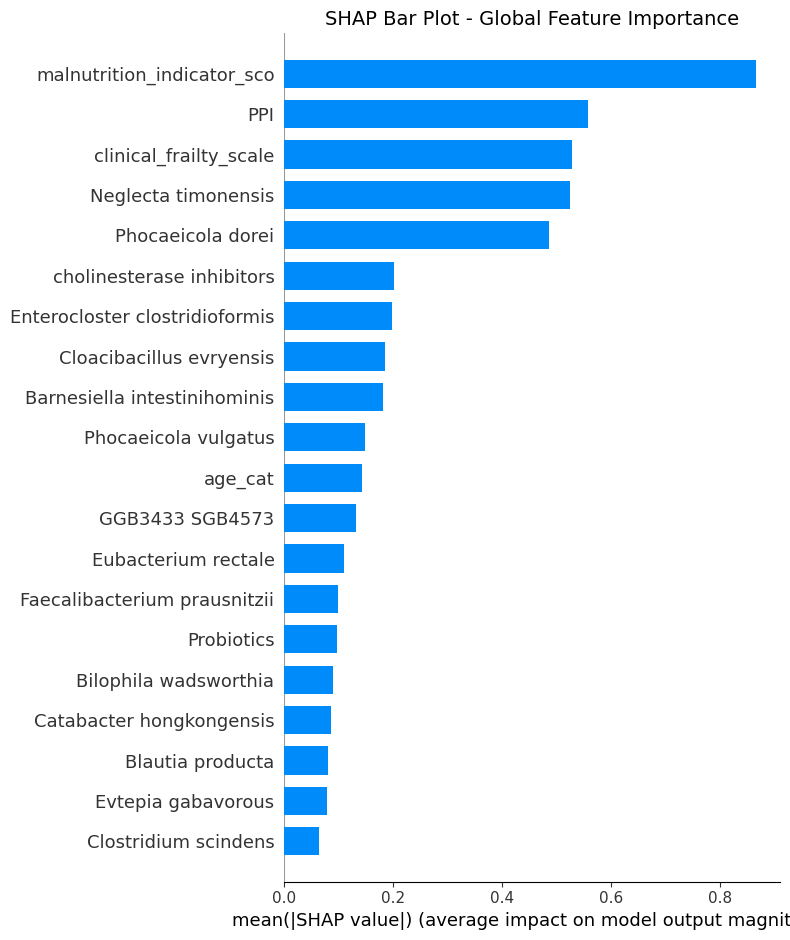

Overlap bacteria found: {'Evtepia_gabavorous', 'Gemmiger_formicilis', 'Anaerotruncus_colihominis', 'Barnesiella_intestinihominis', 'Ruminococcaceae_unclassified_SGB15260', 'Alistipes_finegoldii', 'Parasutterella_excrementihominis', 'Cloacibacillus_evryensis', 'Bacteroides_ovatus', 'Bilophila_wadsworthia', 'Ligilactobacillus_salivarius', 'Methanobrevibacter_smithii', 'Clostridiaceae_bacterium', 'Faecalibacterium_prausnitzii', 'Phocaeicola_dorei', 'Eubacterium_rectale', 'Bacteroides_xylanisolvens', 'Clostridiales_bacterium', 'Longicatena_caecimuris', 'Blautia_caecimuris', 'GGB9712_SGB15244', 'Pseudoruminococcus_massiliensis', 'Bacteroides_uniformis', 'Phascolarctobacterium_faecium', 'Ruminococcus_gnavus', 'Streptococcus_salivarius', 'Eggerthella_lenta', 'GGB3433_SGB4573', 'GGB9694_SGB15201', 'Holdemania_sp_Marseille_P2844', 'Clostridium_sp_AF34_10BH', 'Enterocloster_clostridioformis', 'Megasphaera_sp_MJR8396C', 'Alistipes_shahii', 'Clostridium_leptum', 'Massilimicrobiota_sp_An134', 'Negl

In [25]:
# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 1000
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Bar Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="bar"  # Violin plot with colors
)
plt.show()

bacteria_found = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [26]:
measures = ["xgboost", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

# 0	xgboost	315491657	1	0.820513	0.9125	0.78125
# 0	xgboost	315491657	1	0.846154	0.886806	0.8125

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,1814102137,26,0.7,0.7,0.689655


In [27]:
output_path = "output"
measures_path = f"{output_path}{os.sep}xgboost_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/xgboost_experiment26_measures.csv'

In [28]:
measures_df.to_csv(measures_path, index=False)

In [29]:
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)

# Initialize an empty list to store DataFrames for each observation
all_records = []

# Loop through all observations in the dataset
for observation_idx in range(X_train_selected.shape[0]):
    # Verify SHAP values are accessible
    if hasattr(shap_values, "values"):  # For SHAP Explanation object
        shap_values = shap_values.values

    # Verify dimensions
    assert shap_values.shape[1] == len(selected_feature_names), \
        "Mismatch between SHAP values and feature names."

    # Create a DataFrame for the current observation
    observation_df = pd.DataFrame({
        "Sample ID": [train_data["Sample ID"].iloc[observation_idx]] * len(selected_feature_names),
        "Study ID": [train_data["study_id"].iloc[observation_idx]] * len(selected_feature_names),
        "Feature Name": selected_feature_names,
        "Feature Value": X_train_selected[observation_idx, :],
        "SHAP Value": shap_values[observation_idx, :],
        "Ground Truth": [y_train[observation_idx]] * len(selected_feature_names)
    })

    # Append the observation DataFrame to the list
    all_records.append(observation_df)

# Combine all observation DataFrames into a single DataFrame
combined_force_plot_train_df = pd.concat(all_records, ignore_index=True)
combined_force_plot_train_df

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Ground Truth
0,DC071,CH1-002,age_cat,3.0000,-0.098290,0.0
1,DC071,CH1-002,abx6mo,0.0000,0.000000,0.0
2,DC071,CH1-002,hopsn,0.0000,0.000000,0.0
3,DC071,CH1-002,malnutrition_indicator_sco,2.0000,0.617307,0.0
4,DC071,CH1-002,clinical_frailty_scale,6.0000,-0.467955,0.0
...,...,...,...,...,...,...
17563,FB204,CH3-010,Longicatena caecimuris,0.0000,0.019378,0.0
17564,FB204,CH3-010,Clostridium scindens,0.0000,0.061780,0.0
17565,FB204,CH3-010,Ligilactobacillus salivarius,0.0000,0.000000,0.0
17566,FB204,CH3-010,Akkermansia sp BIOML A40,0.0013,0.000000,0.0


In [30]:
combined_force_plot_train_df[combined_force_plot_train_df['Feature Name']=='Escherichia coli']

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Ground Truth


In [31]:
train_data[train_data["Sample ID"]=='DC071'][["Escherichia coli"]]

,Escherichia coli
0,14.56875


In [32]:
# Step 2: Compute SHAP values
shap_values_test = explainer(X_test_selected, check_additivity=False)

# Initialize an empty list to store DataFrames for each observation
all_records = []

# Loop through all observations in the dataset
for observation_idx in range(X_test_selected.shape[0]):
    # Verify SHAP values are accessible
    if hasattr(shap_values_test, "values"):  # For SHAP Explanation object
        shap_values_test = shap_values_test.values

    # Verify dimensions
    assert shap_values_test.shape[1] == len(selected_feature_names), \
        "Mismatch between SHAP values and feature names."

    # Create a DataFrame for the current observation
    observation_df = pd.DataFrame({
        "Sample ID": [test_data["Sample ID"].iloc[observation_idx]] * len(selected_feature_names),
        "Study ID": [test_data["study_id"].iloc[observation_idx]] * len(selected_feature_names),
        "Feature Name": selected_feature_names,
        "Feature Value": X_test_selected[observation_idx, :],
        "SHAP Value": shap_values_test[observation_idx, :],
        "Predicted Percentage": [y_test_pred[observation_idx]] * len(selected_feature_names),
        "Predicted Status": [y_test_pred_binary[observation_idx]] * len(selected_feature_names)
    })

    # Append the observation DataFrame to the list
    all_records.append(observation_df)

# Combine all observation DataFrames into a single DataFrame
combined_force_plot_test_df = pd.concat(all_records, ignore_index=True)
combined_force_plot_test_df

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Predicted Percentage,Predicted Status
0,FB106,CH1-118,age_cat,3.00000,-0.095609,0.027304,0
1,FB106,CH1-118,abx6mo,0.00000,0.000000,0.027304,0
2,FB106,CH1-118,hopsn,0.00000,0.000000,0.027304,0
3,FB106,CH1-118,malnutrition_indicator_sco,1.00000,-0.861395,0.027304,0
4,FB106,CH1-118,clinical_frailty_scale,6.00000,-0.691251,0.027304,0
...,...,...,...,...,...,...,...
2155,FB427,CH1BL-07,Longicatena caecimuris,0.02234,-0.035569,0.906744,1
2156,FB427,CH1BL-07,Clostridium scindens,1.15938,-0.040329,0.906744,1
2157,FB427,CH1BL-07,Ligilactobacillus salivarius,0.00000,0.000000,0.906744,1
2158,FB427,CH1BL-07,Akkermansia sp BIOML A40,0.00000,0.000000,0.906744,1


In [33]:
combined_force_plot_test_df[combined_force_plot_test_df['Sample ID']=='FB246']

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Predicted Percentage,Predicted Status


In [34]:
len(selected_feature_names)

72

In [35]:
# Compute directional SHAP statistics
mean_shap = shap_values.mean(axis=0)  # Mean SHAP value (directional)
mean_abs_shap = np.abs(shap_values).mean(axis=0)  # Mean absolute SHAP value (magnitude)
std_shap = shap_values.std(axis=0)  # Standard deviation of SHAP values

# Create a DataFrame summarizing the SHAP values
directional_shap_df = pd.DataFrame({
    "Feature": selected_feature_names,
    "Mean_SHAP": mean_shap,         # Direction
    "Mean_Abs_SHAP": mean_abs_shap, # Magnitude
    "Std_SHAP": std_shap            # Variability
})

# Sort by the magnitude (Mean_Abs_SHAP) in descending order
directional_shap_df = directional_shap_df.sort_values(by="Mean_Abs_SHAP", ascending=False).reset_index(drop=True)

# Ensure the output directory exists
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
directional_shap_df.to_csv(f"{output_dir}{os.sep}xgboost_experiment{experiment_number:02d}_shap_values.csv", index=False)
directional_shap_df

,Feature,Mean_SHAP,Mean_Abs_SHAP,Std_SHAP
0,malnutrition_indicator_sco,-0.019997,0.867028,0.962787
1,PPI,0.078276,0.557513,0.608527
2,clinical_frailty_scale,-0.027717,0.527945,0.551478
3,Neglecta timonensis,-0.044137,0.524772,0.627134
4,Phocaeicola dorei,-0.004032,0.485471,0.509211
...,...,...,...,...
67,HTN,0.000000,0.000000,0.000000
68,Alistipes onderdonkii,0.000000,0.000000,0.000000
69,Beta-1 selective agents,0.000000,0.000000,0.000000
70,Diuretics,0.000000,0.000000,0.000000


In [36]:
bacteria_list = [name.replace("_", " ") for name in list(bacteria_found)]
len(bacteria_list), bacteria_list[:10]

(53,
 ['Evtepia gabavorous',
  'Gemmiger formicilis',
  'Anaerotruncus colihominis',
  'Barnesiella intestinihominis',
  'Ruminococcaceae unclassified SGB15260',
  'Alistipes finegoldii',
  'Parasutterella excrementihominis',
  'Cloacibacillus evryensis',
  'Bacteroides ovatus',
  'Bilophila wadsworthia'])

In [37]:
# Assign "bacterial variable" or "clinical variable"
directional_shap_df["Variable_Type"] = directional_shap_df["Feature"].apply(
    lambda x: "bacterial" if x in bacteria_list else "clinical"
)

directional_shap_df

,Feature,Mean_SHAP,Mean_Abs_SHAP,Std_SHAP,Variable_Type
0,malnutrition_indicator_sco,-0.019997,0.867028,0.962787,clinical
1,PPI,0.078276,0.557513,0.608527,clinical
2,clinical_frailty_scale,-0.027717,0.527945,0.551478,clinical
3,Neglecta timonensis,-0.044137,0.524772,0.627134,bacterial
4,Phocaeicola dorei,-0.004032,0.485471,0.509211,bacterial
...,...,...,...,...,...
67,HTN,0.000000,0.000000,0.000000,clinical
68,Alistipes onderdonkii,0.000000,0.000000,0.000000,bacterial
69,Beta-1 selective agents,0.000000,0.000000,0.000000,clinical
70,Diuretics,0.000000,0.000000,0.000000,clinical


In [38]:
directional_important_shap_df = directional_shap_df[
    directional_shap_df[['Mean_SHAP', 'Mean_Abs_SHAP', 'Std_SHAP']].sum(axis=1) != 0
]
directional_important_shap_df

,Feature,Mean_SHAP,Mean_Abs_SHAP,Std_SHAP,Variable_Type
0,malnutrition_indicator_sco,-0.019997,0.867028,0.962787,clinical
1,PPI,0.078276,0.557513,0.608527,clinical
2,clinical_frailty_scale,-0.027717,0.527945,0.551478,clinical
3,Neglecta timonensis,-0.044137,0.524772,0.627134,bacterial
4,Phocaeicola dorei,-0.004032,0.485471,0.509211,bacterial
5,cholinesterase inhibitors,-0.034773,0.201870,0.279353,clinical
6,Enterocloster clostridioformis,-0.045489,0.198096,0.314386,bacterial
7,Cloacibacillus evryensis,0.006717,0.185587,0.329859,bacterial
8,Barnesiella intestinihominis,0.018633,0.181778,0.236272,bacterial
9,Phocaeicola vulgatus,-0.021002,0.148701,0.195712,bacterial


In [39]:
directional_important_shap_df_sort = directional_important_shap_df.sort_values(by="Mean_Abs_SHAP", ascending=False)
directional_important_shap_df_sort.head(20)

,Feature,Mean_SHAP,Mean_Abs_SHAP,Std_SHAP,Variable_Type
0,malnutrition_indicator_sco,-0.019997,0.867028,0.962787,clinical
1,PPI,0.078276,0.557513,0.608527,clinical
2,clinical_frailty_scale,-0.027717,0.527945,0.551478,clinical
3,Neglecta timonensis,-0.044137,0.524772,0.627134,bacterial
4,Phocaeicola dorei,-0.004032,0.485471,0.509211,bacterial
5,cholinesterase inhibitors,-0.034773,0.201870,0.279353,clinical
6,Enterocloster clostridioformis,-0.045489,0.198096,0.314386,bacterial
7,Cloacibacillus evryensis,0.006717,0.185587,0.329859,bacterial
8,Barnesiella intestinihominis,0.018633,0.181778,0.236272,bacterial
9,Phocaeicola vulgatus,-0.021002,0.148701,0.195712,bacterial


In [40]:
def preprocess_no_normal_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)

    return train_data, test_data, feature_columns

train_data_no_normal, test_data_no_normal, feature_columns = preprocess_no_normal_data(clinical_microbiome_df, columns_to_drop, test_size, seed)

No overlap Study ID found.
No overlap Sample ID found.


In [41]:
from glob import glob
import shap
from sklearn.model_selection import train_test_split
import numpy as np
import os
import shutil
import re
from lxml import etree
from bs4 import BeautifulSoup
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
# from langchain.vectorstores.chroma import Chroma
from langchain_chroma import Chroma
from dataclasses import dataclass
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from openai import OpenAI
from datetime import datetime
import time
import torch
import numpy as np
import random
import ipynbname
from tqdm import tqdm
import pandas as pd
import tiktoken

os.environ['OPENAI_API_KEY'] = "sk-proj-tQi6bjiemwTkb4HL9aBVT3BlbkFJ8CXmkRGGXYI60a1VF8An"
from scripts.embeddings_utils import (
    get_embedding,
    distances_from_embeddings
)

In [42]:
print(f"Experiment name: {EXPERIMENT_NAME}", f"| Initial seed: {initial_seed}")
print(f"Seeds for Experiments: {random_integers_list}")

Experiment name: nursing_home | Initial seed: 127573839
Seeds for Experiments: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448, 2042199113, 441301073, 236793113, 387615796, 1899788307, 788877054, 681076636, 504404028, 1620098870, 847071637, 1967649092, 1010220053, 644534191, 844067037, 59236795, 1814102137, 787036043, 1853222053, 745124550, 2136397237]


In [43]:
clinical_microbiome_df

,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,DC071,CH1-002,0,2016-07-15,93.0,3.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DC013,CH1-003,0,2016-07-12,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC019,CH1-003,18,2016-07-30,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DC014,CH1-003,20,2016-08-01,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC015,CH1-003,23,2016-08-04,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,FB187,CH3-010,2,2018-01-10,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331,FB188,CH3-010,4,2018-01-12,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
332,FB185,CH3-010,6,2018-01-14,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333,FB200,CH3-010,8,2018-01-16,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
glob("global_resources/*")

['global_resources/bc_df.csv',
 'global_resources/alpha_diversity_violin_plot.png',
 'global_resources/top_30_beta_diversity_heatmap.png',
 'global_resources/clinical_microbiome_df.csv',
 'global_resources/alpha_diversity_histogram.png',
 'global_resources/clade_species_df.csv',
 'global_resources/mph_matching_ad.csv',
 'global_resources/beta_diversity_hierarchical_clustering_dendrogram.png',
 'global_resources/ad_df.csv',
 'global_resources/beta_diversity_heatmap.png',
 'global_resources/shap_paper.pdf',
 'global_resources/alpha_beta_diversity.pdf']

In [45]:
clade_species_df = pd.read_csv(f'global_resources{os.sep}clade_species_df.csv')
clade_species_df["species_name"] = clade_species_df["species_name"].str.replace("_", " ")

clade_species_df.head()

,taxonomy_hierarchy,species_name
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium prausnitzii
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Fusicatenibacter saccharivorans
2,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Eubacterium siraeum
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger formicilis
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Eubacterium rectale


In [46]:
print(f"The {EXPERIMENT_NAME} Experiment{experiment_number:02d} seed: {seed}")

The nursing_home Experiment26 seed: 1814102137


In [47]:
# Function to set the seed for reproducibility
def set_seed(seed_value=42):
    """
    Set seed for reproducibility.
    """
    print("Seed set:", seed_value)
    torch.manual_seed(seed_value)  # Sets the seed for PyTorch
    torch.cuda.manual_seed_all(seed_value)
    torch.cuda.manual_seed(seed_value)
    np.random.seed(seed_value)  # Sets the seed for NumPy
    random.seed(seed_value)  # Sets the seed for Python's random module
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Set Python hash seed
    # Ensure that CuDNN uses deterministic algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

Seed set: 1814102137


In [48]:
# Function to load documents
def load_documents(data_path, search_keyword):
    documents = []
    for filename in os.listdir(data_path):
        if filename.endswith(".xml"):
            file_path = os.path.join(data_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                cleaned_content = clean_text(content)
                documents.append(Document(page_content=cleaned_content, metadata={"source": filename, "keyword": search_keyword}))
    return documents

# Function to clean and normalize text
def clean_text(text):
    # Parse the XML
    parser = etree.XMLParser(recover=True)
    tree = etree.fromstring(text, parser=parser)
    
    # Extract text content
    raw_text = etree.tostring(tree, encoding='unicode', method='text')

    # Clean and normalize text
    soup = BeautifulSoup(raw_text, "html.parser")
    text = soup.get_text(separator=" ")
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()  # Normalize text to lowercase

    return text

def split_text(documents, chunk_size=2000):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=int(chunk_size),
        chunk_overlap=int(chunk_size * 0.2),
        length_function=len,
        add_start_index=True,
    )
    chunks = text_splitter.split_documents(documents)
    print(f"Split {len(documents)} documents into {len(chunks)} chunks.")
    
    # Add unique ID to each chunk
    for chunk in chunks:
        metadata = chunk.metadata
        unique_id = f"{metadata['source']}.{metadata['start_index']}"
        metadata['id'] = unique_id
    
    return chunks

embeddings = OpenAIEmbeddings(model = 'text-embedding-ada-002',)

In [49]:
publication_path = glob(f"..{os.sep}*data{os.sep}*publications*")[0]
publication_path

'../data/publications'

In [50]:
from glob import glob
# Dictionary to store the count of files in each folder
file_counts = {}

for folder in glob(f"{publication_path}{os.sep}*"):
    # Use glob to get the list of files in each folder
    files = glob(os.path.join(folder, '*'))
    # Store the count of files
    file_counts[folder] = len(files)

# Print the count of files for each folder
for folder, count in file_counts.items():
    print(f'{folder}: {count} files')

../data/publications/gut_microbiome: 11798 files
../data/publications/immunosenescence: 1279 files
../data/publications/bacterial_translocation: 1317 files
../data/publications/gut_brain_axis: 1649 files
../data/publications/oral_microbiome: 1357 files
../data/publications/oral_gut_microbiome: 11 files
../data/publications/alzheimers: 62480 files
../data/publications/oral_gut_axis: 20 files
../data/publications/microbial_translocation: 609 files


In [51]:
publication_list =  glob(f"..{os.sep}*data{os.sep}*publications*{os.sep}*")
publication_df = pd.DataFrame(publication_list, columns=['Publications'])
publication_df = publication_df['Publications'].str.split(os.sep, expand=True)
publication_df = publication_df.iloc[:, 2:]
publication_df.columns = ['SEARCH_TYPE', 'SEARCH_KEYWORD']
publication_df

,SEARCH_TYPE,SEARCH_KEYWORD
0,publications,gut_microbiome
1,publications,immunosenescence
2,publications,bacterial_translocation
3,publications,gut_brain_axis
4,publications,oral_microbiome
5,publications,oral_gut_microbiome
6,publications,alzheimers
7,publications,oral_gut_axis
8,publications,microbial_translocation


In [52]:
knowledge_paths = glob(f"..{os.sep}knowledge*{os.sep}knowledge_base*")
knowledge_paths

['../knowledge_base/knowledge_base_ad', '../knowledge_base/knowledge_base']

In [53]:
# Store them in a dictionary for easy reference
knowledge_db_dict = {f"knowledge_db{i+1}": db for i, db in enumerate(knowledge_paths)}

# Display the loaded databases
for key, value in knowledge_db_dict.items():
    print(f"{key}: {value}")

knowledge_db1: ../knowledge_base/knowledge_base_ad
knowledge_db2: ../knowledge_base/knowledge_base


In [54]:
SEARCH_TYPE = "publications"
CHROMA_PATH = glob(f"..{os.sep}*knowledge_base")[0]
CHROMA_PATH

'../knowledge_base'

In [55]:
import requests
import json
 
def query_vector_db(query_text, top_k=5, similarity_threshold=0.75):
    """
    Query the vector database service.
    """
    try:
        response = requests.post(
            f"{SERVER_URL}/query",
            json={
                "query": query_text,
                "top_k": top_k,
                "similarity_threshold": similarity_threshold
            }
        )
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error querying vector DB: {str(e)}")
        return None
 
def rag_model(test_query, top_k, similarity):
    """
    Queries the vector database and extracts Source and Content as a JSON object.

    Args:
        test_query (str): The query string to search in the vector database.
        top_k (int): Number of top results to retrieve.
        similarity_threshold (float): Minimum similarity score threshold for the results.

    Returns:
        str: JSON-formatted string containing Source and Content.
    """

    # Query the vector database
    results = query_vector_db(
        query_text=test_query,
        top_k=top_k,
        similarity_threshold=similarity
    )

    # Regular expression to match Source and Content
    rag_pattern = r"Source: (.+?)\nContent: (.+?)(?:\nRelevance Score:|\n---|$)"

    # Find all matches
    rag_matches = re.findall(rag_pattern, results['context'], re.DOTALL)

    # Convert matches into a list of dictionaries
    rag_data = [{"Source": source.strip(), "Content": content.strip()} for source, content in rag_matches]

    # Convert the list of dictionaries to JSON
    rag_json = json.dumps(rag_data, indent=4)

    return rag_json

In [56]:
# Define URLs
win_url = "http://127.0.0.1:5000"
ubuntu_url = "http://146.189.163.52:5000"

# Check operating system
if platform.system() == "Windows":
    SERVER_URL = win_url
else:
    SERVER_URL = ubuntu_url

print(f"SERVER_URL set to: {SERVER_URL}")

# Define the query
query_text = (
    "taxonomy_hierarchy is 'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_unclassified|s__Lachnospiraceae_bacterium_10_1'. "
    "and species_name is 'Lachnospiraceae_bacterium_10_1' found in gut microbiome, "
    "define the description and group of this species in the context of alzheimer's disease at species level. "
)

# Start timing
start_time = time.perf_counter()

# Execute the RAG model
rag_output = rag_model(query_text, top_k=5, similarity=0.8)

# End timing
end_time = time.perf_counter()

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.2f} seconds")

# Display RAG output
print("\nRAG Output:\n")
print(rag_output)

SERVER_URL set to: http://146.189.163.52:5000
Execution Time: 0.47 seconds

RAG Output:

[
    {
        "Source": "PMC9941547.xml",
        "Content": "description of hierarchical clustering at bacterial phylum, family, and genus levels for individual samples is presented in supplementary figure s2. figure 2 effect of resistant starches from dietary pulses on gut microbiome diversity and taxonomic hierarchies. alpha-diversity of microbiome of each group determined using (a) shannon index and (b) chao1 index. (c) pcoa analysis representing \u03b2-diversity of microbiome of each group combined or male and female groups. (d) sex-specific differences in microbiome composition for each group; covariance ellipses are displayed and bounds (dotted lines) of each group with two standard deviations (2\u03c3) in each direction from the group mean. relative abundance of gut microbiome in male and female mice or all combined at (e) phylum level and (f) genus level. ptb, pinto beans; bep, black-eye

In [57]:
clinical_microbiome_df

,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,DC071,CH1-002,0,2016-07-15,93.0,3.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DC013,CH1-003,0,2016-07-12,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC019,CH1-003,18,2016-07-30,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DC014,CH1-003,20,2016-08-01,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC015,CH1-003,23,2016-08-04,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,FB187,CH3-010,2,2018-01-10,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331,FB188,CH3-010,4,2018-01-12,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
332,FB185,CH3-010,6,2018-01-14,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
333,FB200,CH3-010,8,2018-01-16,76.0,2.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
glob("global_resources/*")

['global_resources/bc_df.csv',
 'global_resources/alpha_diversity_violin_plot.png',
 'global_resources/top_30_beta_diversity_heatmap.png',
 'global_resources/clinical_microbiome_df.csv',
 'global_resources/alpha_diversity_histogram.png',
 'global_resources/clade_species_df.csv',
 'global_resources/mph_matching_ad.csv',
 'global_resources/beta_diversity_hierarchical_clustering_dendrogram.png',
 'global_resources/ad_df.csv',
 'global_resources/beta_diversity_heatmap.png',
 'global_resources/shap_paper.pdf',
 'global_resources/alpha_beta_diversity.pdf']

In [59]:
clade_species_df = pd.read_csv(f'global_resources{os.sep}clade_species_df.csv')
clade_species_df["species_name"] = clade_species_df["species_name"].str.replace("_", " ")

clade_species_df.head()

,taxonomy_hierarchy,species_name
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium prausnitzii
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Fusicatenibacter saccharivorans
2,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Eubacterium siraeum
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger formicilis
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Eubacterium rectale


In [60]:
print(f"The {EXPERIMENT_NAME} Experiment{experiment_number:02d} seed: {seed}")

The nursing_home Experiment26 seed: 1814102137


In [61]:
SEARCH_TYPE, CHROMA_PATH

('publications', '../knowledge_base')

In [62]:
# Function to set the seed for reproducibility
def set_seed(seed_value=42):
    """
    Set seed for reproducibility.
    """
    print("Seed set:", seed_value)
    torch.manual_seed(seed_value)  # Sets the seed for PyTorch
    torch.cuda.manual_seed_all(seed_value)
    torch.cuda.manual_seed(seed_value)
    np.random.seed(seed_value)  # Sets the seed for NumPy
    random.seed(seed_value)  # Sets the seed for Python's random module
    os.environ['PYTHONHASHSEED'] = str(seed_value)  # Set Python hash seed
    # Ensure that CuDNN uses deterministic algorithms
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

Seed set: 1814102137


In [63]:
embeddings = OpenAIEmbeddings(model = 'text-embedding-ada-002',)

In [64]:
publication_path

'../data/publications'

In [65]:
publication_df

,SEARCH_TYPE,SEARCH_KEYWORD
0,publications,gut_microbiome
1,publications,immunosenescence
2,publications,bacterial_translocation
3,publications,gut_brain_axis
4,publications,oral_microbiome
5,publications,oral_gut_microbiome
6,publications,alzheimers
7,publications,oral_gut_axis
8,publications,microbial_translocation


In [66]:
knowledge_paths

['../knowledge_base/knowledge_base_ad', '../knowledge_base/knowledge_base']

In [67]:
len(clinical_microbiome_df['study_id'].unique()), len(train_data_no_normal['study_id'].unique()), len(test_data_no_normal['study_id'].unique())

(102, 76, 26)

In [68]:
clinical_microbiome_tr = train_data
print(clinical_microbiome_tr['Alzheimers'].value_counts())
print(clinical_microbiome_tr['Alzheimers'].value_counts(normalize=True))
clinical_microbiome_tr.head()

0.0    160
1.0     84
Name: Alzheimers, dtype: int64
0.0    0.655738
1.0    0.344262
Name: Alzheimers, dtype: float64


,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,DC071,CH1-002,0.0,2016-07-15,93.0,3.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DC013,CH1-003,0.0,2016-07-12,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC019,CH1-003,18.0,2016-07-30,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DC014,CH1-003,20.0,2016-08-01,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC015,CH1-003,23.0,2016-08-04,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
clinical_microbiome_tt = test_data
print(clinical_microbiome_tt['Alzheimers'].value_counts())
print(clinical_microbiome_tt['Alzheimers'].value_counts(normalize=True))
clinical_microbiome_tt.head()

0.0    15
1.0    15
Name: Alzheimers, dtype: int64
0.0    0.5
1.0    0.5
Name: Alzheimers, dtype: float64


,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,FB106,CH1-118,0.0,2017-09-18,91.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FB128,CH1-107,106.0,2017-11-03,81.0,2.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC030,CH1-009,18.0,2016-08-18,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FB124,CH1-107,67.0,2017-09-25,81.0,2.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FB438,CH1-172,286.0,2019-03-28,90.0,3.0,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
len_tr, len_tt = len(clinical_microbiome_tr), len(clinical_microbiome_tt)
len_total = len_tr+len_tt
round(len_tr/len_total, 2), round(len_tt/len_total, 2), len_tr, len_tt

(0.89, 0.11, 244, 30)

In [71]:
# Check for uniqueness of existence
tr_in_tt_unique = clinical_microbiome_tr['Sample ID'].isin(clinical_microbiome_tt['Sample ID']).unique().tolist()
tt_in_tr_unique = clinical_microbiome_tt['Sample ID'].isin(clinical_microbiome_tr['Sample ID']).unique().tolist()

tr_in_tt_unique, tt_in_tr_unique

([False], [False])

In [72]:
# Check for uniqueness of existence
tr_in_tt_unique = clinical_microbiome_tr['study_id'].isin(clinical_microbiome_tt['study_id']).unique().tolist()
tt_in_tr_unique = clinical_microbiome_tt['study_id'].isin(clinical_microbiome_tr['study_id']).unique().tolist()

tr_in_tt_unique, tt_in_tr_unique

([False], [False])

In [73]:
clinical_data_dictionary = pd.read_csv(f"..{os.sep}data{os.sep}clinical_variable_explanations_df.csv")
clinical_data_dictionary

,Feature Name,Feature Notes,Feature Group,Feature Description,Feature Explanation
0,ID Match,Identifier for patient or participant matching...,Study Identification,Identifier for patient or participant matching...,- **Feature Name:** ID Match\n\n - **Definiti...
1,Sample ID,Unique Sample Identifier,Study Identification,Unique identifier for biological or clinical s...,- **Feature Name:** Sample ID\n\n - **Definit...
2,Version 2,If there is a second metaphlan file,Study Identification,Version control for data entry or survey.,- **Feature Name:** Version 2\n\n - **Definit...
3,Version 3,If there is a third metaphlan file,Study Identification,Updated version for data entry or survey.,- **Feature Name:** Version 3\n\n - **Definit...
4,study_id,Unique ID number for each elder,Study Identification,Identifier for the specific study or research ...,- **Feature Name:** study_id\n\n - **Definiti...
...,...,...,...,...,...
112,Severe Liver disease,Each medical problem Y/N,Hepatic Condition,Advanced liver disease diagnosis.,- **Feature Name:** Severe Liver Disease\n\n ...
113,ostomy,Each medical problem Y/N,Surgical History,Presence of an ostomy.,- **Feature Name:** ostomy\n\n - **Definition...
114,Alzheimers,Each medical problem Y/N,Neurological Condition,Diagnosis of Alzheimer's disease.,- **Feature Name:** Alzheimers\n\n - **Defini...
115,Dementia Other,Each medical problem Y/N,Neurological Condition,Other forms of dementia.,- **Feature Name:** Dementia Other\n\n - **De...


In [74]:
train_sample_ids = train_data['Sample ID'].tolist()
test_sample_ids = test_data['Sample ID'].tolist()

In [75]:
train_study_ids = set(train_data['study_id'].tolist())
test_study_ids = set(test_data['study_id'].tolist())

In [76]:
filtered_mph_matching_df = pd.read_csv(f"global_resources{os.sep}mph_matching_ad.csv")
print(filtered_mph_matching_df.shape)
filtered_mph_matching_df

(940, 354)


,species_name,DC001,DC002,DC003,DC004,DC005,DC006,DC007,DC008,DC009,...,FB438,FB439,FB441,FB442,FB443,FB444,FB445,FB446,FB447,FB448
0,Faecalibacterium prausnitzii,0.88312,4.15614,3.26882,0.63443,0.58702,0.00000,1.62361,0.00000,0.00000,...,0.00000,0.00000,0.82179,0.00000,1.33651,0.19949,1.73410,0.00000,0.00000,0.00000
1,Fusicatenibacter saccharivorans,0.00000,1.11662,0.12883,0.00000,1.27934,0.20162,0.71500,0.62379,1.77729,...,0.00000,0.00000,0.21130,0.00000,0.07712,0.00000,0.00000,0.00000,0.01925,0.00000
2,Eubacterium siraeum,0.21021,0.42263,0.36465,0.00000,0.15773,0.00000,0.72401,1.32474,0.03696,...,0.39056,0.00000,1.35903,2.07693,7.43349,8.26477,0.00000,0.04898,0.75876,0.01841
3,Gemmiger formicilis,0.00000,0.83369,0.69436,0.00000,0.53212,0.00000,1.36817,0.33282,0.00000,...,0.00000,0.00000,0.00613,0.00000,0.15577,0.02192,1.08905,0.00000,0.00000,0.00000
4,Eubacterium rectale,3.76495,10.46160,5.29382,15.00962,3.38370,11.91188,0.75707,3.11820,9.77486,...,0.00000,4.35475,1.75420,0.29009,2.36991,0.06056,3.74028,0.04205,0.54103,0.00410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
935,Schaalia meyeri,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
936,Ndongobacter massiliensis,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
937,Actinomyces radicidentis,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
938,Candida tropicalis,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [77]:
filtered_mph_matching_df_t = filtered_mph_matching_df.set_index("species_name").T.reset_index()
filtered_mph_matching_df_t = filtered_mph_matching_df_t.rename(columns={'index': 'sample_ids'})
filtered_mph_matching_df_t = filtered_mph_matching_df_t.set_index('sample_ids')

filtered_mph_matching_df_t
# filtered_mph_matching_df_t.reset_index()

species_name,Faecalibacterium prausnitzii,Fusicatenibacter saccharivorans,Eubacterium siraeum,Gemmiger formicilis,Eubacterium rectale,Phocaeicola vulgatus,Lachnospiraceae bacterium WCA3 601 WT 6H,Alistipes putredinis,Clostridium sp AF15 49,Blautia wexlerae,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
sample_ids,,,,,,,,,,,,,,,,,,,,,
DC001,0.88312,0.00000,0.21021,0.00000,3.76495,0.00000,0.0,3.06212,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC002,4.15614,1.11662,0.42263,0.83369,10.46160,0.00000,0.0,0.82635,0.0,2.34879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC003,3.26882,0.12883,0.36465,0.69436,5.29382,0.00000,0.0,1.29773,0.0,1.11542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC004,0.63443,0.00000,0.00000,0.00000,15.00962,0.00000,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC005,0.58702,1.27934,0.15773,0.53212,3.38370,0.00000,0.0,1.24714,0.0,1.26064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FB444,0.19949,0.00000,8.26477,0.02192,0.06056,4.68323,0.0,2.80867,0.0,0.49110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FB445,1.73410,0.00000,0.00000,1.08905,3.74028,0.00776,0.0,0.00000,0.0,5.53794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FB446,0.00000,0.00000,0.04898,0.00000,0.04205,2.15788,0.0,0.17875,0.0,18.88493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
matching_index = filtered_mph_matching_df_t.index
# Filter rows in filtered_mph_matching_df_t based on Sample IDs in clinical_microbiome_df
filtered_mph_matching_df_t = filtered_mph_matching_df_t[
    filtered_mph_matching_df_t.index.isin(clinical_microbiome_df["Sample ID"])
]

# Display the new filtered DataFrame
filtered_mph_matching_df_t

species_name,Faecalibacterium prausnitzii,Fusicatenibacter saccharivorans,Eubacterium siraeum,Gemmiger formicilis,Eubacterium rectale,Phocaeicola vulgatus,Lachnospiraceae bacterium WCA3 601 WT 6H,Alistipes putredinis,Clostridium sp AF15 49,Blautia wexlerae,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
sample_ids,,,,,,,,,,,,,,,,,,,,,
DC001,0.88312,0.00000,0.21021,0.00000,3.76495,0.00000,0.0,3.06212,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC002,4.15614,1.11662,0.42263,0.83369,10.46160,0.00000,0.0,0.82635,0.0,2.34879,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC003,3.26882,0.12883,0.36465,0.69436,5.29382,0.00000,0.0,1.29773,0.0,1.11542,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC004,0.63443,0.00000,0.00000,0.00000,15.00962,0.00000,0.0,0.00000,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DC005,0.58702,1.27934,0.15773,0.53212,3.38370,0.00000,0.0,1.24714,0.0,1.26064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FB443,1.33651,0.07712,7.43349,0.15577,2.36991,6.07880,0.0,1.74378,0.0,0.43944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FB444,0.19949,0.00000,8.26477,0.02192,0.06056,4.68323,0.0,2.80867,0.0,0.49110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FB445,1.73410,0.00000,0.00000,1.08905,3.74028,0.00776,0.0,0.00000,0.0,5.53794,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [79]:
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity # Import beta_diversity directly

def calculate_and_save_alpha_diversity(df, sample_ids, metric='shannon', output_filename=None):
    """
    Calculate alpha diversity for the given DataFrame and sample IDs, and save the results to a file.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with microbial data.
        sample_ids (list): List of sample IDs to filter.
        metric (str): Diversity metric to use (default is 'shannon').
        output_filename (str): Path to save the results (default is None, which skips saving).
        
    Returns:
        pd.DataFrame: Alpha diversity results with 'Sample ID' and metric value.
    """
    filtered_df = df[df.index.isin(sample_ids)]
    print(f"Filtered DataFrame Shape: {filtered_df.shape}")
    diversity = alpha_diversity(metric, filtered_df.values, ids=filtered_df.index)
    diversity_df = pd.DataFrame(diversity, index=filtered_df.index).reset_index()
    diversity_df.columns = ['Sample ID', f"Alpha Diversity ({metric.capitalize()} Index)"]
    
    # Save to file if a filename is provided
    if output_filename:
        # Create directory path if it doesn't exist
        directory = os.path.dirname(output_filename)
        if directory and not os.path.exists(directory):
            os.makedirs(directory)
            print(f"Created directory: {directory}")
            
        diversity_df.to_csv(output_filename, index=False)
        print(f"Alpha Diversity results saved to {output_filename}")
    
    return diversity_df

# Calculate Alpha Diversity for different datasets and save results
# Full dataset
ad_df = calculate_and_save_alpha_diversity(
    filtered_mph_matching_df_t,
    filtered_mph_matching_df_t.index.tolist(),
    output_filename=f"global_resources{os.sep}ad_df.csv"
)

# Train dataset
ad_df_tr = calculate_and_save_alpha_diversity(
    filtered_mph_matching_df_t,
    train_sample_ids,
    output_filename=f"local_resources{os.sep}experiment{experiment_number:02}{os.sep}biostatistics{os.sep}ad_df_tr.csv"
)
# print("\nAlpha Diversity (Shannon Index) for Train Dataset:")
# print(ad_df_tr)

# Test dataset
ad_df_tt = calculate_and_save_alpha_diversity(
    filtered_mph_matching_df_t,
    test_sample_ids,
    output_filename=f"local_resources{os.sep}experiment{experiment_number:02}{os.sep}biostatistics{os.sep}ad_df_tt.csv"
)
# print("\nAlpha Diversity (Shannon Index) for Test Dataset:")
# print(ad_df_tt)

print("\nAlpha Diversity (Shannon Index) for Full Dataset:")
ad_df

Filtered DataFrame Shape: (335, 940)
Alpha Diversity results saved to global_resources/ad_df.csv
Filtered DataFrame Shape: (244, 940)
Created directory: local_resources/experiment26/biostatistics
Alpha Diversity results saved to local_resources/experiment26/biostatistics/ad_df_tr.csv
Filtered DataFrame Shape: (30, 940)
Alpha Diversity results saved to local_resources/experiment26/biostatistics/ad_df_tt.csv

Alpha Diversity (Shannon Index) for Full Dataset:


,Sample ID,Alpha Diversity (Shannon Index)
0,DC001,2.519907
1,DC002,3.451174
2,DC003,3.385870
3,DC004,2.834624
4,DC005,3.290396
...,...,...
330,FB443,3.560865
331,FB444,3.401113
332,FB445,3.300568
333,FB446,3.303342


In [80]:
# Train dataset
measure_list= ['shannon', 'simpson', 'berger_parker_d']
# Loop through metrics and calculate alpha diversity
all_alpha_div_results = []
for ad_measure in measure_list:
    # Use your calculate_and_save_alpha_diversity function
    ad_temp = calculate_and_save_alpha_diversity(
        filtered_mph_matching_df_t,  # Replace with your DataFrame variable
        filtered_mph_matching_df_t.index.tolist(),  # Replace with your sample IDs
        metric=ad_measure
    )
    
    # Append the results to the list
    all_alpha_div_results.append(ad_temp)
    
    # Print the results for the current metric
    # print(f"\nAlpha Diversity ({ad_measure} Index) for Full Dataset:")
    # print(ad_temp)

# Combine results into a single DataFrame
combined_alpha_div_df = pd.concat(all_alpha_div_results, axis=1)

# Display combined results
print("\nCombined Alpha Diversity Metrics:")
combined_alpha_div_df = combined_alpha_div_df.loc[:, ~combined_alpha_div_df.columns.duplicated()]
combined_alpha_div_df

Filtered DataFrame Shape: (335, 940)
Filtered DataFrame Shape: (335, 940)
Filtered DataFrame Shape: (335, 940)

Combined Alpha Diversity Metrics:


,Sample ID,Alpha Diversity (Shannon Index),Alpha Diversity (Simpson Index),Alpha Diversity (Berger_parker_d Index)
0,DC001,2.519907,0.881144,0.207141
1,DC002,3.451174,0.955258,0.104616
2,DC003,3.385870,0.951319,0.122270
3,DC004,2.834624,0.924893,0.150096
4,DC005,3.290396,0.932922,0.203456
...,...,...,...,...
330,FB443,3.560865,0.948860,0.143986
331,FB444,3.401113,0.946262,0.107723
332,FB445,3.300568,0.933426,0.189150
333,FB446,3.303342,0.930105,0.188849


In [81]:
all_alpha_div_results[1]

,Sample ID,Alpha Diversity (Simpson Index)
0,DC001,0.881144
1,DC002,0.955258
2,DC003,0.951319
3,DC004,0.924893
4,DC005,0.932922
...,...,...
330,FB443,0.948860
331,FB444,0.946262
332,FB445,0.933426
333,FB446,0.930105


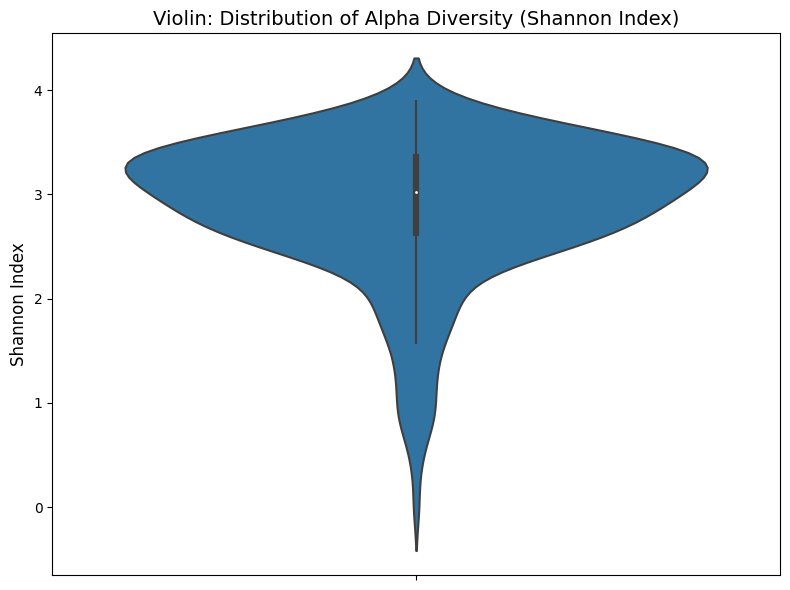

'global_resources/alpha_diversity_violin_plot.png'

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
# Create a violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(y="Alpha Diversity (Shannon Index)", data=ad_df)
plt.title('Violin: Distribution of Alpha Diversity (Shannon Index)', fontsize=14)
plt.ylabel('Shannon Index', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.violinplot(y="Alpha Diversity (Shannon Index)", data=ad_df)
plt.title('Violin: Distribution of Alpha Diversity (Shannon Index)', fontsize=14)
plt.ylabel('Shannon Index', fontsize=12)
plt.tight_layout()

# Save the plot to a file
output_path = f'global_resources{os.sep}alpha_diversity_violin_plot.png'
plt.savefig(output_path, dpi=300)
plt.close()

output_path

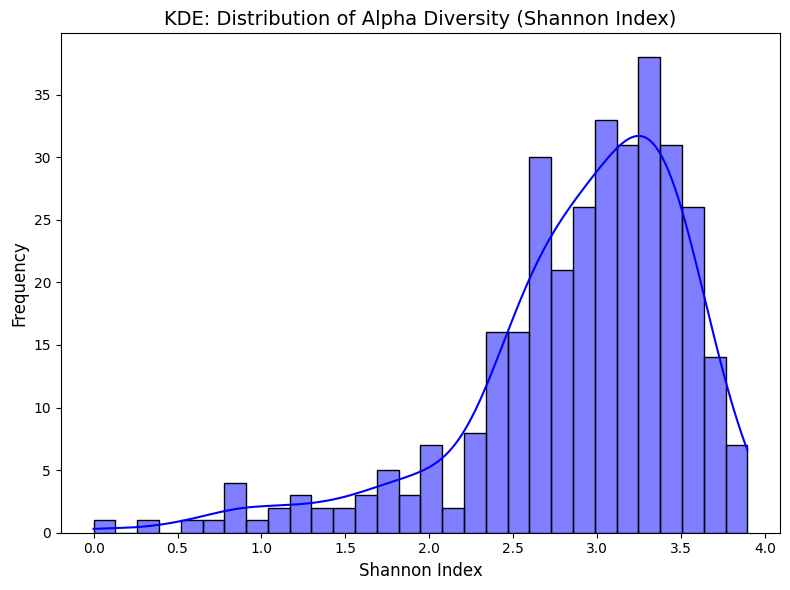

'global_resources/alpha_diversity_histogram.png'

In [83]:
# Histogram of Shannon Index (Alpha Diversity)
plt.figure(figsize=(8, 6))
sns.histplot(ad_df["Alpha Diversity (Shannon Index)"], bins=30, kde=True, color='blue')
plt.title("KDE: Distribution of Alpha Diversity (Shannon Index)", fontsize=14)
plt.xlabel("Shannon Index", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(ad_df["Alpha Diversity (Shannon Index)"], bins=30, kde=True, color='blue')
plt.title("KDE: Distribution of Alpha Diversity (Shannon Index)", fontsize=14)
plt.xlabel("Shannon Index", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()

# Save the plot to a file
output_hist_path = f'global_resources{os.sep}alpha_diversity_histogram.png'
plt.savefig(output_hist_path, dpi=300)
plt.close()

output_hist_path

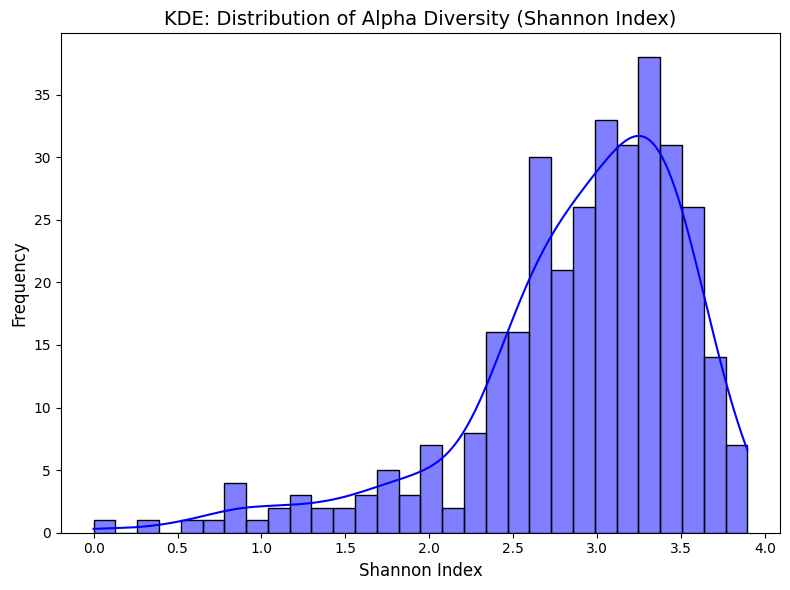

'global_resources/alpha_diversity_histogram.png'

In [84]:
# Histogram of Shannon Index (Alpha Diversity)
plt.figure(figsize=(8, 6))
sns.histplot(ad_df["Alpha Diversity (Shannon Index)"], bins=30, kde=True, color='blue')
plt.title("KDE: Distribution of Alpha Diversity (Shannon Index)", fontsize=14)
plt.xlabel("Shannon Index", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(ad_df["Alpha Diversity (Shannon Index)"], bins=30, kde=True, color='blue')
plt.title("KDE: Distribution of Alpha Diversity (Shannon Index)", fontsize=14)
plt.xlabel("Shannon Index", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()

# Save the plot to a file
output_hist_path = f'global_resources{os.sep}alpha_diversity_histogram.png'
plt.savefig(output_hist_path, dpi=300)
plt.close()

output_hist_path

In [85]:
from skbio.diversity import beta_diversity

def calculate_and_save_beta_diversity(df, sample_ids, method="braycurtis", output_filename=None):
    """
    Calculate beta diversity for a subset of samples and save the results to a file if specified.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with microbial data.
        sample_ids (list): List of sample IDs to filter.
        method (str): Beta diversity metric to use (default is 'braycurtis').
        output_filename (str): Path to save the beta diversity DataFrame (default is None, which skips saving).
        
    Returns:
        pd.DataFrame: Beta diversity DataFrame (square distance matrix).
    """
    # Filter the DataFrame based on sample IDs
    filtered_df = df[df.index.isin(sample_ids)]
    print(f"Filtered DataFrame Shape: {filtered_df.shape}")
    
    # Calculate beta diversity
    sample_id = filtered_df.index
    bc_dm = beta_diversity(method, filtered_df.values, ids=sample_id)
    bc_df = pd.DataFrame(bc_dm.data, index=bc_dm.ids, columns=bc_dm.ids)
    
    # Save to CSV if a filename is provided
    if output_filename:
        bc_df.to_csv(output_filename, index=False)
        print(f"Beta Diversity results saved to {output_filename}")
    
    return bc_df

# Full dataset
bc_df = calculate_and_save_beta_diversity(
    filtered_mph_matching_df_t,
    filtered_mph_matching_df_t.index.tolist(),
    output_filename=f"global_resources{os.sep}bc_df.csv"
)
print("\nBeta Diversity (Bray-Curtis Dissimilarity) for Full Dataset:")
print(bc_df)

# Train dataset
bc_df_tr = calculate_and_save_beta_diversity(
    filtered_mph_matching_df_t,
    train_sample_ids,
    output_filename=f"local_resources{os.sep}experiment{experiment_number:02}{os.sep}biostatistics{os.sep}bc_df_tr.csv"
)
print("\nBeta Diversity (Bray-Curtis Dissimilarity) for Train Dataset:")
print(bc_df_tr)

# Test dataset
bc_df_tt = calculate_and_save_beta_diversity(
    filtered_mph_matching_df_t,
    test_sample_ids,
    output_filename=f"local_resources{os.sep}experiment{experiment_number:02}{os.sep}biostatistics{os.sep}bc_df_tt.csv"
)
print("\nBeta Diversity (Bray-Curtis Dissimilarity) for Test Dataset:")
print(bc_df_tt)

Filtered DataFrame Shape: (335, 940)
Beta Diversity results saved to global_resources/bc_df.csv

Beta Diversity (Bray-Curtis Dissimilarity) for Full Dataset:
          DC001     DC002     DC003     DC004     DC005     DC006     DC007  \
DC001  0.000000  0.643103  0.494985  0.668307  0.500148  0.444798  0.492854   
DC002  0.643103  0.000000  0.337175  0.316846  0.316432  0.396707  0.364480   
DC003  0.494985  0.337175  0.000000  0.473713  0.263922  0.398276  0.236307   
DC004  0.668307  0.316846  0.473713  0.000000  0.436897  0.362643  0.446416   
DC005  0.500148  0.316432  0.263922  0.436897  0.000000  0.391218  0.314184   
...         ...       ...       ...       ...       ...       ...       ...   
FB443  0.772637  0.796514  0.749373  0.876250  0.769026  0.814249  0.775815   
FB444  0.775156  0.839791  0.765074  0.901218  0.747771  0.815115  0.769177   
FB445  0.912875  0.820395  0.833680  0.888483  0.831408  0.884409  0.876363   
FB446  0.963617  0.831321  0.878053  0.859737  0.845

In [86]:
from skbio.diversity import beta_diversity
import pandas as pd

# Define beta diversity metrics to calculate
beta_measure_list = ["braycurtis", "jaccard", "canberra"]

# Initialize an empty list to store results
all_beta_div_results = []

# Loop through metrics and calculate beta diversity
for beta_measure in beta_measure_list:
    # Calculate beta diversity for the current metric
    beta_matrix = beta_diversity(
        metric=beta_measure,
        counts=filtered_mph_matching_df_t.values,
        ids=filtered_mph_matching_df_t.index.tolist(),
    )
    
    # Convert the distance matrix to a DataFrame
    beta_df = beta_matrix.to_data_frame()
    
    # Rename columns to include the metric name
    beta_df.columns = [f"{beta_measure}_{col}" for col in beta_df.columns]
    
    # Append the result to the list
    all_beta_div_results.append(beta_df)

# Combine all results into a single DataFrame
combined_beta_div_df = pd.concat(all_beta_div_results, axis=1)

# Remove duplicate columns if necessary
combined_beta_div_df = combined_beta_div_df.loc[:, ~combined_beta_div_df.columns.duplicated()]

# Display combined results
print("\nCombined Beta Diversity Metrics:")
combined_beta_div_df


Combined Beta Diversity Metrics:


,braycurtis_DC001,braycurtis_DC002,braycurtis_DC003,braycurtis_DC004,braycurtis_DC005,braycurtis_DC006,braycurtis_DC007,braycurtis_DC008,braycurtis_DC009,braycurtis_DC010,...,canberra_FB437,canberra_FB438,canberra_FB439,canberra_FB441,canberra_FB442,canberra_FB443,canberra_FB444,canberra_FB445,canberra_FB446,canberra_FB448
DC001,0.000000,0.643103,0.494985,0.668307,0.500148,0.444798,0.492854,0.497710,0.736109,0.596560,...,35.720561,121.364165,71.828279,165.239564,100.137246,119.138390,118.333847,95.061015,113.677370,74.157809
DC002,0.643103,0.000000,0.337175,0.316846,0.316432,0.396707,0.364480,0.363080,0.316974,0.258380,...,76.829546,148.019834,102.911872,182.702120,114.919194,134.134505,140.976635,116.506198,136.249493,108.463112
DC003,0.494985,0.337175,0.000000,0.473713,0.263922,0.398276,0.236307,0.326517,0.514070,0.312875,...,73.851119,144.404393,98.679067,173.611986,113.303922,131.651433,139.725612,113.063879,132.338161,102.727156
DC004,0.668307,0.316846,0.473713,0.000000,0.436897,0.362643,0.446416,0.425975,0.373689,0.397113,...,41.000000,128.694546,72.052417,165.780706,99.086939,122.398380,120.102418,97.011603,114.066525,83.110478
DC005,0.500148,0.316432,0.263922,0.436897,0.000000,0.391218,0.314184,0.240515,0.452632,0.301450,...,77.808744,147.490650,103.062622,175.900183,117.341291,133.931549,137.088198,115.940697,139.478953,106.947796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FB443,0.772637,0.796514,0.749373,0.876250,0.769026,0.814249,0.775815,0.786866,0.843514,0.772193,...,121.490670,167.770546,136.719114,200.741255,145.979143,0.000000,92.871359,149.756841,171.939866,142.224116
FB444,0.775156,0.839791,0.765074,0.901218,0.747771,0.815115,0.769177,0.787585,0.866155,0.803643,...,117.961892,167.324947,135.741633,201.725342,144.779384,92.871359,0.000000,147.619906,164.825441,138.705567
FB445,0.912875,0.820395,0.833680,0.888483,0.831408,0.884409,0.876363,0.877615,0.870110,0.852263,...,87.393966,118.159827,88.310041,187.628764,118.080739,149.756841,147.619906,0.000000,124.921936,90.448572
FB446,0.963617,0.831321,0.878053,0.859737,0.845236,0.944040,0.880097,0.842805,0.910949,0.833863,...,100.769739,130.093401,111.530991,215.036188,131.759275,171.939866,164.825441,124.921936,0.000000,107.292205


In [87]:
# Splitting bc_df into hc (healthy control) and ad (Alzheimer's patients) DataFrames
# hc_ids, ad_ids
hc_ids = clinical_microbiome_df[clinical_microbiome_df['Alzheimers'] == 0.0]['Sample ID']
ad_ids = clinical_microbiome_df[clinical_microbiome_df['Alzheimers'] == 1.0]['Sample ID']

# Creating bc_df_hc and bc_df_ad using the sample IDs from filtered_training_clinical_df
bc_df_hc = bc_df.loc[bc_df.index.intersection(hc_ids), bc_df.columns.intersection(hc_ids)]
bc_df_ad = bc_df.loc[bc_df.index.intersection(ad_ids), bc_df.columns.intersection(ad_ids)]

# Display the resulting DataFrames
bc_df_hc.head()

,DC001,DC002,DC003,DC004,DC005,DC006,DC007,DC008,DC009,DC010,...,FB432,FB433,FB435,FB437,FB438,FB441,FB443,FB444,FB445,FB448
DC001,0.000000,0.643103,0.494985,0.668307,0.500148,0.444798,0.492854,0.497710,0.736109,0.596560,...,0.970291,0.964411,0.905736,0.916550,0.877182,0.846224,0.772637,0.775156,0.912875,0.831610
DC002,0.643103,0.000000,0.337175,0.316846,0.316432,0.396707,0.364480,0.363080,0.316974,0.258380,...,0.967715,0.962753,0.976113,0.991377,0.868827,0.838692,0.796514,0.839791,0.820395,0.869797
DC003,0.494985,0.337175,0.000000,0.473713,0.263922,0.398276,0.236307,0.326517,0.514070,0.312875,...,0.956485,0.950605,0.966066,0.985123,0.855515,0.816215,0.749373,0.765074,0.833680,0.836330
DC004,0.668307,0.316846,0.473713,0.000000,0.436897,0.362643,0.446416,0.425975,0.373689,0.397113,...,0.972776,0.967145,0.987536,1.000000,0.911796,0.878189,0.876250,0.901218,0.888483,0.926642
DC005,0.500148,0.316432,0.263922,0.436897,0.000000,0.391218,0.314184,0.240515,0.452632,0.301450,...,0.939319,0.933397,0.970191,0.988475,0.867440,0.815636,0.769026,0.747771,0.831408,0.844943


In [88]:
# hc_ids ad_ids
combined_alpha_div_df_hc = combined_alpha_div_df[combined_alpha_div_df["Sample ID"].isin(hc_ids)]
combined_alpha_div_df_ad = combined_alpha_div_df[~combined_alpha_div_df["Sample ID"].isin(hc_ids)]

combined_alpha_div_df_hc.shape, combined_alpha_div_df_ad.shape
combined_alpha_div_df_hc

,Sample ID,Alpha Diversity (Shannon Index),Alpha Diversity (Simpson Index),Alpha Diversity (Berger_parker_d Index)
0,DC001,2.519907,0.881144,0.207141
1,DC002,3.451174,0.955258,0.104616
2,DC003,3.385870,0.951319,0.122270
3,DC004,2.834624,0.924893,0.150096
4,DC005,3.290396,0.932922,0.203456
...,...,...,...,...
328,FB441,3.891149,0.966766,0.080735
330,FB443,3.560865,0.948860,0.143986
331,FB444,3.401113,0.946262,0.107723
332,FB445,3.300568,0.933426,0.189150


In [89]:
# hc_ids ad_ids
# combined_alpha_div_df_hc = combined_alpha_div_df[combined_alpha_div_df["Sample ID"].isin(hc_ids)]
# combined_alpha_div_df_ad = combined_alpha_div_df[~combined_alpha_div_df["Sample ID"].isin(hc_ids)]

# combined_alpha_div_df_hc.shape, combined_alpha_div_df_ad.shape

combined_beta_div_df_hc = combined_beta_div_df[combined_beta_div_df.index.isin(hc_ids)]
combined_beta_div_df_ad = combined_beta_div_df[~combined_beta_div_df.index.isin(hc_ids)]
combined_beta_div_df_hc.shape, combined_beta_div_df_ad.shape
combined_beta_div_df_hc

,braycurtis_DC001,braycurtis_DC002,braycurtis_DC003,braycurtis_DC004,braycurtis_DC005,braycurtis_DC006,braycurtis_DC007,braycurtis_DC008,braycurtis_DC009,braycurtis_DC010,...,canberra_FB437,canberra_FB438,canberra_FB439,canberra_FB441,canberra_FB442,canberra_FB443,canberra_FB444,canberra_FB445,canberra_FB446,canberra_FB448
DC001,0.000000,0.643103,0.494985,0.668307,0.500148,0.444798,0.492854,0.497710,0.736109,0.596560,...,35.720561,121.364165,71.828279,165.239564,100.137246,119.138390,118.333847,95.061015,113.677370,74.157809
DC002,0.643103,0.000000,0.337175,0.316846,0.316432,0.396707,0.364480,0.363080,0.316974,0.258380,...,76.829546,148.019834,102.911872,182.702120,114.919194,134.134505,140.976635,116.506198,136.249493,108.463112
DC003,0.494985,0.337175,0.000000,0.473713,0.263922,0.398276,0.236307,0.326517,0.514070,0.312875,...,73.851119,144.404393,98.679067,173.611986,113.303922,131.651433,139.725612,113.063879,132.338161,102.727156
DC004,0.668307,0.316846,0.473713,0.000000,0.436897,0.362643,0.446416,0.425975,0.373689,0.397113,...,41.000000,128.694546,72.052417,165.780706,99.086939,122.398380,120.102418,97.011603,114.066525,83.110478
DC005,0.500148,0.316432,0.263922,0.436897,0.000000,0.391218,0.314184,0.240515,0.452632,0.301450,...,77.808744,147.490650,103.062622,175.900183,117.341291,133.931549,137.088198,115.940697,139.478953,106.947796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FB441,0.846224,0.838692,0.816215,0.878189,0.815636,0.878494,0.843422,0.839845,0.868328,0.832527,...,163.127487,217.697554,185.721688,0.000000,186.959052,200.741255,201.725342,187.628764,215.036188,188.980074
FB443,0.772637,0.796514,0.749373,0.876250,0.769026,0.814249,0.775815,0.786866,0.843514,0.772193,...,121.490670,167.770546,136.719114,200.741255,145.979143,0.000000,92.871359,149.756841,171.939866,142.224116
FB444,0.775156,0.839791,0.765074,0.901218,0.747771,0.815115,0.769177,0.787585,0.866155,0.803643,...,117.961892,167.324947,135.741633,201.725342,144.779384,92.871359,0.000000,147.619906,164.825441,138.705567
FB445,0.912875,0.820395,0.833680,0.888483,0.831408,0.884409,0.876363,0.877615,0.870110,0.852263,...,87.393966,118.159827,88.310041,187.628764,118.080739,149.756841,147.619906,0.000000,124.921936,90.448572


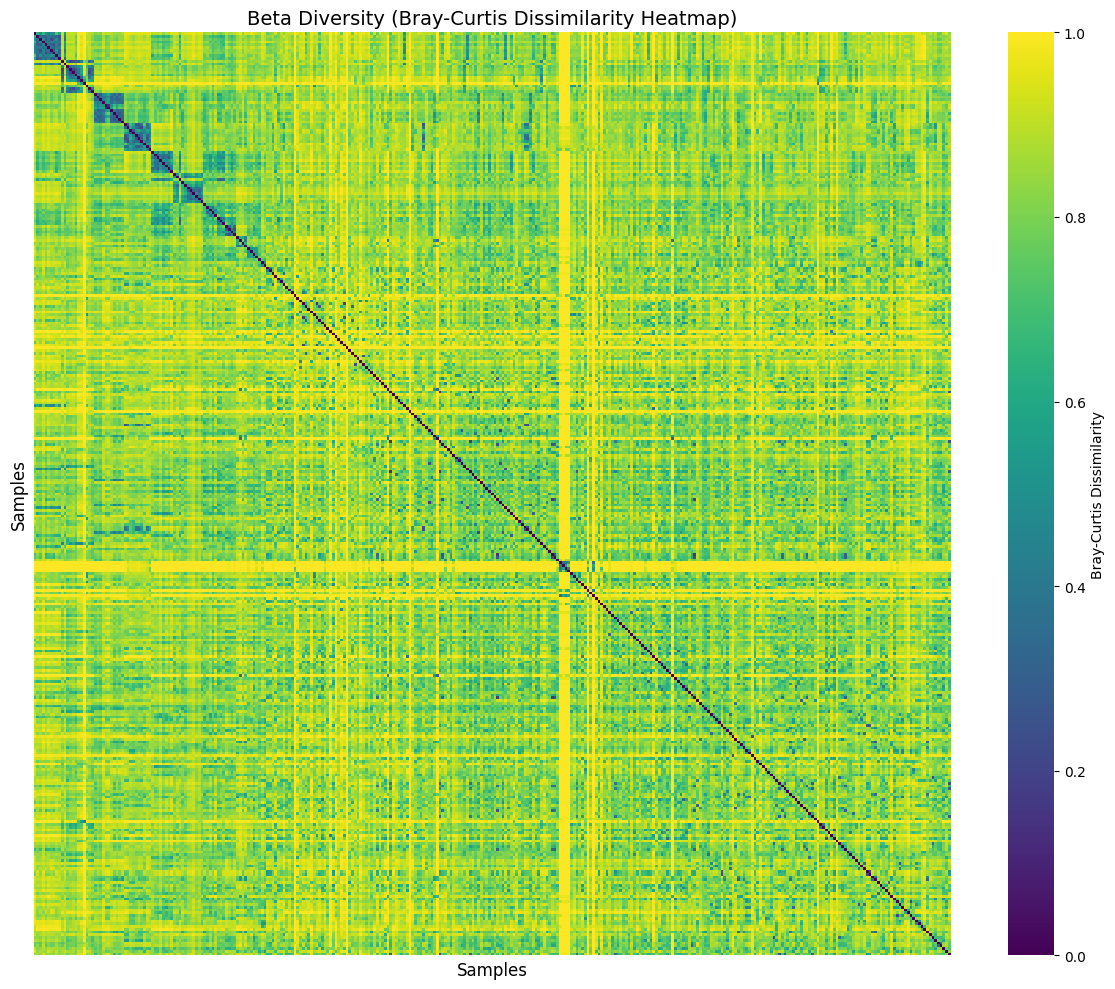

'global_resources/beta_diversity_heatmap.png'

In [90]:
# Create a heatmap for the Bray-Curtis Dissimilarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(bc_df, cmap='viridis', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Bray-Curtis Dissimilarity'})
plt.title("Beta Diversity (Bray-Curtis Dissimilarity Heatmap)", fontsize=14)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Samples", fontsize=12)
plt.tight_layout()
plt.show()

# Save the Bray-Curtis Dissimilarity Heatmap as an image file
plt.figure(figsize=(12, 10))
sns.heatmap(bc_df, cmap='viridis', xticklabels=False, yticklabels=False, cbar_kws={'label': 'Bray-Curtis Dissimilarity'})
plt.title("Beta Diversity (Bray-Curtis Dissimilarity Heatmap)", fontsize=14)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Samples", fontsize=12)
plt.tight_layout()

# Save the plot to a file
output_path = f'global_resources{os.sep}beta_diversity_heatmap.png'
plt.savefig(output_path, dpi=300)
plt.close()

output_path

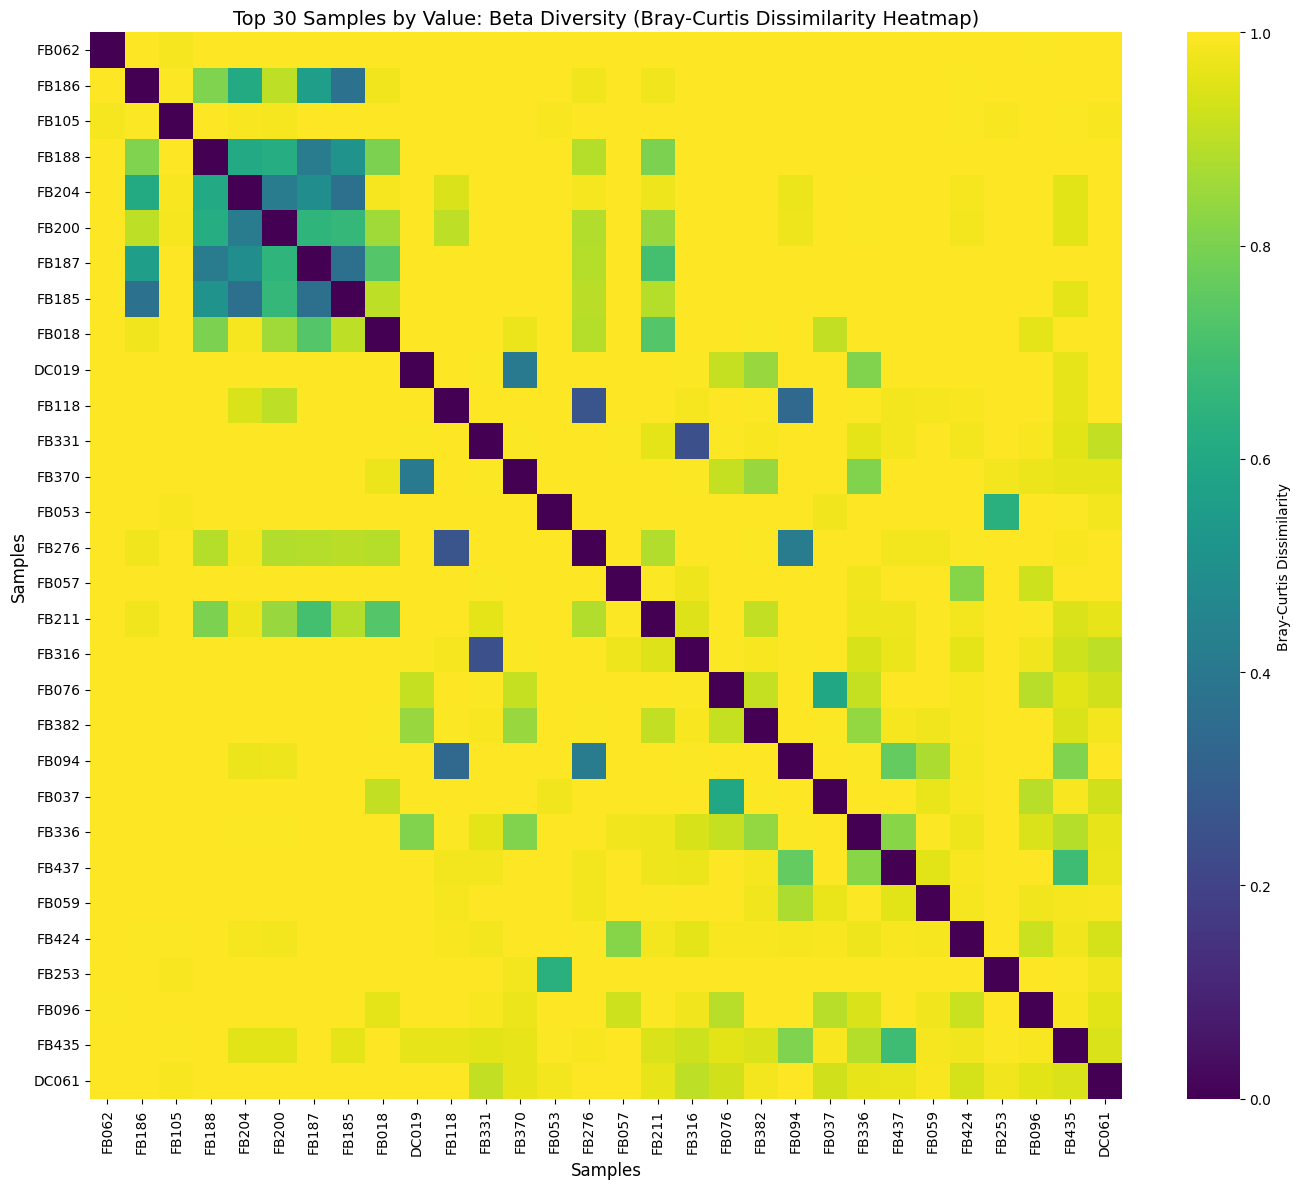

Heatmap saved to: global_resources/top_30_beta_diversity_heatmap.png


In [91]:
# Calculate aggregate scores (e.g., mean) for each sample
sample_scores = bc_df.mean(axis=1)  # Replace `.mean()` with `.sum()` or `.max()` if desired

# Select the top 30 samples by value
top_30_samples = sample_scores.nlargest(30).index

# Subset the matrix to include only the top 30 rows and columns
top_30_matrix = bc_df.loc[top_30_samples, top_30_samples]

# Create the heatmap for the top 30 samples
plt.figure(figsize=(14, 12))
sns.heatmap(
    top_30_matrix,
    cmap='viridis',
    xticklabels=True,
    yticklabels=True,
    cbar_kws={'label': 'Bray-Curtis Dissimilarity'}
)
plt.title("Top 30 Samples by Value: Beta Diversity (Bray-Curtis Dissimilarity Heatmap)", fontsize=14)
plt.xlabel("Samples", fontsize=12)
plt.ylabel("Samples", fontsize=12)
plt.tight_layout()
plt.show()

# Save the heatmap to a file
output_path = f'global_resources{os.sep}top_30_beta_diversity_heatmap.png'
plt.savefig(output_path, dpi=300)
plt.close()

print(f"Heatmap saved to: {output_path}")

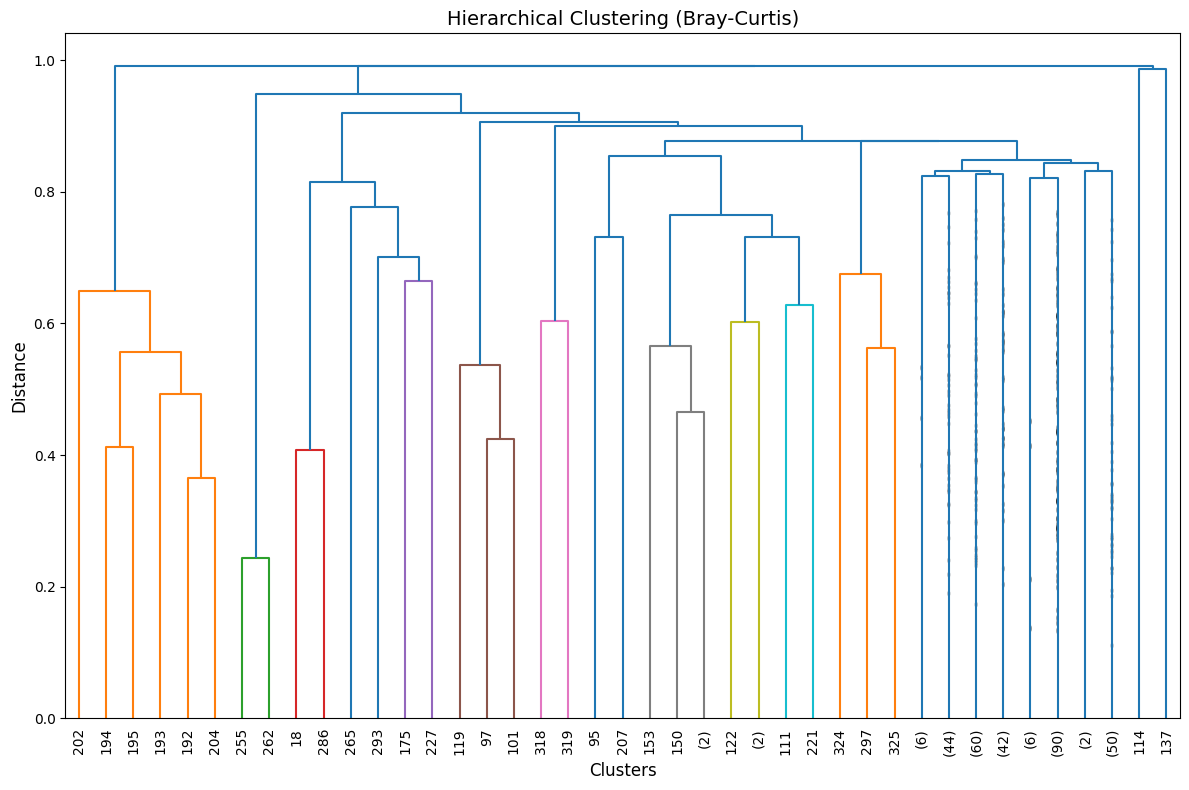

'global_resources/beta_diversity_hierarchical_clustering_dendrogram.png'

In [92]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

# Convert the square distance matrix to condensed format
condensed_dm = squareform(bc_df.values)

# Perform hierarchical clustering
linkage_matrix = linkage(condensed_dm, method='average')

# Plot the dendrogram with truncated labels
plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='level',  # Show only top-level clusters
    p=10,                   # Number of levels to show
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True    # Indicate where clusters are truncated
)
plt.title("Hierarchical Clustering (Bray-Curtis)", fontsize=14)
plt.xlabel("Clusters", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='level',  # Show only top-level clusters
    p=10,                   # Number of levels to show
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True    # Indicate where clusters are truncated
)
plt.title("Hierarchical Clustering (Bray-Curtis)", fontsize=14)
plt.xlabel("Clusters", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.tight_layout()

# Save the plot to a file
output_path = f'global_resources{os.sep}beta_diversity_hierarchical_clustering_dendrogram.png'
plt.savefig(output_path, dpi=300)
plt.close()

output_path

In [93]:
print(clinical_microbiome_tr.shape, clinical_microbiome_tr['Alzheimers'].value_counts())
clinical_microbiome_tr.head()

(244, 1050) 0.0    160
1.0     84
Name: Alzheimers, dtype: int64


,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,DC071,CH1-002,0.0,2016-07-15,93.0,3.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DC013,CH1-003,0.0,2016-07-12,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC019,CH1-003,18.0,2016-07-30,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DC014,CH1-003,20.0,2016-08-01,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DC015,CH1-003,23.0,2016-08-04,68.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# Splitting bc_df into hc (healthy control) and ad (Alzheimer's patients) DataFrames
hc_ids_tr = clinical_microbiome_tr[clinical_microbiome_tr['Alzheimers'] == 0.0]['Sample ID']
ad_ids_tr = clinical_microbiome_tr[clinical_microbiome_tr['Alzheimers'] == 1.0]['Sample ID']

# Creating bc_df_hc and bc_df_ad using the sample IDs from filtered_training_clinical_df
bc_df_hc_tr = bc_df_tr.loc[bc_df_tr.index.intersection(hc_ids_tr), bc_df_tr.columns.intersection(hc_ids_tr)]
bc_df_ad_tr = bc_df_tr.loc[bc_df_tr.index.intersection(ad_ids_tr), bc_df_tr.columns.intersection(ad_ids_tr)]

# Display the resulting DataFrames
bc_df_hc_tr.head()

,DC001,DC002,DC003,DC004,DC005,DC006,DC007,DC008,DC009,DC010,...,FB420,FB423,FB424,FB435,FB437,FB441,FB443,FB444,FB445,FB448
DC001,0.000000,0.643103,0.494985,0.668307,0.500148,0.444798,0.492854,0.497710,0.736109,0.596560,...,0.949207,0.944461,0.945960,0.905736,0.916550,0.846224,0.772637,0.775156,0.912875,0.831610
DC002,0.643103,0.000000,0.337175,0.316846,0.316432,0.396707,0.364480,0.363080,0.316974,0.258380,...,0.932380,0.827843,0.823680,0.976113,0.991377,0.838692,0.796514,0.839791,0.820395,0.869797
DC003,0.494985,0.337175,0.000000,0.473713,0.263922,0.398276,0.236307,0.326517,0.514070,0.312875,...,0.921492,0.893202,0.890574,0.966066,0.985123,0.816215,0.749373,0.765074,0.833680,0.836330
DC004,0.668307,0.316846,0.473713,0.000000,0.436897,0.362643,0.446416,0.425975,0.373689,0.397113,...,0.956191,0.861780,0.819597,0.987536,1.000000,0.878189,0.876250,0.901218,0.888483,0.926642
DC005,0.500148,0.316432,0.263922,0.436897,0.000000,0.391218,0.314184,0.240515,0.452632,0.301450,...,0.905362,0.910574,0.916637,0.970191,0.988475,0.815636,0.769026,0.747771,0.831408,0.844943


In [95]:
# Splitting bc_df into hc (healthy control) and ad (Alzheimer's patients) DataFrames
hc_ids_tt = clinical_microbiome_tt[clinical_microbiome_tt['Alzheimers'] == 0.0]['Sample ID']
ad_ids_tt = clinical_microbiome_tt[clinical_microbiome_tt['Alzheimers'] == 1.0]['Sample ID']

# Creating bc_df_hc and bc_df_ad using the sample IDs from filtered_training_clinical_df
bc_df_hc_tt = bc_df_tt.loc[bc_df_tt.index.intersection(hc_ids_tt), bc_df_tt.columns.intersection(hc_ids_tt)]
bc_df_ad_tt = bc_df_tt.loc[bc_df_tt.index.intersection(ad_ids_tt), bc_df_tt.columns.intersection(ad_ids_tt)]

# Display the resulting DataFrames
bc_df_hc_tt.head()

,DC026,DC030,DC056,FB034,FB097,FB106,FB111,FB113,FB124,FB128,FB137,FB180,FB301,FB308,FB438
DC026,0.000000,0.326442,0.657329,0.794801,0.781326,0.763914,0.760954,0.694376,0.802332,0.854632,0.764552,0.694290,0.640587,0.663165,0.668539
DC030,0.326442,0.000000,0.764761,0.895982,0.852784,0.807607,0.814183,0.836971,0.863712,0.851065,0.858666,0.785384,0.767872,0.751490,0.710503
DC056,0.657329,0.764761,0.000000,0.908644,0.822841,0.896613,0.879830,0.742187,0.871709,0.829841,0.746383,0.793120,0.687265,0.626281,0.809117
FB034,0.794801,0.895982,0.908644,0.000000,0.913796,0.870134,0.792139,0.808627,0.787910,0.923839,0.856596,0.794469,0.741924,0.866575,0.818682
FB097,0.781326,0.852784,0.822841,0.913796,0.000000,0.879869,0.906764,0.823669,0.889915,0.872894,0.348295,0.832689,0.861284,0.910143,0.916815


In [96]:
bacteria_df

,taxonomy_hierarchy,genus_name,species_name,species_description,feature_description_down_sized
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...,Faecalibacterium prausnitzii is a prominent me...
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Fusicatenibacter,Fusicatenibacter saccharivorans,**Description:** \nFusicatenibacter_sacchariv...,Fusicatenibacter_saccharivorans is a bacterium...
2,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Ruminococcaceae_unclassified,Eubacterium siraeum,**Description:** \nEubacterium siraeum is a b...,Eubacterium siraeum is a bacterium classified ...
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...,Gemmiger formicilis is a bacterium classified ...
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...,Eubacterium rectale is a prominent member of t...
...,...,...,...,...,...
935,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,Schaalia,Schaalia meyeri,**Description:** \nSchaalia meyeri is a bacte...,Schaalia meyeri is a bacterium classified unde...
936,k__Bacteria|p__Firmicutes|c__Firmicutes_unclas...,Ndongobacter,Ndongobacter massiliensis,**Description:** \nNdongobacter_massiliensis ...,k__Bacteria|p__Firmicutes|o__Firmutes_unclassi...
937,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,Actinomyces,Actinomyces radicidentis,**Description:** \nActinomyces radicidentis i...,Actinomyces radicidentis is a bacterium classi...
938,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|...,Candida,Candida tropicalis,**Description:** \nCandida tropicalis is a eu...,Candida tropicalis is a eukaryotic fungus belo...


In [97]:
def normalize_text(text):
    """Converts text to lowercase, retains periods, removes other punctuation, and normalizes spaces."""
    import re
    text = text.lower()
    # Remove punctuation except periods
    text = re.sub(r'[^\w\s.]', '', text)  # Retain periods
    return ' '.join(text.split())
# Print the top 1 record
print(normalize_text(bacteria_df['species_description'].iloc[0])) # Retrieve the first record
print("-----------")

# Print the top 2 record
print(normalize_text(bacteria_df['species_description'].iloc[1])) # Retrieve the second record
print("-----------")

# Print the top 2 record
print(normalize_text(bacteria_df['species_description'].iloc[800]))  # Retrieve the second record
print("-----------")

# Print the top 1 record
print(normalize_text(bacteria_df['species_description'].iloc[900]))  # Retrieve the first record
print("-----------")

# Print the top 1 record
print(normalize_text(bacteria_df['species_description'].iloc[912]))  # Retrieve the first record
print("-----------")

# Print the top 2 record
print(normalize_text(bacteria_df['species_description'].iloc[924]))  # Retrieve the second record

description faecalibacterium prausnitzii is a prominent member of the human gut microbiome classified under the phylum firmicutes class clostridia order clostridiales family ruminococcaceae and genus faecalibacterium. this bacterium is known for its significant role in producing butyrate a shortchain fatty acid that serves as an energy source for colonocytes and has antiinflammatory properties. decreased levels of f. prausnitzii have been associated with various gastrointestinal disorders and inflammatory conditions. in the context of alzheimers disease ad emerging evidence suggests that alterations in gut microbiota including reduced abundance of f. prausnitzii may influence neuroinflammation and cognitive decline. the bacteriums ability to modulate inflammation and produce metabolites that affect gutbrain communication highlights its potential relevance in ad pathology. furthermore f. prausnitziis presence is inversely correlated with cognitive impairment suggesting that maintaining 

In [98]:
len(filtered_mph_matching_df_t.columns.tolist())

940

In [99]:
data_dictionary=pd.read_csv(f"..{os.sep}data{os.sep}column_names.csv")
data_dictionary

,Column Names
0,Sample ID
1,study_id
2,day
3,Date Sample
4,age
...,...
1145,Ndongobacter massiliensis
1146,Actinomyces radicidentis
1147,Candida tropicalis
1148,Lachnospiraceae bacterium 10 1


In [100]:
clinical_dict_df = pd.read_excel(glob(f"..{os.sep}data{os.sep}*clinical_data_dictionary.xlsx")[0])
clinical_dict_df

,Feature Name,Feature Notes,Feature Description,Feature Group
0,ID Match,Identifier for patient or participant matching...,Identifier for patient or participant matching...,Study Identification
1,Sample ID,Unique Sample Identifier,Unique identifier for biological or clinical s...,Study Identification
2,Version 2,If there is a second metaphlan file,Version control for data entry or survey.,Study Identification
3,Version 3,If there is a third metaphlan file,Updated version for data entry or survey.,Study Identification
4,study_id,Unique ID number for each elder,Identifier for the specific study or research ...,Study Identification
...,...,...,...,...
112,Severe Liver disease,Each medical problem Y/N,Advanced liver disease diagnosis.,Hepatic Condition
113,ostomy,Each medical problem Y/N,Presence of an ostomy.,Surgical History
114,Alzheimers,Each medical problem Y/N,Diagnosis of Alzheimer's disease.,Neurological Condition
115,Dementia Other,Each medical problem Y/N,Other forms of dementia.,Neurological Condition


In [101]:
# Test the function
test_query = "what is alzheimer's disease"

results = query_vector_db(
    query_text=test_query,
    top_k=5,
    similarity_threshold=0.75
)
 
if results:
    print(f"\nMessage: {results.get('message')}")
    print("\nFull Context:")
    print(results.get('context', ''))


Message: Found 5 relevant context entries

Full Context:
Database: chroma_db1
Source: PMC8599320.xml
Content: will need to obtain permission directly from the copyright holder. to view a copy of this licence, visit http://creativecommons.org/licenses/by/4.0/. alzheimer's disease (ad) is a progressive neurodegenerative disorder of the central nervous system (cns) leading to mental deterioration and devastation, and eventually a fatal outcome. ad affects mostly the elderly. ad is frequently accompanied by hypercholesterolemia, hypertension, atherosclerosis, and diabetes mellitus, and these are significant risk factors of ad. other conditions triggered by the progression of ad include psychosis, sleep disorders, epilepsy, and depression. one important comorbidity is down’s syndrome, which directly contributes to the severity and rapid progression of ad. the development of new therapeutic strategies for ad includes the repurposing of drugs currently used for the treatment of comorbidities

In [102]:
clinical_dict_df[clinical_dict_df['Feature Name'].isin(selected_feature_names)]

,Feature Name,Feature Notes,Feature Description,Feature Group
12,age_cat,"categorized age (i.e. 1=65-74, 2=75-84, 3=85-9...",Age category or grouping for analysis.,Demographic Information
14,abx6mo,If they had an antibiotic exposure past 6 months,Use of antibiotics within the last 6 months.,Medication History
15,hopsn,How many times hospitalized in past year,Hospitalization status or related information.,Clinical Status
16,malnutrition_indicator_sco,Malnutrition Category (1-3 with 3 being malnou...,Score indicating malnutrition status.,Clinical Assessment
17,clinical_frailty_scale,Clinical Frailty Scale = Frailty into 9 catego...,Scale to measure clinical frailty.,Clinical Assessment
19,PPI,Each medication class Y/N,Use of proton pump inhibitors.,Medication History
21,Statins,Each medication class Y/N,Use of statin medications for cholesterol mana...,Medication History
23,cholinesterase inhibitors,Each medication class Y/N,Use of cholinesterase inhibitors for Alzheimer's.,Alzheimer's/Neurological Treatment
28,Beta blockers,Each medication class Y/N,Use of beta-adrenergic blocking agents.,Cardiovascular Medication
30,Beta-1 selective agents,Each medication class Y/N,Beta blockers for Beta-1 receptors.,Cardiovascular Medication


In [103]:
selected_bacteria_explanation_df = bacteria_df[bacteria_df['species_name'].isin(selected_feature_names)]
selected_bacteria_explanation_df

,taxonomy_hierarchy,genus_name,species_name,species_description,feature_description_down_sized
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...,Faecalibacterium prausnitzii is a prominent me...
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...,Gemmiger formicilis is a bacterium classified ...
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...,Eubacterium rectale is a prominent member of t...
5,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Phocaeicola,Phocaeicola vulgatus,**Description:** \nPhocaeicola vulgatus is a ...,Phocaeicola vulgatus is a bacterium classified...
12,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Alistipes,Alistipes onderdonkii,**Description:** \nAlistipes_onderdonkii is a...,"bacterium is part of the gut microbiome, where..."
13,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Ruminococcus,Ruminococcus bromii,**Description:** \nRuminococcus bromii is a s...,Ruminococcus bromii is a species of bacterium ...
14,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Barnesiella,Barnesiella intestinihominis,**Description:** \nBarnesiella intestinihomin...,Barnesiella intestinihominis is a bacterium cl...
18,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Bacteroides,Bacteroides uniformis,**Description:** \nBacteroides uniformis is a...,Bacteroides uniformis plays a significant role...
23,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Clostridium,Clostridium sp AF34 10BH,1) **Description**: Clostridium_sp_AF34_10BH i...,Clostridium_sp_AF34_10BH is a member of the Fi...
30,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Blautia,Blautia massiliensis,**Description:** \nBlautia massiliensis is a ...,Blautia massiliensis is a bacterium classified...


In [104]:
# clinical_variable_explanations_df.to_csv(f"..{os.sep}data{os.sep}clinical_variable_explanations_df.csv", index=False)
clinical_variable_explanations_df = pd.read_csv(f"..{os.sep}data{os.sep}clinical_variable_explanations_df.csv")
clinical_variable_explanations_df

,Feature Name,Feature Notes,Feature Group,Feature Description,Feature Explanation
0,ID Match,Identifier for patient or participant matching...,Study Identification,Identifier for patient or participant matching...,- **Feature Name:** ID Match\n\n - **Definiti...
1,Sample ID,Unique Sample Identifier,Study Identification,Unique identifier for biological or clinical s...,- **Feature Name:** Sample ID\n\n - **Definit...
2,Version 2,If there is a second metaphlan file,Study Identification,Version control for data entry or survey.,- **Feature Name:** Version 2\n\n - **Definit...
3,Version 3,If there is a third metaphlan file,Study Identification,Updated version for data entry or survey.,- **Feature Name:** Version 3\n\n - **Definit...
4,study_id,Unique ID number for each elder,Study Identification,Identifier for the specific study or research ...,- **Feature Name:** study_id\n\n - **Definiti...
...,...,...,...,...,...
112,Severe Liver disease,Each medical problem Y/N,Hepatic Condition,Advanced liver disease diagnosis.,- **Feature Name:** Severe Liver Disease\n\n ...
113,ostomy,Each medical problem Y/N,Surgical History,Presence of an ostomy.,- **Feature Name:** ostomy\n\n - **Definition...
114,Alzheimers,Each medical problem Y/N,Neurological Condition,Diagnosis of Alzheimer's disease.,- **Feature Name:** Alzheimers\n\n - **Defini...
115,Dementia Other,Each medical problem Y/N,Neurological Condition,Other forms of dementia.,- **Feature Name:** Dementia Other\n\n - **De...


In [105]:
selected_clinical_explanation_df = clinical_variable_explanations_df[clinical_variable_explanations_df['Feature Name'].isin(selected_feature_names)]
selected_clinical_explanation_df

,Feature Name,Feature Notes,Feature Group,Feature Description,Feature Explanation
12,age_cat,"categorized age (i.e. 1=65-74, 2=75-84, 3=85-9...",Demographic Information,Age category or grouping for analysis.,- **Feature Name:** age_cat\n\n - **Definitio...
14,abx6mo,If they had an antibiotic exposure past 6 months,Medication History,Use of antibiotics within the last 6 months.,- **Feature Name:** abx6mo\n\n - **Definition...
15,hopsn,How many times hospitalized in past year,Clinical Status,Hospitalization status or related information.,- **Feature Name:** hopsn\n\n - **Definition:...
16,malnutrition_indicator_sco,Malnutrition Category (1-3 with 3 being malnou...,Clinical Assessment,Score indicating malnutrition status.,- **Feature Name:** malnutrition_indicator_sco...
17,clinical_frailty_scale,Clinical Frailty Scale = Frailty into 9 catego...,Clinical Assessment,Scale to measure clinical frailty.,- **Feature Name:** clinical_frailty_scale\n\n...
19,PPI,Each medication class Y/N,Medication History,Use of proton pump inhibitors.,- **Feature Name:** PPI\n\n - **Definition:**...
21,Statins,Each medication class Y/N,Medication History,Use of statin medications for cholesterol mana...,- **Feature Name:** Statins\n\n - **Definitio...
23,cholinesterase inhibitors,Each medication class Y/N,Alzheimer's/Neurological Treatment,Use of cholinesterase inhibitors for Alzheimer's.,- **Feature Name:** cholinesterase inhibitors\...
28,Beta blockers,Each medication class Y/N,Cardiovascular Medication,Use of beta-adrenergic blocking agents.,- **Feature Name:** Beta blockers\n\n - **Def...
30,Beta-1 selective agents,Each medication class Y/N,Cardiovascular Medication,Beta blockers for Beta-1 receptors.,- **Feature Name:** Beta-1 selective agents\n\...


In [106]:
print(clinical_variable_explanations_df["Feature Explanation"][clinical_variable_explanations_df['Feature Name']=='malnutrition_indicator_sco'].values[0])

- **Feature Name:** malnutrition_indicator_sco

  - **Definition:** The malnutrition_indicator_sco is a score that categorizes the nutritional status of a participant into three levels, with 1 indicating well-nourished, 2 indicating at risk of malnutrition, and 3 indicating malnourished. This score is derived from clinical assessments that evaluate various aspects of nutrition, including dietary intake, weight loss, and physical health indicators.

  - **Group Characteristics:** This feature is part of a clinical assessment framework, where participants are evaluated based on their nutritional status. The categorization allows for differentiation between individuals who are well-nourished, those who may be at risk, and those who are malnourished. This stratification can be crucial for understanding the health status of participants in studies, particularly in older adults who are more susceptible to malnutrition.

  - **Relevance to Research:** Malnutrition is a significant concern in 

In [107]:
combined_force_plot_test_df

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Predicted Percentage,Predicted Status
0,FB106,CH1-118,age_cat,3.00000,-0.095609,0.027304,0
1,FB106,CH1-118,abx6mo,0.00000,0.000000,0.027304,0
2,FB106,CH1-118,hopsn,0.00000,0.000000,0.027304,0
3,FB106,CH1-118,malnutrition_indicator_sco,1.00000,-0.861395,0.027304,0
4,FB106,CH1-118,clinical_frailty_scale,6.00000,-0.691251,0.027304,0
...,...,...,...,...,...,...,...
2155,FB427,CH1BL-07,Longicatena caecimuris,0.02234,-0.035569,0.906744,1
2156,FB427,CH1BL-07,Clostridium scindens,1.15938,-0.040329,0.906744,1
2157,FB427,CH1BL-07,Ligilactobacillus salivarius,0.00000,0.000000,0.906744,1
2158,FB427,CH1BL-07,Akkermansia sp BIOML A40,0.00000,0.000000,0.906744,1


In [108]:
# Fix column selection to avoid duplicates
ml_prediction = combined_force_plot_test_df[['Sample ID', 'Study ID', 'Predicted Percentage', 'Predicted Status']].drop_duplicates()

# Map Predicted Status values
ml_prediction['Predicted Status'] = ml_prediction['Predicted Status'].map({0: 'No', 1: 'Yes'})

# Reset index for clean DataFrame
ml_prediction.reset_index(drop=True, inplace=True)

# Filter rows where Sample ID is 'FB411'
ml_prediction.head()

,Sample ID,Study ID,Predicted Percentage,Predicted Status
0,FB106,CH1-118,0.027304,No
1,FB128,CH1-107,0.715747,Yes
2,DC030,CH1-009,0.054324,No
3,FB124,CH1-107,0.525014,Yes
4,FB438,CH1-172,0.625515,Yes


In [109]:
ml_prediction[ml_prediction['Sample ID']=='FB246']

,Sample ID,Study ID,Predicted Percentage,Predicted Status


In [110]:
combined_force_plot_test_df['Absolute SHAP Value'] = abs(combined_force_plot_test_df['SHAP Value'])

# Sorting the DataFrame
combined_force_plot_test_d_sorted = combined_force_plot_test_df.sort_values(
    by=['Study ID', 'Sample ID', 'Absolute SHAP Value'],
    ascending=[True, True, False]
)
combined_force_plot_test_d_sorted

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Predicted Percentage,Predicted Status,Absolute SHAP Value
435,DC026,CH1-009,malnutrition_indicator_sco,1.00000,-1.593654,0.009486,0,1.593654
436,DC026,CH1-009,clinical_frailty_scale,5.00000,-0.517544,0.009486,0,0.517544
490,DC026,CH1-009,Phocaeicola dorei,0.00000,-0.437254,0.009486,0,0.437254
481,DC026,CH1-009,Neglecta timonensis,0.12635,-0.387763,0.009486,0,0.387763
437,DC026,CH1-009,PPI,0.00000,0.196428,0.009486,0,0.196428
...,...,...,...,...,...,...,...,...
2153,FB427,CH1BL-07,Massilimicrobiota sp An134,0.00000,0.000000,0.906744,1,0.000000
2154,FB427,CH1BL-07,Clostridium symbiosum,0.01475,0.000000,0.906744,1,0.000000
2157,FB427,CH1BL-07,Ligilactobacillus salivarius,0.00000,0.000000,0.906744,1,0.000000
2158,FB427,CH1BL-07,Akkermansia sp BIOML A40,0.00000,0.000000,0.906744,1,0.000000


In [111]:
combined_force_plot_test_d_sorted_no_zero = combined_force_plot_test_d_sorted[
    # (combined_force_plot_test_d_sorted["Sample ID"] == 'DC045') & 
    (combined_force_plot_test_d_sorted["Absolute SHAP Value"] > 0)
]
combined_force_plot_test_d_sorted_no_zero

,Sample ID,Study ID,Feature Name,Feature Value,SHAP Value,Predicted Percentage,Predicted Status,Absolute SHAP Value
435,DC026,CH1-009,malnutrition_indicator_sco,1.00000,-1.593654,0.009486,0,1.593654
436,DC026,CH1-009,clinical_frailty_scale,5.00000,-0.517544,0.009486,0,0.517544
490,DC026,CH1-009,Phocaeicola dorei,0.00000,-0.437254,0.009486,0,0.437254
481,DC026,CH1-009,Neglecta timonensis,0.12635,-0.387763,0.009486,0,0.387763
437,DC026,CH1-009,PPI,0.00000,0.196428,0.009486,0,0.196428
...,...,...,...,...,...,...,...,...
2108,FB427,CH1BL-07,Gemmiger formicilis,0.00000,-0.007823,0.906744,1,0.007823
2114,FB427,CH1BL-07,Bacteroides uniformis,0.03650,-0.007357,0.906744,1,0.007357
2149,FB427,CH1BL-07,Blautia producta,0.04725,-0.006864,0.906744,1,0.006864
2131,FB427,CH1BL-07,Pseudoruminococcus massiliensis,0.00000,0.004289,0.906744,1,0.004289


In [112]:
# Create a count table for the 'age' column
age_count_table = train_data['age'].value_counts().reset_index()

# Rename the columns for clarity
age_count_table.columns = ['Age', 'Count']
age_count_table.head()

,Age,Count
0,90.0,23
1,81.0,19
2,68.0,14
3,83.0,14
4,93.0,14


In [113]:
# Count occurrences grouped by 'age' and 'alzheimers'
age_ad_count_table = train_data.groupby(['age', 'Alzheimers']).size().reset_index(name='Count')
age_ad_count_table.columns = ['Age', 'Alzheimers', 'Count']
age_ad_count_table['Alzheimers'] = age_ad_count_table['Alzheimers'].map({0: 'No', 1: 'Yes'})
# Display the count table
age_ad_count_table.head()

,Age,Alzheimers,Count
0,52.0,No,4
1,53.0,No,4
2,68.0,No,10
3,68.0,Yes,4
4,69.0,No,4


In [114]:
# Count occurrences grouped by 'age' and 'alzheimers'
ad_count_table = train_data.groupby(['Alzheimers']).size().reset_index(name='Count')
ad_count_table.columns = ['Alzheimers', 'Count']
ad_count_table['Alzheimers'] = ad_count_table['Alzheimers'].map({0: 'No', 1: 'Yes'})
# Display the count table
ad_count_table

,Alzheimers,Count
0,No,160
1,Yes,84


In [115]:
bacteria_overlap = list(set(directional_shap_df['Feature'].tolist()) & set(bacteria_df["species_name"].str.replace("_", " ").tolist()))
bacteria_overlap[:10]

['Phocaeicola vulgatus',
 'GGB9694 SGB15204',
 'Bacteroides cellulosilyticus',
 'Gemmiger formicilis',
 'Blautia massiliensis',
 'Evtepia gabavorous',
 'Blautia caecimuris',
 'Akkermansia sp BIOML A40',
 'Catabacter hongkongensis',
 'Parasutterella excrementihominis']

In [116]:
# Assign "bacterial variable" or "clinical variable"
directional_shap_df["Variable_Type"] = directional_shap_df["Feature"].apply(
    lambda x: "bacterial" if x in bacteria_list else "clinical"
)

directional_shap_df

,Feature,Mean_SHAP,Mean_Abs_SHAP,Std_SHAP,Variable_Type
0,malnutrition_indicator_sco,-0.019997,0.867028,0.962787,clinical
1,PPI,0.078276,0.557513,0.608527,clinical
2,clinical_frailty_scale,-0.027717,0.527945,0.551478,clinical
3,Neglecta timonensis,-0.044137,0.524772,0.627134,bacterial
4,Phocaeicola dorei,-0.004032,0.485471,0.509211,bacterial
...,...,...,...,...,...
67,HTN,0.000000,0.000000,0.000000,clinical
68,Alistipes onderdonkii,0.000000,0.000000,0.000000,bacterial
69,Beta-1 selective agents,0.000000,0.000000,0.000000,clinical
70,Diuretics,0.000000,0.000000,0.000000,clinical


In [117]:
# bacteria_overlap, clinical_overlap
clinical_overlap = directional_shap_df['Feature'][directional_shap_df['Variable_Type']=="clinical"].tolist() 
features_remain_in_model = clinical_overlap + bacteria_overlap
features_remain_in_model[:10]

['malnutrition_indicator_sco',
 'PPI',
 'clinical_frailty_scale',
 'cholinesterase inhibitors',
 'age_cat',
 'Probiotics',
 'Beta blockers',
 'Dopamine Promoters',
 'High Cholesterol',
 'Vasodilators']

In [118]:
base_model = "gpt-4o-mini-2024-07-18"
base_model_4o = "gpt-4o-2024-11-20"

In [119]:
import tiktoken

def count_tokens_in_message(message, model=base_model):
    import tiktoken

    # Ensure the message is a string (e.g., extract "content" if it's a dictionary)
    if isinstance(message, dict):
        message = message.get("content", "")
    
    # Load the tokenizer for the specified model
    encoding = tiktoken.encoding_for_model(model)
    
    # Tokenize the message content and return the token count
    return len(encoding.encode(message))

In [120]:
# Calculate the ratio
no_count = ad_count_table['Count'][ad_count_table['Alzheimers'] == 'No'].values[0]
yes_count = ad_count_table['Count'][ad_count_table['Alzheimers'] == 'Yes'].values[0]

# Simplify the ratio to its smallest terms
from math import gcd

def calculate_ratio(x, y):
    factor = gcd(x, y)
    return x // factor, y // factor

ratio_no_to_yes = calculate_ratio(no_count, yes_count)

# Display the ratio in '1:x' format
hc_ad_ratio = f"{ratio_no_to_yes[0]}:{ratio_no_to_yes[1]}"
print("Ratio (No:Yes):", hc_ad_ratio)

Ratio (No:Yes): 40:21


In [121]:
base_model

'gpt-4o-mini-2024-07-18'

In [122]:
import pandas as pd
from tqdm import tqdm
from openai import OpenAI

# Initialize OpenAI client (assumes OPENAI_API_KEY is set)
client = OpenAI()

def get_completion(messages, model, seed=None, temperature=0.0, top_p=0.9):
    """Generate GPT completion from given messages using the specified model."""
    try:
        print(f"Using model: {model} ...")
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            seed=seed,
            temperature=temperature,
            top_p=top_p
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error: {e}")
        return None

def summarize_columns_to_name(row, train_df, ad_df, bc_df, bc_df_hc, bc_df_ad, clinical_dict, bacteria_dict, model, dataset_type="train"):
    """
    Summarizes a single row's clinical and microbiome data into a clear, standardized narrative.
    This agent focuses solely on descriptive summarization using probabilistic language and critical interpretation.
    It also analyzes machine learning (ML) predictions and SHAP analysis, while noting that such predictions may be imperfect.
    """
    print(f"Processing dataset type: {dataset_type}...")
    
    sample_id = row['Sample ID']
    study_id = row['study_id']
    
    # Set Alzheimer's status based on dataset type
    if dataset_type in ["train", "valid"]:
        ad_status = 'No' if row['Alzheimers'] == 0.0 else 'Yes'
    else:
        ad_status = "Unknown"
        row['Alzheimers'] = "Unknown"
    
    # Retrieve diversity metrics (assuming global DataFrames are defined)
    alpha_diversity = combined_alpha_div_df[combined_alpha_div_df["Sample ID"] == sample_id]
    beta_div_bray = all_beta_div_results[0].loc[all_beta_div_results[0].index.intersection([sample_id])]
    beta_div_jaccard = all_beta_div_results[1].loc[all_beta_div_results[1].index.intersection([sample_id])]
    beta_div_canberra = all_beta_div_results[2].loc[all_beta_div_results[2].index.intersection([sample_id])]

    # Define malnutrition categories
    malnutrition_categories = {
        1: "Well-Nourished: Adequate nutrition supports brain health and microbiome balance.",
        2: "At Risk of Malnutrition: Early nutritional deficiencies may exacerbate cognitive decline.",
        3: "Malnourished: Severe deficiencies accelerate neurodegeneration via inflammation and gut-brain axis impairment."
    }

    # Overall diversity methods
    alpha_measures = ['shannon', 'simpson', 'berger_parker_d']
    beta_measures = ["braycurtis", "jaccard", "canberra"]

    # Build clinical and microbiome summaries with exclusions (assuming clinical_dict_df and bacteria_dict are DataFrames)
    exclude_cols = ["Alzheimers"]
    
    # Create the clinical data string using the row Series
    clinical_data = "\n".join(
        f"{feature}: {row[feature]}" 
        for feature in clinical_dict_df['Feature Name'].tolist()
        if feature not in exclude_cols and feature in row.index
    )
    
    # Create the microbiome data string
    microbiome_data = "\n".join(
        f"{species}: {row[species]}" 
        for species in bacteria_dict['species_name'].tolist()
        if species not in exclude_cols and species in row.index
    )

    # Final combined overview with diversity metrics
    patient_overview = f"Clinical Data:\n{clinical_data}\n\nGut Microbiome Data:\n{microbiome_data}"
    patient_overview += f"\n\nAlpha Diversity (methods: {alpha_measures}): {alpha_diversity.to_dict()}"
    patient_overview += f"\nBeta Diversity (methods: {beta_measures}): Bray-Curtis {beta_div_bray.to_dict()}, Jaccard {beta_div_jaccard.to_dict()}, Canberra {beta_div_canberra.to_dict()}"

    # Standard token thresholds
    token_threshold_1 = 8000
    token_threshold_2 = 16000

    # --- Construct standardized step texts with enhanced interpretation instructions ---
    step1_text = (
        f"Step 1: Patient Overview\n"
        f"Sample ID: {sample_id}\nPatient ID: {study_id}\nVisit Day: {row.get('day', 'N/A')}\n"
        f"Clinical Details:\n{patient_overview}\n"
        "Provide a clear description of the patient's demographic and clinical background."
    )

    # Step 2: Emphasize numerical values and potential impact
    step2_text = (
        "Step 2: Key Clinical Markers\n"
        f"Based on {clinical_data}, identify and describe important clinical markers along with their numeric values (e.g., Malnutrition Score, Frailty Scale, Hospitalizations). "
        "Discuss how these numbers influence the probability of Alzheimer's disease, drawing on historical data and clinical knowledge. "
        "For instance, a Malnutrition Score of 2 (At Risk) and a Clinical Frailty Scale of 7 may elevate the Alzheimer's probability."
    )

    # Step 3: Emphasize bacterial abundance and potential impact
    step3_text = (
        f"Step 3: Gut Microbiome Profile\n"
        f"Based on {microbiome_data}, List and interpret the key bacterial species identified as relevant (e.g., {bacteria_found if 'bacteria_found' in globals() else 'N/A'}). "
        "Include the relative abundance values for each species and discuss their potential impact on Alzheimer's probability. "
        "For example, higher abundance of species associated with inflammation may increase the probability, while those linked to gut health may be protective."
    )

    step4_text = (
        f"Step 4: Diversity Metrics Analysis\n"
        f"Evaluate alpha diversity (using methods: {alpha_measures}) and beta diversity (using methods: {beta_measures}) "
        "to assess the balance of the gut microbial community. Describe what these diversity metrics imply about overall gut health."
    )

    step5_text = (
        "Step 5: Interactions and Mechanisms\n"
        "Discuss potential interactions between clinical markers and gut microbiome features. "
        "Explain mechanisms (e.g., gut-brain axis, cytokine release, metabolite production) through which these interactions might affect cognitive function."
    )

    step6_text = (
        "Step 6: Descriptive Correlation\n"
        "Integrate clinical, microbiome, and diversity data to describe overall trends. "
        "Use probabilistic language to express how these factors may collectively influence Alzheimer's disease probability, without making definitive classifications."
    )

    # Prepare data for longitudinal analysis
    individual_study_data = test_data_no_normal[test_data_no_normal['study_id'] == study_id].drop(columns=["Alzheimers"])
    individual_sample_data = test_data_no_normal[test_data_no_normal['Sample ID'] == sample_id].drop(columns=["Alzheimers"])

    def longitudinal_prompt(study_data, sample_data, sample_id, study_id):
        cognitive_features = ['Atypical Antipsychotics', 'cholinesterase inhibitors', 'Parkinsons', 'SSRIs', 'clinical_frailty_scale']
        if len(sample_data) > 1:
            return (
                f"Longitudinal Analysis:\nMultiple records ({len(sample_data)}) exist for Patient {study_id} (Sample ID: {sample_id}). "
                f"Current Visit Day: {row.get('day', 'N/A')}. Visit Days: {study_data['day'].tolist()}.\n"
                f"Current Visit Data: {sample_data.to_json(orient='records')}\n"
                f"Historical Data: {study_data.to_json(orient='records')}\n"
                "Focus on trends in cognitive-related features: "
                f"{study_data[['Sample ID','study_id'] + cognitive_features].to_json(orient='records')}\n"
            )
        else:
            return (
                f"First-Time Visit Analysis:\nOnly one record exists for Patient {study_id} (Sample ID: {sample_id}). "
                f"Visit Day: {sample_data['day'].to_json(orient='records')}\n"
                f"Data: {sample_data.to_json(orient='records')}\n"
                "Establish this as the baseline for future comparisons.\n"
            )

    # Retrieve SHAP data for context (assumes combined_force_plot_test_d_sorted is defined)
    shap_sample_data = combined_force_plot_test_d_sorted[
        ["Sample ID", "Study ID", "Feature Name", "SHAP Value", "Absolute SHAP Value"]
    ][combined_force_plot_test_d_sorted["Sample ID"] == sample_id]
    shap_global_data = (directional_important_shap_df_sort.to_json(orient='records')
                        if 'directional_important_shap_df_sort' in globals() else "N/A")

    # Step 7: ML Analysis and SHAP Assessment with Probabilistic Language
    ml_prob = ml_prediction['Predicted Percentage'][ml_prediction['Sample ID'] == sample_id].iloc[0]
    step7_text = (
        "Step 7: Machine Learning Analysis and Probabilistic Assessment\n"
        f"ML Prediction: The model indicates a {ml_prob*100}% probability for Alzheimer's classification. "
        "Note: ML predictions are derived from historical data and may contain errors; they should be interpreted with caution.\n\n"
        "SHAP Analysis:\n"
        " - SHAP values explain the contribution of each feature to the model's prediction.\n"
        f" - SHAP Data for Sample: {shap_sample_data.to_json(orient='records')}\n"
        f" - Global SHAP Summary: {shap_global_data}\n\n"
        f"{longitudinal_prompt(individual_study_data, individual_sample_data, sample_id, study_id)}\n"
        "Discuss how the ML prediction, together with the detailed SHAP analysis, integrates with the clinical and microbiome evidence. "
        "Highlight any discrepancies or uncertainties in the data interpretation."
    )

    step8_text = (
        "Step 8: Final Comprehensive Descriptive Summary\n"
        "Integrate all findings—from clinical data, gut microbiome profiles, diversity metrics, and ML/SHAP analysis—into a clear, standardized narrative. "
        "Use probabilistic language to express the overall probability of Alzheimer's disease, taking into account potential ML prediction errors. "
        "Provide a critical interpretation of how the various data points interact, and emphasize the need for expert review to refine these insights."
    )

    # Compile all step texts into a list and get RAG context for each step
    step_texts = [step1_text, step2_text, step3_text, step4_text, step5_text, step6_text, step7_text, step8_text]
    rag_results = {}
    similarity_threshold = 0.7
    top_k = 5
    for i, text in enumerate(step_texts, start=1):
        print(f"Processing RAG for Step {i} ...")
        current_top_k = 10 if i == len(step_texts) else top_k
        rag_results[f"step{i}_rag"] = rag_model(test_query=text, top_k=current_top_k, similarity=similarity_threshold)
    
    # Prepare the user message content in standardized format
    user_message_content = (
        "**Standardized Descriptive Summary of Clinical and Microbiome Data**\n\n"
        f"Clinical Data Dictionary: {clinical_dict}\n"
        f"Bacteria Data Dictionary: {bacteria_dict}\n\n"
        "This summarization agent produces a clear, logical narrative using probabilistic language to describe the subject's Alzheimer's disease probability. "
        "A subsequent classification agent will perform binary classification based on this description.\n\n"
    )
    for i, step_text in enumerate(step_texts, start=1):
        user_message_content += f"{step_text}\nExplanation Context: {rag_results[f'step{i}_rag']}\n\n"
    
    user_message = {"role": "user", "content": user_message_content}
    
    # Prepare the system message ensuring all placeholders are resolved and 'risk' is replaced by 'probability'
    system_message = {
        "role": "system",
        "content": (
            "**Role:** Summarization and Learning Agent\n"
            "**Purpose:** Generate a clear and logical diagnostic summary for Alzheimer's disease using clinical, microbiome, and computational data. "
            "This agent focuses solely on descriptive summarization using probabilistic language; binary classification will be performed later.\n\n"
            f"Study Subjects in Training:\n- Healthy Controls: {hc_ids_tr if 'hc_ids_tr' in globals() else 'N/A'}\n"
            f"- Alzheimer's Patients: {ad_ids_tr if 'ad_ids_tr' in globals() else 'N/A'}\n\n"
            "**Scope and Focus:**\n"
            "- Integrate species-level microbiome data, clinical variables, SHAP analysis, and diversity metrics into a unified descriptive summary.\n"
            "- Emphasize clarity, logical structure, and probabilistic descriptions of Alzheimer's disease probability, while considering potential ML prediction errors.\n\n"
            "**Expectations:**\n"
            "- Use SHAP values to describe the influence of key features with associated numbers.\n"
            f"- Malnutrition Categories: {malnutrition_categories}\n"
            "- Incorporate historical data to enhance context and adjust for potential ML prediction mistakes.\n"
            "**Output Guidelines:**\n"
            "- Produce a structured, step-by-step narrative summarizing all data sources in a standardized format.\n"
            "- Focus on clear, logical explanations that reveal data interpretation and avoid definitive categorical assignments."
        )
    }
    
    messages = [system_message, user_message]

    # Optional: Token counting (if function is available)
    token_count_system = count_tokens_in_message(system_message) if 'count_tokens_in_message' in globals() else None
    token_count_user = count_tokens_in_message(user_message) if 'count_tokens_in_message' in globals() else None
    if token_count_system is not None and token_count_user is not None:
        total_tokens = token_count_system + token_count_user
        print(f"Total token count: {total_tokens}")
    
    # Generate the final descriptive summary using the base model (base_model must be defined)
    final_response = get_completion(messages, model)
    return final_response

def summarization_agent(dataset_type, test_df, train_df, ad_df, bc_df, bc_df_hc, bc_df_ad, clinical_dict, bacteria_dict, model, top_summ=5, seed=None):
    """
    Processes the specified dataset and generates standardized, clear summaries for each sample.
    The output describes the study subject's Alzheimer's disease probability using probabilistic language,
    and analyzes ML predictions with caution.
    """
    print(f"Processing {dataset_type} dataset...")
    results = []
    
    # Shuffle dataset (for train/validation; test assumed already shuffled)
    shuffle_df = test_df.sample(n=min(len(test_df), top_summ), random_state=seed)
    
    for _, row in tqdm(shuffle_df.iterrows(), total=len(shuffle_df), desc=f"Generating summaries for {dataset_type}"):
        sample_id = row["Sample ID"]
        ad_status = 'Yes' if row['Alzheimers'] == 1.0 else 'No'
        
        summary_text = summarize_columns_to_name(
            row=row,
            train_df=train_df,
            ad_df=ad_df,
            bc_df=bc_df,
            bc_df_hc=bc_df_hc,
            bc_df_ad=bc_df_ad,
            clinical_dict=clinical_dict,
            bacteria_dict=bacteria_dict,
            model=model,
            dataset_type=dataset_type
        )
        
        results.append({
            'Dataset': dataset_type,
            'Sample ID': sample_id,
            'Alzheimers': ad_status,
            'Summary': summary_text.strip(),
            'Formatted Summary': summary_text
        })
    
    dataset_result_df = pd.DataFrame(results)
    print(f"{dataset_type.capitalize()} dataset summaries generated.")
    return dataset_result_df

In [123]:
ml_prediction

,Sample ID,Study ID,Predicted Percentage,Predicted Status
0,FB106,CH1-118,0.027304,No
1,FB128,CH1-107,0.715747,Yes
2,DC030,CH1-009,0.054324,No
3,FB124,CH1-107,0.525014,Yes
4,FB438,CH1-172,0.625515,Yes
5,FB137,CH1-119,0.150152,No
6,DC026,CH1-009,0.009486,No
7,FB111,CH1-118,0.020607,No
8,FB097,CH1-119,0.098815,No
9,DC056,CH1-011,0.008392,No


In [124]:
# Convert both columns to sets for comparison
train_sample_ids = set(train_data['Sample ID'])
test_sample_ids = set(test_data["Sample ID"])

# Find the overlap
overlap = train_sample_ids.intersection(test_sample_ids)

# Display the result
if overlap:
    print(f"Overlap found: {len(overlap)} matching Sample IDs.")
    print("Matching Sample IDs:", overlap)
else:
    print("No overlap Sample IDs found between full train_results and test_results.")

# Convert both columns to sets for comparison
train_study_ids = set(train_data['study_id'])
test_study_ids = set(test_data["study_id"])

# Find the overlap
overlap = train_study_ids.intersection(test_study_ids)

# Display the result
if overlap:
    print(f"Overlap found: {len(overlap)} matching Study IDs.")
    print("Matching Study IDs:", overlap)
else:
    print("No overlap Study IDs found between full train_results and test_results.")

No overlap Sample IDs found between full train_results and test_results.
No overlap Study IDs found between full train_results and test_results.


In [125]:
bacteria_df

,taxonomy_hierarchy,genus_name,species_name,species_description,feature_description_down_sized
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...,Faecalibacterium prausnitzii is a prominent me...
1,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Fusicatenibacter,Fusicatenibacter saccharivorans,**Description:** \nFusicatenibacter_sacchariv...,Fusicatenibacter_saccharivorans is a bacterium...
2,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Ruminococcaceae_unclassified,Eubacterium siraeum,**Description:** \nEubacterium siraeum is a b...,Eubacterium siraeum is a bacterium classified ...
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...,Gemmiger formicilis is a bacterium classified ...
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...,Eubacterium rectale is a prominent member of t...
...,...,...,...,...,...
935,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,Schaalia,Schaalia meyeri,**Description:** \nSchaalia meyeri is a bacte...,Schaalia meyeri is a bacterium classified unde...
936,k__Bacteria|p__Firmicutes|c__Firmicutes_unclas...,Ndongobacter,Ndongobacter massiliensis,**Description:** \nNdongobacter_massiliensis ...,k__Bacteria|p__Firmicutes|o__Firmutes_unclassi...
937,k__Bacteria|p__Actinobacteria|c__Actinobacteri...,Actinomyces,Actinomyces radicidentis,**Description:** \nActinomyces radicidentis i...,Actinomyces radicidentis is a bacterium classi...
938,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|...,Candida,Candida tropicalis,**Description:** \nCandida tropicalis is a eu...,Candida tropicalis is a eukaryotic fungus belo...


In [126]:
bacteria_dict = pd.read_csv(f"..{os.sep}data{os.sep}bacteria_df.csv")
print(bacteria_df.shape)

filtered_bacteria_df = bacteria_df[bacteria_df["species_name"].isin(bacteria_overlap)]#.isin([item.replace(" ", "_") for item in bacteria_overlap])]
filtered_bacteria_df.shape

(940, 5)


(53, 5)

In [127]:
filtered_bacteria_df.head()

,taxonomy_hierarchy,genus_name,species_name,species_description,feature_description_down_sized
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...,Faecalibacterium prausnitzii is a prominent me...
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...,Gemmiger formicilis is a bacterium classified ...
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...,Eubacterium rectale is a prominent member of t...
5,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Phocaeicola,Phocaeicola vulgatus,**Description:** \nPhocaeicola vulgatus is a ...,Phocaeicola vulgatus is a bacterium classified...
12,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Alistipes,Alistipes onderdonkii,**Description:** \nAlistipes_onderdonkii is a...,"bacterium is part of the gut microbiome, where..."


In [128]:
# First, make an explicit copy of the filtered DataFrame
filtered_bacteria_df = filtered_bacteria_df.copy()

# Now extract genus name
filtered_bacteria_df['genus_name'] = filtered_bacteria_df['taxonomy_hierarchy'].apply(
    lambda x: x.split('|')[-2].split('__')[-1]
)

# Rename the "summary" column to "species_description"
filtered_bacteria_df = filtered_bacteria_df.rename(columns={"summary": "species_description"})

# Rearrange columns
filtered_bacteria_df = filtered_bacteria_df[['taxonomy_hierarchy', 'genus_name', 'species_name', 'species_description']]
filtered_bacteria_df.head()

,taxonomy_hierarchy,genus_name,species_name,species_description
0,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Faecalibacterium,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...
3,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Gemmiger,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...
4,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,Lachnospiraceae_unclassified,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...
5,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Phocaeicola,Phocaeicola vulgatus,**Description:** \nPhocaeicola vulgatus is a ...
12,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o_...,Alistipes,Alistipes onderdonkii,**Description:** \nAlistipes_onderdonkii is a...


In [129]:
filtered_bacteria_df.head()['taxonomy_hierarchy'].tolist()[0]

'k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii'

In [130]:
filtered_clinical_dict_df = clinical_variable_explanations_df[clinical_variable_explanations_df["Feature Name"].isin(directional_shap_df['Feature'][directional_shap_df['Variable_Type']=="clinical"].tolist())]
filtered_clinical_dict_df

,Feature Name,Feature Notes,Feature Group,Feature Description,Feature Explanation
12,age_cat,"categorized age (i.e. 1=65-74, 2=75-84, 3=85-9...",Demographic Information,Age category or grouping for analysis.,- **Feature Name:** age_cat\n\n - **Definitio...
14,abx6mo,If they had an antibiotic exposure past 6 months,Medication History,Use of antibiotics within the last 6 months.,- **Feature Name:** abx6mo\n\n - **Definition...
15,hopsn,How many times hospitalized in past year,Clinical Status,Hospitalization status or related information.,- **Feature Name:** hopsn\n\n - **Definition:...
16,malnutrition_indicator_sco,Malnutrition Category (1-3 with 3 being malnou...,Clinical Assessment,Score indicating malnutrition status.,- **Feature Name:** malnutrition_indicator_sco...
17,clinical_frailty_scale,Clinical Frailty Scale = Frailty into 9 catego...,Clinical Assessment,Scale to measure clinical frailty.,- **Feature Name:** clinical_frailty_scale\n\n...
19,PPI,Each medication class Y/N,Medication History,Use of proton pump inhibitors.,- **Feature Name:** PPI\n\n - **Definition:**...
21,Statins,Each medication class Y/N,Medication History,Use of statin medications for cholesterol mana...,- **Feature Name:** Statins\n\n - **Definitio...
23,cholinesterase inhibitors,Each medication class Y/N,Alzheimer's/Neurological Treatment,Use of cholinesterase inhibitors for Alzheimer's.,- **Feature Name:** cholinesterase inhibitors\...
28,Beta blockers,Each medication class Y/N,Cardiovascular Medication,Use of beta-adrenergic blocking agents.,- **Feature Name:** Beta blockers\n\n - **Def...
30,Beta-1 selective agents,Each medication class Y/N,Cardiovascular Medication,Beta blockers for Beta-1 receptors.,- **Feature Name:** Beta-1 selective agents\n\...


In [131]:
clinical_microbiome_df.malnutrition_indicator_sco.value_counts()

2.0    150
1.0    128
3.0     57
Name: malnutrition_indicator_sco, dtype: int64

In [132]:
clinical_dict_df['Feature Name'].tolist()[:5]

['ID Match', 'Sample ID', 'Version 2', 'Version 3', 'study_id']

In [133]:
bacteria_dict['species_name'].tolist()[:5]

['Faecalibacterium prausnitzii',
 'Fusicatenibacter saccharivorans',
 'Eubacterium siraeum',
 'Gemmiger formicilis',
 'Eubacterium rectale']

In [134]:
clinical_microbiome_tt

,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,FB106,CH1-118,0.0,2017-09-18,91.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FB128,CH1-107,106.0,2017-11-03,81.0,2.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DC030,CH1-009,18.0,2016-08-18,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FB124,CH1-107,67.0,2017-09-25,81.0,2.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FB438,CH1-172,286.0,2019-03-28,90.0,3.0,0.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,FB137,CH1-119,29.0,2017-10-17,84.0,2.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,DC026,CH1-009,6.0,2016-08-06,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,FB111,CH1-118,29.0,2017-10-17,91.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,FB097,CH1-119,0.0,2017-09-18,84.0,2.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,DC056,CH1-011,59.0,2016-09-10,89.0,3.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
base_model, base_model_4o

('gpt-4o-mini-2024-07-18', 'gpt-4o-2024-11-20')

In [136]:
ad_df

,Sample ID,Alpha Diversity (Shannon Index)
0,DC001,2.519907
1,DC002,3.451174
2,DC003,3.385870
3,DC004,2.834624
4,DC005,3.290396
...,...,...
330,FB443,3.560865
331,FB444,3.401113
332,FB445,3.300568
333,FB446,3.303342


In [137]:
# Construct the path directly instead of using glob
summarization_output_path = f"local_resources{os.sep}experiment{experiment_number:02d}{os.sep}summarization{os.sep}"

# Create directory if it doesn't exist (exist_ok=True handles both cases)
os.makedirs(summarization_output_path, exist_ok=True)

# Construct output file path
summarization_output_file_path = os.path.join(summarization_output_path, f"summarization_agent_output_{base_model_4o}.csv")

# Check if file exists
if os.path.isfile(summarization_output_file_path):
   # If file exists, just read it
   test_df = pd.read_csv(summarization_output_file_path)
   print(f"Loading existing file from: {summarization_output_file_path}")
else:
   # If file doesn't exist, run the summarization agent and save results
   print("File not found. Running summarization agent...")
   data_feed = clinical_microbiome_tt # [clinical_microbiome_tt['Sample ID']=='FB246']
   # hc_ids_tr, ad_ids_tr, ad_df_tr, bc_df_tr, bc_df_hc_tr, bc_df_ad_tr
   test_df = summarization_agent(
       dataset_type="test",
       test_df=data_feed,
       train_df=None, # ADAM 2.0 will involve train_df in LLM.
       ad_df=None, # ADAM 2.0 will involve ad_df_tr,
       bc_df=None, # ADAM 2.0 will involve bc_df_tr,
       bc_df_hc=None, # ADAM 2.0 will involve bc_df_hc_tr,
       bc_df_ad=None, # ADAM 2.0 will involve bc_df_ad_tr,
       clinical_dict=filtered_clinical_dict_df,
       bacteria_dict=filtered_bacteria_df,
       model=base_model_4o,
       top_summ=data_feed.shape[0],
       seed=seed
   )
   # Create directory if it doesn't exist
   os.makedirs(summarization_output_path, exist_ok=True)
   # Save the file
   test_df.to_csv(summarization_output_file_path, index=False)
   print(f"File saved to: {summarization_output_file_path}")

test_df.head()

File not found. Running summarization agent...
Processing test dataset...


Generating summaries for test:   0%|          | 0/30 [00:00<?, ?it/s]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72128
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:   3%|▎         | 1/30 [00:42<20:21, 42.12s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 73378
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:   7%|▋         | 2/30 [01:30<21:18, 45.66s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 73432
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  10%|█         | 3/30 [02:22<21:54, 48.70s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72259
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  13%|█▎        | 4/30 [03:11<21:12, 48.94s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72965
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  17%|█▋        | 5/30 [04:01<20:26, 49.07s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 73213
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  20%|██        | 6/30 [04:54<20:12, 50.53s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 73042
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  23%|██▎       | 7/30 [05:41<18:53, 49.28s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 74168
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  27%|██▋       | 8/30 [06:30<18:06, 49.39s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72684
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  30%|███       | 9/30 [07:21<17:22, 49.64s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72631
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  33%|███▎      | 10/30 [08:18<17:17, 51.89s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72849
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  37%|███▋      | 11/30 [09:03<15:50, 50.04s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 73189
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  40%|████      | 12/30 [09:45<14:14, 47.49s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72685
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  43%|████▎     | 13/30 [10:32<13:25, 47.41s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72272
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  47%|████▋     | 14/30 [11:22<12:48, 48.03s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71502
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  50%|█████     | 15/30 [12:04<11:36, 46.42s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71275
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  53%|█████▎    | 16/30 [12:51<10:50, 46.48s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72384
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  57%|█████▋    | 17/30 [13:28<09:25, 43.53s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72309
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  60%|██████    | 18/30 [14:07<08:27, 42.28s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72594
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  63%|██████▎   | 19/30 [14:56<08:06, 44.18s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 70997
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  67%|██████▋   | 20/30 [15:45<07:38, 45.81s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72472
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  70%|███████   | 21/30 [16:25<06:36, 44.06s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72964
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  73%|███████▎  | 22/30 [17:09<05:52, 44.06s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72953
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  77%|███████▋  | 23/30 [17:58<05:18, 45.55s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72215
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  80%|████████  | 24/30 [18:37<04:20, 43.46s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72063
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  83%|████████▎ | 25/30 [19:25<03:44, 44.97s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71888
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  87%|████████▋ | 26/30 [20:02<02:49, 42.40s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72167
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  90%|█████████ | 27/30 [20:48<02:10, 43.54s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 72561
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  93%|█████████▎| 28/30 [21:43<01:34, 47.01s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 73190
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test:  97%|█████████▋| 29/30 [22:29<00:46, 46.61s/it]

Processing dataset type: test...
Processing RAG for Step 1 ...
Processing RAG for Step 2 ...
Processing RAG for Step 3 ...
Processing RAG for Step 4 ...
Processing RAG for Step 5 ...
Processing RAG for Step 6 ...
Processing RAG for Step 7 ...
Processing RAG for Step 8 ...
Total token count: 71541
Using model: gpt-4o-2024-11-20 ...


Generating summaries for test: 100%|██████████| 30/30 [23:11<00:00, 46.40s/it]

Test dataset summaries generated.
File saved to: local_resources/experiment26/summarization/summarization_agent_output_gpt-4o-2024-11-20.csv


,Dataset,Sample ID,Alzheimers,Summary,Formatted Summary
0,test,FB097,No,**Comprehensive Descriptive Summary for Patien...,**Comprehensive Descriptive Summary for Patien...
1,test,FB207,Yes,**Comprehensive Descriptive Summary for Alzhei...,**Comprehensive Descriptive Summary for Alzhei...
2,test,FB084,Yes,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...
3,test,FB308,No,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...
4,test,FB438,No,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...


In [138]:
ml_prediction[ml_prediction['Sample ID']=='DC094']

,Sample ID,Study ID,Predicted Percentage,Predicted Status


In [139]:
clinical_microbiome_df[clinical_microbiome_df['Sample ID']=='DC094']['Alzheimers']

76    0.0
Name: Alzheimers, dtype: float64

In [140]:
seed, experiment_number

(1814102137, 26)

In [141]:
filtered_bacteria_df = filtered_bacteria_df.rename(columns={
    "summary": "species_description",
})

bacteria_dict_mapping = deepcopy(filtered_bacteria_df[['species_name','species_description']])
bacteria_dict_mapping['species_name'] = bacteria_dict_mapping['species_name'].str.replace("_", " ")
# Rename bacteria_dict_mapping columns to align with clinical_dict_mapping
bacteria_dict_mapping = bacteria_dict_mapping.rename(columns={
    "species_name": "Feature Name",
    "species_description": "Feature Explanation"
})
bacteria_dict_mapping.head()

,Feature Name,Feature Explanation
0,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...
3,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...
4,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...
5,Phocaeicola vulgatus,**Description:** \nPhocaeicola vulgatus is a ...
12,Alistipes onderdonkii,**Description:** \nAlistipes_onderdonkii is a...


In [142]:
clinical_dict_mapping = filtered_clinical_dict_df[['Feature Name','Feature Explanation']].copy()
clinical_dict_mapping.head()

,Feature Name,Feature Explanation
12,age_cat,- **Feature Name:** age_cat\n\n - **Definitio...
14,abx6mo,- **Feature Name:** abx6mo\n\n - **Definition...
15,hopsn,- **Feature Name:** hopsn\n\n - **Definition:...
16,malnutrition_indicator_sco,- **Feature Name:** malnutrition_indicator_sco...
17,clinical_frailty_scale,- **Feature Name:** clinical_frailty_scale\n\n...


In [143]:
# Add a source column to identify data origin
bacteria_dict_mapping["Source"] = "bacteria"
clinical_dict_mapping["Source"] = "clinical"

# Vertically concatenate the DataFrames
bacteria_clinical_dict_df = pd.concat([bacteria_dict_mapping, clinical_dict_mapping], axis=0, ignore_index=True)

# Display the merged DataFrame
bacteria_clinical_dict_df.head()

,Feature Name,Feature Explanation,Source
0,Faecalibacterium prausnitzii,**Description:** \nFaecalibacterium prausnitz...,bacteria
1,Gemmiger formicilis,**Description:** \nGemmiger formicilis is a b...,bacteria
2,Eubacterium rectale,**Description:** \nEubacterium rectale is a s...,bacteria
3,Phocaeicola vulgatus,**Description:** \nPhocaeicola vulgatus is a ...,bacteria
4,Alistipes onderdonkii,**Description:** \nAlistipes_onderdonkii is a...,bacteria


In [144]:
bacteria_dict_mapping['Feature Name'].tolist()[:5]

['Faecalibacterium prausnitzii',
 'Gemmiger formicilis',
 'Eubacterium rectale',
 'Phocaeicola vulgatus',
 'Alistipes onderdonkii']

In [145]:
from contextlib import contextmanager
import sys

@contextmanager
def suppress_print():
    """
    Context manager to suppress print statements temporarily.
    """
    original_stdout = sys.stdout
    try:
        sys.stdout = open(os.devnull, 'w')  # Redirect stdout to null
        yield
    finally:
        sys.stdout = original_stdout  # Restore original stdout

In [146]:
age_count_table

,Age,Count
0,90.0,23
1,81.0,19
2,68.0,14
3,83.0,14
4,93.0,14
5,80.0,13
6,75.0,13
7,87.0,10
8,82.0,10
9,97.0,10


In [147]:
age_ad_count_table

import pandas as pd
from pandasai import SmartDataframe
from pandasai.llm.openai import OpenAI as OpenAI_df
import os
llm_df = OpenAI_df(model=base_model, temperature=0, top_p=0.9, seed=seed,)
age_ad_count_table_smart = age_ad_count_table.copy()
##### Wrap the DataFrame with PandasAI
age_ad_count_df = SmartDataframe(age_ad_count_table_smart, config={"llm": llm_df, "enable_cache": False, "enforce_privacy": True})
##### Ask a natural language question
age_group_response = age_ad_count_df.chat("Which age group is more likely to have Alzheimer's disease? Give me a range. Answer the question in text.")
print(age_group_response)

{'type': 'string', 'value': "The age group 85.0 is more likely to have Alzheimer's disease with a percentage of 100.00%."}
The age group 85.0 is more likely to have Alzheimer's disease with a percentage of 100.00%.


In [148]:
import pandasai
print(pandasai.__version__.__version__)

2.4.2


In [149]:
len(bacteria_clinical_dict_df['Feature Name'].tolist())

72

In [150]:
train_all_data_smart = train_data[["Alzheimers", "age"]+selected_feature_names].copy()

##### Wrap the DataFrame with PandasAI
train_all_data_smart = SmartDataframe(train_all_data_smart, config={"llm": llm_df, "enable_cache": False, "enforce_privacy": True})
##### Ask a natural language question
selected_bacteria_variables_string = ", ".join(map(str, bacteria_clinical_dict_df['Feature Name'][bacteria_clinical_dict_df['Source']=="bacteria"].tolist()))
selected_clinical_variables_string = ", ".join(map(str, ['age']+bacteria_clinical_dict_df['Feature Name'][bacteria_clinical_dict_df['Source']=="clinical"].tolist()))
train_all_data_smart_response = train_all_data_smart.chat(f"In a text paragraph, given the variable name Alzheimers is the target variable, summarize the differences between Alzheimer's patients (1.0) and healthy controls (0.0) from both clinical variables such as {selected_bacteria_variables_string} and bacteria variables such as {selected_bacteria_variables_string} perspective? Answer the question in a text paragraph.")
print(train_all_data_smart_response)

{'type': 'string', 'value': 'Summary of differences: Faecalibacterium prausnitzii shows a difference of 0.78. Gemmiger formicilis shows a difference of 0.42. Eubacterium rectale shows a difference of 0.64. Phocaeicola vulgatus shows a difference of -5.04. Alistipes onderdonkii shows a difference of 21.56. Ruminococcus bromii shows a difference of -0.54. Barnesiella intestinihominis shows a difference of 2.78. Bacteroides uniformis shows a difference of 14.48. Clostridium sp AF34 10BH shows a difference of -0.41.'}
Summary of differences: Faecalibacterium prausnitzii shows a difference of 0.78. Gemmiger formicilis shows a difference of 0.42. Eubacterium rectale shows a difference of 0.64. Phocaeicola vulgatus shows a difference of -5.04. Alistipes onderdonkii shows a difference of 21.56. Ruminococcus bromii shows a difference of -0.54. Barnesiella intestinihominis shows a difference of 2.78. Bacteroides uniformis shows a difference of 14.48. Clostridium sp AF34 10BH shows a difference o

In [151]:
train_bacteria_data_smart = train_data[["Alzheimers", "age"]+bacteria_clinical_dict_df['Feature Name'][bacteria_clinical_dict_df['Source']=="bacteria"].tolist()].copy()

##### Wrap the DataFrame with PandasAI
train_bacteria_data_smart = SmartDataframe(train_bacteria_data_smart, config={"llm": llm_df, "enable_cache": False, "enforce_privacy": True})
##### Ask a natural language question
train_bacteria_data_smart_response = train_bacteria_data_smart.chat("In a text paragraph, given the variable name Alzheimers is the target variable, summarize the differences between Alzheimer's patients and healthy controls? Answer the question in a text paragraph.")
print(train_bacteria_data_smart_response)

{'type': 'string', 'value': "Patients with Alzheimer's have higher levels of age (87.20) compared to healthy controls (81.84). Patients with Alzheimer's have lower levels of Faecalibacterium prausnitzii (0.49) compared to healthy controls (0.96). Patients with Alzheimer's have higher levels of Gemmiger formicilis (0.64) compared to healthy controls (0.08). Patients with Alzheimer's have lower levels of Eubacterium rectale (0.81) compared to healthy controls (3.35). Patients with Alzheimer's have higher levels of Phocaeicola vulgatus (6.17) compared to healthy controls (2.68). Patients with Alzheimer's have higher levels of Alistipes onderdonkii (3.18) compared to healthy controls (3.13). Patients with Alzheimer's have lower levels of Ruminococcus bromii (0.47) compared to healthy controls (1.14). Patients with Alzheimer's have higher levels of Barnesiella intestinihominis (0.59) compared to healthy controls (0.20). Patients with Alzheimer's have higher levels of Bacteroides uniformis (

In [152]:
train_clinical_data_smart = train_data[["Alzheimers"]+bacteria_clinical_dict_df['Feature Name'][bacteria_clinical_dict_df['Source']=="clinical"].tolist()].copy()

##### Wrap the DataFrame with PandasAI
train_clinical_data_smart = SmartDataframe(train_clinical_data_smart, config={"llm": llm_df, "enable_cache": False, "enforce_privacy": True})
##### Ask a natural language question
train_clinical_data_smart_response = train_clinical_data_smart.chat("In a text paragraph, Given the variable name Alzheimers is the target variable, summarize the differences between Alzheimer's patients and healthy controls? Answer the question in a text paragraph.")
print(train_clinical_data_smart_response)

{'type': 'string', 'value': "Alzheimer's patients tend to be older than healthy controls, with an average age category of 2.79 compared to {mean_age_cat[1]:.2f}. Additionally, they exhibit higher clinical frailty scale scores, averaging 6.77 versus 5.82, indicating greater frailty. Moreover, malnutrition indicators are more pronounced in Alzheimer's patients, with an average score of 2.26 compared to 1.59 in healthy controls."}
Alzheimer's patients tend to be older than healthy controls, with an average age category of 2.79 compared to {mean_age_cat[1]:.2f}. Additionally, they exhibit higher clinical frailty scale scores, averaging 6.77 versus 5.82, indicating greater frailty. Moreover, malnutrition indicators are more pronounced in Alzheimer's patients, with an average score of 2.26 compared to 1.59 in healthy controls.


In [153]:
# Calculate the ratio
no_count = ad_count_table['Count'][ad_count_table['Alzheimers'] == 'No'].values[0]
yes_count = ad_count_table['Count'][ad_count_table['Alzheimers'] == 'Yes'].values[0]

# Simplify the ratio to its smallest terms
from math import gcd

def calculate_ratio(x, y):
    factor = gcd(x, y)
    return x // factor, y // factor

ratio_no_to_yes = calculate_ratio(no_count, yes_count)

# Display the ratio in '1:x' format
hc_ad_ratio = f"{ratio_no_to_yes[0]}:{ratio_no_to_yes[1]}"
print("Ratio (No:Yes):", hc_ad_ratio)

Ratio (No:Yes): 40:21


In [154]:
def custom_query_completion(query, row, model):
    """
    Wrapper to call custom_completion with the query, row, and model.
    """
    return custom_completion(query=query, row=row, model=model)

def custom_completion(query, row, model=None):
    """
    Process the query with the row data and generate completion.
    """
    # Create a row summary to pass additional context
    row_summary = "\n".join([f"{col}: {row[col]}" for col in row.index if pd.notnull(row[col])])

    ##### Wrap the DataFrame with PandasAI
    # row_smart_df = SmartDataframe(row, config={"llm": llm_df, "enable_cache": False, "enforce_privacy": True})
    ##### Ask a natural language question
    sample_id = row['Sample ID']
    study_id = row['study_id']
    print(f"Sample ID: {sample_id}, Study ID: {study_id}.")
    
    # First get this sample's SHAP values
    filtered_test_shap_sample_df = combined_force_plot_test_d_sorted[
        ["Sample ID", "Study ID", "Feature Name", "SHAP Value", "Absolute SHAP Value"]
    ][
        (combined_force_plot_test_d_sorted["Sample ID"] == sample_id) &
        (combined_force_plot_test_d_sorted["Absolute SHAP Value"] >= 0.1)
    ].merge(
        sample_study_day_df[['Sample ID', 'day']],
        on='Sample ID',
        how='left'
    )
    
    # Get the study ID from this sample
    current_study_id = filtered_test_shap_sample_df['Study ID'].iloc[0] if not filtered_test_shap_sample_df.empty else study_id
    
    # Get SHAP values for all samples in this study
    filtered_test_shap_study_df = combined_force_plot_test_d_sorted[
        ["Sample ID", "Study ID", "Feature Name", "SHAP Value", "Absolute SHAP Value"]
    ][
        (combined_force_plot_test_d_sorted["Study ID"] == current_study_id) & 
        (combined_force_plot_test_d_sorted["Absolute SHAP Value"] >= 0.1)
    ].merge(
        sample_study_day_df[['Sample ID', 'study_id', 'day']],
        on='Sample ID',
        how='left'
    )
    
    # Get only the observations that have a day value less than or equal to the current sample's day
    current_sample_day = filtered_test_shap_sample_df['day'].max() if not filtered_test_shap_sample_df.empty else 0
    filtered_test_shap_study_df = filtered_test_shap_study_df[
        filtered_test_shap_study_df['day'] <= current_sample_day
    ]
    
    # Check if this is the only/first sample for this patient
    is_first_sample = len(filtered_test_shap_study_df['day'].unique()) <= 1
    
    if is_first_sample:
        sample_visit = (
            "Patient status classification: Baseline Visit. "
            "This is the first recorded sample for this study subject (Day 0). "
            "Use this sample as a reference for establishing initial biomarker values. "
            "Analyze this sample to determine the probability of Alzheimer's disease at baseline. "
            "No prior SHAP values exist for comparison.\n"
            f"{filtered_test_shap_sample_df.to_json(orient='records', indent=1)}"
        )
    else:
        # Format the day values for display
        sample_days = sorted(filtered_test_shap_sample_df['day'].unique())
        study_days = sorted(filtered_test_shap_study_df['day'].unique())
        
        sample_visit = (
            f"Patient status classification: Current Visit (Day {sample_days}). "
            f"This sample was collected on these visit days: {study_days}. "
            "Compare each visit's data with prior visits to update the probability of Alzheimer's disease. "
            "Assess whether biomarker changes and SHAP value variations indicate progression or stability.\n"
            f"{filtered_test_shap_study_df.to_json(orient='records', indent=1)}"
        )
    
    alpha_diversity_shannon = all_alpha_div_results[0][all_alpha_div_results[0]['Sample ID']==sample_id]
    alpha_diversity_shannon_all = all_alpha_div_results[0]
    
    alpha_diversity_simpson = all_alpha_div_results[1][all_alpha_div_results[0]['Sample ID']==sample_id]
    alpha_diversity_simpson_all = all_alpha_div_results[1]
    
    alpha_diversity_berger_parker_d = all_alpha_div_results[2][all_alpha_div_results[0]['Sample ID']==sample_id]
    alpha_diversity_berger_parker_d_all = all_alpha_div_results[2]
    
    # Beta Diversity calculations
    beta_diversity_braycurtis = all_beta_div_results[0].loc[[sample_id]]
    beta_diversity_braycurtis_all = all_beta_div_results[0]
    
    beta_diversity_jaccard = all_beta_div_results[1].loc[[sample_id]]
    beta_diversity_jaccard_all = all_beta_div_results[1]
    
    beta_diversity_canberra = all_beta_div_results[2].loc[[sample_id]]
    beta_diversity_canberra_all = all_beta_div_results[2]

    # System message setup with focus on reducing false positives
    system_message = {
        "role": "system",
        "content": (
            "**Objective**: Perform binary classification ('Yes' / 'No') for Alzheimer's disease status.\n\n"
            "**Guidelines**:\n"
            "- **Historical Data Insights**:\n"
            "  - Differences between Alzheimer's study objects (1.0) and healthy controls (0.0):\n"
            f"    - Clinical variables ({selected_clinical_variables_string}): {train_clinical_data_smart_response}\n"
            f"    - Bacterial variables ({selected_bacteria_variables_string}): {train_bacteria_data_smart_response}\n"
            f"    - Combined clinical & bacterial variables: {train_all_data_smart_response}\n\n"
            "- **Diversity Metrics & Classification Refinement**:\n"
            "  - **Alpha Diversity Thresholds**:\n"
            f"    - Shannon Index: Adjust classification if outlier detected ({alpha_diversity_shannon_all}).\n"
            f"    - Simpson Index: Lower threshold for cases exceeding {alpha_diversity_simpson_all}.\n"
            f"    - Berger-Parker Index: Prioritize cases with extreme values ({alpha_diversity_berger_parker_d_all}).\n"
            "  - **Beta Diversity Considerations**:\n"
            f"    - Bray-Curtis: Evaluate outlier impact ({beta_diversity_braycurtis_all}).\n"
            f"    - Jaccard: If deviation is >{beta_diversity_jaccard_all}, compare to misclassified samples.\n"
            f"    - Canberra: Ensure correction in borderline cases ({beta_diversity_canberra_all}).\n\n"
            "- **Adaptive Threshold Decisioning**:\n"
            "  - Adjust classification dynamically based on feature impact and historical misclassification trends.\n"
            "  - Apply Bayesian probability adjustment when classification falls in the **40%-50%** range.\n"
            "  - **If top 3 SHAP features indicate 'Yes'**, lower classification threshold to **35%-40%**.\n"
            "  - **If the patient has high frailty (>7.0) and bacterial diversity imbalance**, classify as 'Yes' even at lower probability.\n\n"
            "- **Handling Edge Cases & Misclassifications**:\n"
            "  - Compare test sample against misclassified cases before making a final decision.\n"
            "  - If past similar cases were misclassified, adjust the probability threshold based on cumulative evidence.\n\n"
            "**Output Format**:\n"
            "- Classification: **Yes/No**\n"
            "- Confidence: **Probability (%)**\n"
            "- Justification: **Explain using SHAP, diversity metrics, and past misclassifications.**\n"
            "- Reflection: **Indicate if the decision was adjusted based on misclassification trends.**"
        )
    }

    # RAG model retrieval
    rag_result = rag_model(test_query=query, top_k=5, similarity=0.7)

    explanations = []
    
    # Loop through each feature and its value
    for feature_name in ['age']+selected_feature_names:
        feature_value = row[feature_name]
        feature_name_definition = bacteria_clinical_dict_df[bacteria_clinical_dict_df['Feature Name']==feature_name].to_json(orient='records')
        
        query_text = f"Explain the meaning of feature name '{feature_name}' defined as {feature_name_definition}, with value '{feature_value}' for Alzheimer's disease status."

        # Feature Meaning Query and RAG Adjustment
        if feature_name in bacteria_dict_mapping['Feature Name'].tolist() and feature_value == 0:
            print(f"No **bacterial** feature value: Feature name {feature_name} and its value {feature_value} associated to Sample ID {sample_id}.")
            rag_result = bacteria_dict_mapping['Feature Explanation'][bacteria_dict_mapping['Feature Name'] == feature_name].values[0]
        else:
            print(f"Has feature value: Feature name {feature_name} and its value {feature_value} associated to Sample ID {sample_id}.")
            query_text = f"Explain the meaning of feature name '{feature_name}' defined as {feature_name_definition}, with value '{feature_value}' for Alzheimer's disease status."
            with suppress_print():
                rag_result = rag_model(test_query=query_text, top_k=1, similarity=0.7)

        explanations.append({
            "Feature Name": feature_name,
            "Feature Value": feature_value,
            "Explanation": rag_result
        })
        
    # Construct user message
    user_message = {
        "role": "user",
        "content": (
            "**Task**:\n"
            "Predict whether the study object is in an Alzheimer's disease state ('Yes') or not ('No').\n\n"
            "**Prevalence Context**:\n"
            f"- The assumed ratio of healthy controls to Alzheimer's cases in the study dataset is {hc_ad_ratio}.\n\n"
            "**Study Object Data**:\n"
            f"{sample_visit}\n\n"
            "**Comprehensive Summary of this Visit**:\n"
            f"{row['Formatted Summary']}\n\n"
            "**SHAP Feature Importance**:\n"
            f"{combined_force_plot_test_d_sorted[combined_force_plot_test_d_sorted['Sample ID'] == sample_id]}\n\n"
            "**Diversity Metrics Evaluation**:\n"
            "  - **Alpha Diversity Adjustments**:\n"
            f"    - Shannon Index: {alpha_diversity_shannon}\n"
            f"    - Simpson Index: {alpha_diversity_simpson}\n"
            f"    - Berger-Parker Index: {alpha_diversity_berger_parker_d}\n\n"
            "  - **Beta Diversity Adjustments**:\n"
            f"    - Bray-Curtis: {beta_diversity_braycurtis}\n"
            f"    - Jaccard: {beta_diversity_jaccard}\n"
            f"    - Canberra: {beta_diversity_canberra}\n\n"
            "**Retrieved Context (RAG-based Adjustments)**:\n"
            f"{rag_result}\n\n"
            "**Key Considerations for Prediction & Misclassification Adjustments**:\n"
            f"{explanations}\n\n"
            "**Prediction Decision Rules**:\n"
            "1. **Confidence Threshold Optimization**:\n"
            "   - Predict 'Yes' if probability **> 50%**.\n"
            "   - Predict 'No' if probability **< 50%**.\n"
            "   - If probability is **between 40%-50%**, compare with past misclassifications before finalizing.\n"
            "   - **Apply Bayesian adjustment** for cases with feature overlap with misclassified samples.\n"
            "2. **Feature Impact Adjustments**:\n"
            "   - If top 3 SHAP features favor 'Yes', lower confidence threshold to **35%-40%**.\n"
            "   - If the study object has high frailty (>7.0) and bacterial diversity imbalance, classify as 'Yes' even at 35%-40% probability.\n"
            "3. **Self-Evaluation Using Historical Misclassifications**:\n"
            "   - Compare this case with **previously misclassified cases** and adjust probability thresholds accordingly.\n\n"
            "**Output Format**:\n"
            "- Prediction: **Yes/No**\n"
            "- Confidence: **Probability (%)**\n"
            "- Justification: **Explain the decision using retrieved data and feature impact.**\n"
            "- Reflection: **Indicate sources of possible misclassification and suggested refinements.**"
        )
    }

    # Generate the response
    messages = [system_message, user_message]

    # Optional: Token counting (if function is available)
    token_count_system = count_tokens_in_message(system_message) if 'count_tokens_in_message' in globals() else None
    token_count_user = count_tokens_in_message(user_message) if 'count_tokens_in_message' in globals() else None
    if token_count_system is not None and token_count_user is not None:
        total_tokens = token_count_system + token_count_user
        print(f"Total token count: {total_tokens}")
    
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
        top_p=0.9,
        seed=seed,
    )
    return response.choices[0].message.content

def process_test_df(test_df, model):
    """
    Feed each row of test_df into custom_query_completion.
    """
    results = []
    for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Processing rows"):
        query = f"Does the Sample ID {row['Sample ID']} have Alzheimer's based on the data provided?"
        completion = custom_query_completion(query=query, row=row, model=model)
        results.append({"Sample ID": row["Sample ID"], "Completion": completion})
    return results

In [188]:
combined_force_plot_test_d_sorted
clinical_microbiome_df[clinical_microbiome_df['study_id']=='CH1-009']

,Sample ID,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,malnutrition_indicator_sco,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
28,DC024,CH1-009,0,2016-07-31,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,DC025,CH1-009,3,2016-08-03,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,DC026,CH1-009,6,2016-08-06,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,DC027,CH1-009,9,2016-08-09,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,DC029,CH1-009,15,2016-08-15,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,DC030,CH1-009,18,2016-08-18,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,DC031,CH1-009,22,2016-08-22,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,DC032,CH1-009,27,2016-08-27,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,DC033,CH1-009,57,2016-09-26,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,DC034,CH1-009,87,2016-10-26,90.0,3.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
# First get this sample's SHAP values
filtered_test_shap_sample_df = combined_force_plot_test_d_sorted[
    ["Sample ID", "Study ID", "Feature Name", "SHAP Value", "Absolute SHAP Value"]
][
    (combined_force_plot_test_d_sorted["Sample ID"] == "DC026") &
    (combined_force_plot_test_d_sorted["Absolute SHAP Value"] >= 0.1)
].merge(
    sample_study_day_df[['Sample ID', 'day']],
    on='Sample ID',
    how='left'
)

# Get the study ID from this sample
study_id = 'CH1-009'
current_study_id = filtered_test_shap_sample_df['Study ID'].iloc[0] if not filtered_test_shap_sample_df.empty else study_id

# Get SHAP values for all samples in this study
filtered_test_shap_study_df = combined_force_plot_test_d_sorted[
    ["Sample ID", "Study ID", "Feature Name", "SHAP Value", "Absolute SHAP Value"]
][
    (combined_force_plot_test_d_sorted["Study ID"] == current_study_id) & 
    (combined_force_plot_test_d_sorted["Absolute SHAP Value"] >= 0.1)
].merge(
    sample_study_day_df[['Sample ID', 'study_id', 'day']],
    left_on='Study ID',
    right_on='study_id',
    how='left'
)

# Get only the observations that have a day value less than or equal to the current sample's day
current_sample_day = filtered_test_shap_sample_df['day'].max() if not filtered_test_shap_sample_df.empty else 0
filtered_test_shap_study_df = filtered_test_shap_study_df[
    filtered_test_shap_study_df['day'] <= current_sample_day
]

# Check if this is the only/first sample for this patient
is_first_sample = len(filtered_test_shap_study_df['day'].unique()) <= 1

if is_first_sample:
    sample_visit = (
        "Patient status classification: Baseline Visit. "
        "This is the first recorded sample for this study subject (Day 0). "
        "Use this sample as a reference for establishing initial biomarker values. "
        "Analyze this sample to determine the probability of Alzheimer's disease at baseline. "
        "No prior SHAP values exist for comparison.\n"
        f"{filtered_test_shap_sample_df.to_json(orient='records', indent=1)}"
    )
else:
    # Format the day values for display
    sample_days = sorted(filtered_test_shap_sample_df['day'].unique())
    study_days = sorted(filtered_test_shap_study_df['day'].unique())
    
    sample_visit = (
        f"Patient status classification: Current Visit (Day {sample_days}). "
        f"This sample was collected on these visit days: {study_days}. "
        "Compare each visit's data with prior visits to update the probability of Alzheimer's disease. "
        "Assess whether biomarker changes and SHAP value variations indicate progression or stability.\n"
        f"{filtered_test_shap_study_df.to_json(orient='records', indent=1)}"
    )

print(sample_visit)

Patient status classification: Current Visit (Day [6]). This sample was collected on these visit days: [0, 3, 6]. Compare each visit's data with prior visits to update the probability of Alzheimer's disease. Assess whether biomarker changes and SHAP value variations indicate progression or stability.
[
 {
  "Sample ID_x":"DC026",
  "Study ID":"CH1-009",
  "Feature Name":"malnutrition_indicator_sco",
  "SHAP Value":-1.5936535348,
  "Absolute SHAP Value":1.5936535348,
  "Sample ID_y":"DC024",
  "study_id":"CH1-009",
  "day":0
 },
 {
  "Sample ID_x":"DC026",
  "Study ID":"CH1-009",
  "Feature Name":"malnutrition_indicator_sco",
  "SHAP Value":-1.5936535348,
  "Absolute SHAP Value":1.5936535348,
  "Sample ID_y":"DC025",
  "study_id":"CH1-009",
  "day":3
 },
 {
  "Sample ID_x":"DC026",
  "Study ID":"CH1-009",
  "Feature Name":"malnutrition_indicator_sco",
  "SHAP Value":-1.5936535348,
  "Absolute SHAP Value":1.5936535348,
  "Sample ID_y":"DC026",
  "study_id":"CH1-009",
  "day":6
 },
 {
  "

In [194]:
filtered_test_shap_sample_df['Study ID'].iloc[0] 

'CH1-009'

In [155]:
all_alpha_div_results[2]

,Sample ID,Alpha Diversity (Berger_parker_d Index)
0,DC001,0.207141
1,DC002,0.104616
2,DC003,0.122270
3,DC004,0.150096
4,DC005,0.203456
...,...,...
330,FB443,0.143986
331,FB444,0.107723
332,FB445,0.189150
333,FB446,0.188849


In [156]:
# Combine results into a DataFrame for clarity
ml_test_results_df = pd.DataFrame({
    "Sample ID": test_data["Sample ID"].values,
    "True Label": y_test,
    "Predicted Label": y_test_pred_binary,
    "Confidence (Class 1 Probability)": y_test_pred
})

ml_test_results_df = ml_test_results_df[ml_test_results_df["Sample ID"].isin(test_data["Sample ID"].values)].copy()

# Print the predictions with confidence
print("\nPredictions with Confidence:")
ml_test_results_to_agent = ml_test_results_df[['Sample ID', 'Predicted Label', 'Confidence (Class 1 Probability)']]
ml_test_results_to_agent["Predicted Alzheimers"] = np.where(
    ml_test_results_to_agent['Predicted Label'] == 0,
    "No",
    "Yes"
)
ml_test_results_to_agent.rename(columns={"Predicted Label": "Predicted Alzheimers Label"}, inplace=True)

ml_test_results_to_agent.rename(columns={"Confidence (Class 1 Probability)": "Probability of Alzheimers = Yes"}, inplace=True)
print(ml_test_results_to_agent.shape)
ml_test_results_to_agent


Predictions with Confidence:
(30, 4)


,Sample ID,Predicted Alzheimers Label,Probability of Alzheimers = Yes,Predicted Alzheimers
0,FB106,0,0.027304,No
1,FB128,1,0.715747,Yes
2,DC030,0,0.054324,No
3,FB124,1,0.525014,Yes
4,FB438,1,0.625515,Yes
5,FB137,0,0.150152,No
6,DC026,0,0.009486,No
7,FB111,0,0.020607,No
8,FB097,0,0.098815,No
9,DC056,0,0.008392,No


In [157]:
# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

In [158]:
test_merged_df = pd.merge(test_df[['Sample ID', 'Summary', 'Formatted Summary']], test_data, on="Sample ID", how="inner")  # Use "inner" for common rows
test_merged_df.head()

,Sample ID,Summary,Formatted Summary,study_id,day,Date Sample,age,age_cat,male,abx6mo,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,FB097,**Comprehensive Descriptive Summary for Patien...,**Comprehensive Descriptive Summary for Patien...,CH1-119,0.0,2017-09-18,84.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FB207,**Comprehensive Descriptive Summary for Alzhei...,**Comprehensive Descriptive Summary for Alzhei...,CH1-147,0.0,2018-03-15,85.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FB084,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...,CH1-097,0.0,2017-07-03,86.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FB308,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...,CH1-174,0.0,2018-09-08,95.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FB438,### Comprehensive Descriptive Summary for Alzh...,### Comprehensive Descriptive Summary for Alzh...,CH1-172,286.0,2019-03-28,90.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
test_merged_df_no_target = test_merged_df.drop(columns=["Alzheimers", "Summary"])
test_merged_df_no_target

,Sample ID,Formatted Summary,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,...,Aerococcus sp HMSC035B07,Actinomyces oricola,Citrobacter werkmanii,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356
0,FB097,**Comprehensive Descriptive Summary for Patien...,CH1-119,0.0,2017-09-18,84.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FB207,**Comprehensive Descriptive Summary for Alzhei...,CH1-147,0.0,2018-03-15,85.0,3.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FB084,### Comprehensive Descriptive Summary for Alzh...,CH1-097,0.0,2017-07-03,86.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FB308,### Comprehensive Descriptive Summary for Alzh...,CH1-174,0.0,2018-09-08,95.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FB438,### Comprehensive Descriptive Summary for Alzh...,CH1-172,286.0,2019-03-28,90.0,3.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,FB196,### Comprehensive Descriptive Summary for Alzh...,CH1-144,0.0,2018-03-08,71.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,FB137,### Comprehensive Descriptive Summary for Alzh...,CH1-119,29.0,2017-10-17,84.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,FB043,### Comprehensive Descriptive Summary for Alzh...,CH1-065,0.0,2017-03-15,78.0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,FB128,### Comprehensive Descriptive Summary for Alzh...,CH1-107,106.0,2017-11-03,81.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,FB427,### Comprehensive Descriptive Summary for Alzh...,CH1BL-07,16.0,2019-02-09,89.0,3.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
test_merged_df_ml_no_target = pd.merge(test_merged_df_no_target, ml_test_results_to_agent, on="Sample ID", how="inner")  # Use "inner" for common rows
test_merged_df_ml_no_target.head()

,Sample ID,Formatted Summary,study_id,day,Date Sample,age,age_cat,male,abx6mo,hopsn,...,Bifidobacterium angulatum,Fructilactobacillus fructivorans,Schaalia meyeri,Ndongobacter massiliensis,Actinomyces radicidentis,Candida tropicalis,GGB3297 SGB4356,Predicted Alzheimers Label,Probability of Alzheimers = Yes,Predicted Alzheimers
0,FB097,**Comprehensive Descriptive Summary for Patien...,CH1-119,0.0,2017-09-18,84.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.098815,No
1,FB207,**Comprehensive Descriptive Summary for Alzhei...,CH1-147,0.0,2018-03-15,85.0,3.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.881539,Yes
2,FB084,### Comprehensive Descriptive Summary for Alzh...,CH1-097,0.0,2017-07-03,86.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.949239,Yes
3,FB308,### Comprehensive Descriptive Summary for Alzh...,CH1-174,0.0,2018-09-08,95.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.243970,No
4,FB438,### Comprehensive Descriptive Summary for Alzh...,CH1-172,286.0,2019-03-28,90.0,3.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.625515,Yes


In [161]:
base_model, base_model_4o

('gpt-4o-mini-2024-07-18', 'gpt-4o-2024-11-20')

In [162]:
ad_df=ad_df_tt,
bc_df=bc_df_tt,
bc_df_hc=bc_df_hc_tt,
bc_df_ad=bc_df_ad_tt,
train_df=clinical_microbiome_tr,
clinical_dict=filtered_clinical_dict_df,
bacteria_dict=filtered_bacteria_df,

In [163]:
sample_study_day_df = clinical_microbiome_df[['Sample ID', 'study_id', 'day']]
sample_study_day_df

,Sample ID,study_id,day
0,DC071,CH1-002,0
1,DC013,CH1-003,0
2,DC019,CH1-003,18
3,DC014,CH1-003,20
4,DC015,CH1-003,23
...,...,...,...
330,FB187,CH3-010,2
331,FB188,CH3-010,4
332,FB185,CH3-010,6
333,FB200,CH3-010,8


In [164]:
# Process the test DataFrame
test_combined_results = process_test_df(test_merged_df_ml_no_target, base_model)

Processing rows:   0%|          | 0/30 [00:00<?, ?it/s]

Sample ID: FB097, Study ID: CH1-119.
Has feature value: Feature name age and its value 84.0 associated to Sample ID FB097.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB097.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB097.
Has feature value: Feature name hopsn and its value 1.0 associated to Sample ID FB097.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB097.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB097.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB097.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB097.
Has feature value: Feature name cholinesterase inhibitors and its value 1.0 associated to Sample ID FB097.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB097.
Has feature value: Featur

Processing rows:   3%|▎         | 1/30 [00:58<28:15, 58.46s/it]

Sample ID: FB207, Study ID: CH1-147.
Has feature value: Feature name age and its value 85.0 associated to Sample ID FB207.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB207.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB207.
Has feature value: Feature name hopsn and its value 7.0 associated to Sample ID FB207.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB207.
Has feature value: Feature name clinical_frailty_scale and its value 8.0 associated to Sample ID FB207.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB207.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB207.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB207.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB207.
Has feature value: Featur

Processing rows:   7%|▋         | 2/30 [01:36<21:32, 46.17s/it]

Sample ID: FB084, Study ID: CH1-097.
Has feature value: Feature name age and its value 86.0 associated to Sample ID FB084.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB084.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB084.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB084.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB084.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB084.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB084.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB084.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB084.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB084.
Has feature value: Featur

Processing rows:  10%|█         | 3/30 [02:09<18:14, 40.53s/it]

Sample ID: FB308, Study ID: CH1-174.
Has feature value: Feature name age and its value 95.0 associated to Sample ID FB308.
Has feature value: Feature name age_cat and its value 4.0 associated to Sample ID FB308.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB308.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB308.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB308.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB308.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB308.
Has feature value: Feature name Statins and its value 1.0 associated to Sample ID FB308.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB308.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB308.
Has feature value: Featur

Processing rows:  13%|█▎        | 4/30 [02:45<16:46, 38.73s/it]

Sample ID: FB438, Study ID: CH1-172.
Has feature value: Feature name age and its value 90.0 associated to Sample ID FB438.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB438.
Has feature value: Feature name abx6mo and its value 1.0 associated to Sample ID FB438.
Has feature value: Feature name hopsn and its value 1.0 associated to Sample ID FB438.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB438.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID FB438.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB438.
Has feature value: Feature name Statins and its value 1.0 associated to Sample ID FB438.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB438.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB438.
Has feature value: Featur

Processing rows:  17%|█▋        | 5/30 [03:16<14:53, 35.73s/it]

Sample ID: FB196, Study ID: CH1-144.
Has feature value: Feature name age and its value 71.0 associated to Sample ID FB196.
Has feature value: Feature name age_cat and its value 1.0 associated to Sample ID FB196.
Has feature value: Feature name abx6mo and its value 1.0 associated to Sample ID FB196.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB196.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB196.
Has feature value: Feature name clinical_frailty_scale and its value 8.0 associated to Sample ID FB196.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB196.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB196.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB196.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB196.
Has feature value: Featur

Processing rows:  20%|██        | 6/30 [03:54<14:36, 36.53s/it]

Sample ID: FB137, Study ID: CH1-119.
Has feature value: Feature name age and its value 84.0 associated to Sample ID FB137.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB137.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB137.
Has feature value: Feature name hopsn and its value 1.0 associated to Sample ID FB137.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB137.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB137.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB137.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB137.
Has feature value: Feature name cholinesterase inhibitors and its value 1.0 associated to Sample ID FB137.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB137.
Has feature value: Featur

Processing rows:  23%|██▎       | 7/30 [04:23<13:06, 34.19s/it]

Sample ID: FB043, Study ID: CH1-065.
Has feature value: Feature name age and its value 78.0 associated to Sample ID FB043.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB043.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB043.
Has feature value: Feature name hopsn and its value 1.0 associated to Sample ID FB043.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB043.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB043.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB043.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB043.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB043.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB043.
Has feature value: Featur

Processing rows:  27%|██▋       | 8/30 [04:50<11:42, 31.94s/it]

Sample ID: FB128, Study ID: CH1-107.
Has feature value: Feature name age and its value 81.0 associated to Sample ID FB128.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB128.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB128.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB128.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB128.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB128.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB128.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB128.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB128.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB128.
Has feature value: Featur

Processing rows:  30%|███       | 9/30 [05:23<11:14, 32.11s/it]

Sample ID: FB427, Study ID: CH1BL-07.
Has feature value: Feature name age and its value 89.0 associated to Sample ID FB427.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB427.
Has feature value: Feature name abx6mo and its value 1.0 associated to Sample ID FB427.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB427.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB427.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB427.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB427.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB427.
Has feature value: Feature name cholinesterase inhibitors and its value 1.0 associated to Sample ID FB427.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB427.
Has feature value: Featu

Processing rows:  33%|███▎      | 10/30 [06:04<11:35, 34.79s/it]

Sample ID: FB034, Study ID: CH1-036.
Has feature value: Feature name age and its value 82.0 associated to Sample ID FB034.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB034.
Has feature value: Feature name abx6mo and its value 1.0 associated to Sample ID FB034.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB034.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB034.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB034.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB034.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB034.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB034.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB034.
Has feature value: Featur

Processing rows:  37%|███▋      | 11/30 [06:25<09:45, 30.83s/it]

Sample ID: FB109, Study ID: CH1-096.
Has feature value: Feature name age and its value 80.0 associated to Sample ID FB109.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB109.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB109.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB109.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB109.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB109.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB109.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB109.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB109.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB109.
Has feature value: Featur

Processing rows:  40%|████      | 12/30 [06:57<09:18, 31.03s/it]

Sample ID: DC056, Study ID: CH1-011.
Has feature value: Feature name age and its value 89.0 associated to Sample ID DC056.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID DC056.
Has feature value: Feature name abx6mo and its value 1.0 associated to Sample ID DC056.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID DC056.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID DC056.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID DC056.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID DC056.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID DC056.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID DC056.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID DC056.
Has feature value: Featur

Processing rows:  43%|████▎     | 13/30 [07:22<08:16, 29.23s/it]

Sample ID: FB059, Study ID: CH1-093.
Has feature value: Feature name age and its value 89.0 associated to Sample ID FB059.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB059.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB059.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB059.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB059.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB059.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB059.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB059.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB059.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB059.
Has feature value: Featur

Processing rows:  47%|████▋     | 14/30 [07:43<07:08, 26.76s/it]

Sample ID: FB180, Study ID: CH1-107.
Has feature value: Feature name age and its value 81.0 associated to Sample ID FB180.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB180.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB180.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB180.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB180.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB180.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB180.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB180.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB180.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB180.
Has feature value: Featur

Processing rows:  50%|█████     | 15/30 [08:43<09:12, 36.86s/it]

Sample ID: FB229, Study ID: CH1-138.
Has feature value: Feature name age and its value 86.0 associated to Sample ID FB229.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB229.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB229.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB229.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB229.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB229.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB229.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB229.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB229.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB229.
Has feature value: Featur

Processing rows:  53%|█████▎    | 16/30 [09:20<08:33, 36.70s/it]

Sample ID: FB106, Study ID: CH1-118.
Has feature value: Feature name age and its value 91.0 associated to Sample ID FB106.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB106.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB106.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB106.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB106.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB106.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB106.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB106.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB106.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB106.
Has feature value: Featur

Processing rows:  57%|█████▋    | 17/30 [09:43<07:06, 32.83s/it]

Sample ID: FB418, Study ID: CH1BL-07.
Has feature value: Feature name age and its value 89.0 associated to Sample ID FB418.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB418.
Has feature value: Feature name abx6mo and its value 1.0 associated to Sample ID FB418.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB418.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB418.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB418.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB418.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB418.
Has feature value: Feature name cholinesterase inhibitors and its value 1.0 associated to Sample ID FB418.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB418.
Has feature value: Featu

Processing rows:  60%|██████    | 18/30 [10:15<06:30, 32.53s/it]

Sample ID: FB111, Study ID: CH1-118.
Has feature value: Feature name age and its value 91.0 associated to Sample ID FB111.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB111.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB111.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB111.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB111.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB111.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB111.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB111.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB111.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB111.
Has feature value: Featur

Processing rows:  63%|██████▎   | 19/30 [10:43<05:41, 31.06s/it]

Sample ID: FB161, Study ID: CH1-096.
Has feature value: Feature name age and its value 80.0 associated to Sample ID FB161.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB161.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB161.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB161.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB161.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB161.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB161.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB161.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB161.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB161.
Has feature value: Featur

Processing rows:  67%|██████▋   | 20/30 [11:31<06:02, 36.24s/it]

Sample ID: DC026, Study ID: CH1-009.
Has feature value: Feature name age and its value 90.0 associated to Sample ID DC026.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID DC026.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID DC026.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID DC026.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID DC026.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID DC026.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID DC026.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID DC026.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID DC026.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID DC026.
Has feature value: Featur

Processing rows:  70%|███████   | 21/30 [12:09<05:29, 36.56s/it]

Sample ID: FB113, Study ID: CH1-111.
Has feature value: Feature name age and its value 90.0 associated to Sample ID FB113.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB113.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB113.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB113.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID FB113.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB113.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB113.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB113.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB113.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB113.
Has feature value: Featur

Processing rows:  73%|███████▎  | 22/30 [12:42<04:45, 35.68s/it]

Sample ID: FB301, Study ID: CH1-174.
Has feature value: Feature name age and its value 95.0 associated to Sample ID FB301.
Has feature value: Feature name age_cat and its value 4.0 associated to Sample ID FB301.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB301.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB301.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB301.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB301.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB301.
Has feature value: Feature name Statins and its value 1.0 associated to Sample ID FB301.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB301.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB301.
Has feature value: Featur

Processing rows:  77%|███████▋  | 23/30 [13:17<04:08, 35.56s/it]

Sample ID: FB062, Study ID: CH1-088.
Has feature value: Feature name age and its value 80.0 associated to Sample ID FB062.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB062.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB062.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB062.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB062.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB062.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB062.
Has feature value: Feature name Statins and its value 1.0 associated to Sample ID FB062.
Has feature value: Feature name cholinesterase inhibitors and its value 1.0 associated to Sample ID FB062.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB062.
Has feature value: Featur

Processing rows:  80%|████████  | 24/30 [13:35<03:01, 30.23s/it]

Sample ID: FB124, Study ID: CH1-107.
Has feature value: Feature name age and its value 81.0 associated to Sample ID FB124.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB124.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB124.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB124.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB124.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB124.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB124.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB124.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB124.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB124.
Has feature value: Featur

Processing rows:  83%|████████▎ | 25/30 [14:04<02:28, 29.70s/it]

Sample ID: DC030, Study ID: CH1-009.
Has feature value: Feature name age and its value 90.0 associated to Sample ID DC030.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID DC030.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID DC030.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID DC030.
Has feature value: Feature name malnutrition_indicator_sco and its value 1.0 associated to Sample ID DC030.
Has feature value: Feature name clinical_frailty_scale and its value 5.0 associated to Sample ID DC030.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID DC030.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID DC030.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID DC030.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID DC030.
Has feature value: Featur

Processing rows:  87%|████████▋ | 26/30 [14:36<02:01, 30.34s/it]

Sample ID: FB199, Study ID: CH1-088.
Has feature value: Feature name age and its value 80.0 associated to Sample ID FB199.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB199.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB199.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB199.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB199.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB199.
Has feature value: Feature name PPI and its value 1.0 associated to Sample ID FB199.
Has feature value: Feature name Statins and its value 1.0 associated to Sample ID FB199.
Has feature value: Feature name cholinesterase inhibitors and its value 1.0 associated to Sample ID FB199.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB199.
Has feature value: Featur

Processing rows:  90%|█████████ | 27/30 [15:10<01:34, 31.58s/it]

Sample ID: FB125, Study ID: CH1-097.
Has feature value: Feature name age and its value 86.0 associated to Sample ID FB125.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB125.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB125.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB125.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB125.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB125.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB125.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB125.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB125.
Has feature value: Feature name Beta blockers and its value 1.0 associated to Sample ID FB125.
Has feature value: Featur

Processing rows:  93%|█████████▎| 28/30 [15:51<01:09, 34.54s/it]

Sample ID: FB280, Study ID: CH1-138.
Has feature value: Feature name age and its value 86.0 associated to Sample ID FB280.
Has feature value: Feature name age_cat and its value 3.0 associated to Sample ID FB280.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB280.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB280.
Has feature value: Feature name malnutrition_indicator_sco and its value 2.0 associated to Sample ID FB280.
Has feature value: Feature name clinical_frailty_scale and its value 7.0 associated to Sample ID FB280.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB280.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB280.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB280.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB280.
Has feature value: Featur

Processing rows:  97%|█████████▋| 29/30 [16:43<00:39, 39.67s/it]

Sample ID: FB057, Study ID: CH1-096.
Has feature value: Feature name age and its value 80.0 associated to Sample ID FB057.
Has feature value: Feature name age_cat and its value 2.0 associated to Sample ID FB057.
Has feature value: Feature name abx6mo and its value 0.0 associated to Sample ID FB057.
Has feature value: Feature name hopsn and its value 0.0 associated to Sample ID FB057.
Has feature value: Feature name malnutrition_indicator_sco and its value 3.0 associated to Sample ID FB057.
Has feature value: Feature name clinical_frailty_scale and its value 6.0 associated to Sample ID FB057.
Has feature value: Feature name PPI and its value 0.0 associated to Sample ID FB057.
Has feature value: Feature name Statins and its value 0.0 associated to Sample ID FB057.
Has feature value: Feature name cholinesterase inhibitors and its value 0.0 associated to Sample ID FB057.
Has feature value: Feature name Beta blockers and its value 0.0 associated to Sample ID FB057.
Has feature value: Featur

Processing rows: 100%|██████████| 30/30 [17:02<00:00, 34.09s/it]


In [165]:
test_combined_results = pd.DataFrame(test_combined_results)
test_combined_results

,Sample ID,Completion
0,FB097,**Prediction**: **No** \n**Confidence**: **9....
1,FB207,**Prediction**: **Yes** \n**Confidence**: **8...
2,FB084,### Prediction Summary for Alzheimer's Disease...
3,FB308,### Prediction Output\n\n- **Prediction**: **Y...
4,FB438,**Prediction**: **Yes** \n**Confidence**: **6...
5,FB196,### Prediction Summary for Alzheimer's Disease...
6,FB137,**Prediction**: **No** \n**Confidence**: **15...
7,FB043,### Prediction Output\n\n- **Prediction**: **N...
8,FB128,**Prediction**: **Yes** \n**Confidence**: **7...
9,FB427,### Prediction Summary for Alzheimer's Disease...


In [166]:
# Perform an inner join on "Sample ID" to combine results_df with test_df
test_merged_df = pd.merge(test_df, test_combined_results, on="Sample ID", how="inner")

test_results = test_merged_df[["Dataset", "Sample ID", "Alzheimers", "Formatted Summary", "Completion"]]
test_results['Predicted Alzheimers'] = test_results['Completion'].apply(lambda x: 'Yes' if '**Prediction**: **Yes**' in x else 'No')
# Rename columns in the DataFrame
test_results.rename(
    columns={
        "Alzheimers": "Alzheimers Text",
        "Predicted Alzheimers": "Predicted Alzheimers Text"
    },
    inplace=True
)

test_results

,Dataset,Sample ID,Alzheimers Text,Formatted Summary,Completion,Predicted Alzheimers Text
0,test,FB097,No,**Comprehensive Descriptive Summary for Patien...,**Prediction**: **No** \n**Confidence**: **9....,No
1,test,FB207,Yes,**Comprehensive Descriptive Summary for Alzhei...,**Prediction**: **Yes** \n**Confidence**: **8...,Yes
2,test,FB084,Yes,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes
3,test,FB308,No,### Comprehensive Descriptive Summary for Alzh...,### Prediction Output\n\n- **Prediction**: **Y...,Yes
4,test,FB438,No,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **Yes** \n**Confidence**: **6...,Yes
5,test,FB196,Yes,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes
6,test,FB137,No,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **No** \n**Confidence**: **15...,No
7,test,FB043,Yes,### Comprehensive Descriptive Summary for Alzh...,### Prediction Output\n\n- **Prediction**: **N...,No
8,test,FB128,No,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **Yes** \n**Confidence**: **7...,Yes
9,test,FB427,Yes,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes


In [167]:
test_merged_df = pd.merge(test_df, test_combined_results, on="Sample ID", how="inner")
test_results = test_merged_df[["Dataset", "Sample ID", "Formatted Summary", "Completion", "Alzheimers"]]

def extract_prediction(completion_text):
    # Look for different patterns of "Prediction: Yes" with varying formats and spacing
    prediction_pattern = re.compile(r'\*\*\s*Prediction\s*\*\*\s*:\s*\*?\*?\s*(Yes|No)', re.IGNORECASE)
    match = prediction_pattern.search(completion_text)
    
    if match:
        prediction = match.group(1)
        return 'Yes' if prediction.lower() == 'yes' else 'No'
    else:
        # Fallback for other formats
        if 'yes' in completion_text.lower():
            return 'Yes'
        else:
            return 'No'

# Apply the function to extract predictions
test_results['Predicted Alzheimers'] = test_results['Completion'].apply(extract_prediction)

# Rename columns in the DataFrame
test_results.rename(
    columns={
        "Alzheimers": "Ground Truth",
        "Predicted Alzheimers": "Prediction",
        "Completion": "Conclusion",
    },
    inplace=True
)
# Construct the path directly instead of using glob
classification_output_path = f"local_resources{os.sep}experiment{experiment_number:02d}{os.sep}classification{os.sep}"

# Create directory if it doesn't exist (exist_ok=True handles both cases)
os.makedirs(classification_output_path, exist_ok=True)

# Construct output file path
classification_output_file_path = os.path.join(classification_output_path, f"classification_agent_output_{base_model}.csv")
test_results.to_csv(classification_output_file_path, index=False)

test_results

,Dataset,Sample ID,Formatted Summary,Conclusion,Ground Truth,Prediction
0,test,FB097,**Comprehensive Descriptive Summary for Patien...,**Prediction**: **No** \n**Confidence**: **9....,No,No
1,test,FB207,**Comprehensive Descriptive Summary for Alzhei...,**Prediction**: **Yes** \n**Confidence**: **8...,Yes,Yes
2,test,FB084,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes
3,test,FB308,### Comprehensive Descriptive Summary for Alzh...,### Prediction Output\n\n- **Prediction**: **Y...,No,Yes
4,test,FB438,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **Yes** \n**Confidence**: **6...,No,Yes
5,test,FB196,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes
6,test,FB137,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **No** \n**Confidence**: **15...,No,No
7,test,FB043,### Comprehensive Descriptive Summary for Alzh...,### Prediction Output\n\n- **Prediction**: **N...,Yes,No
8,test,FB128,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **Yes** \n**Confidence**: **7...,No,Yes
9,test,FB427,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes


In [168]:
# test_results.to_csv(f"classification_agent_output.csv", index=False)

In [169]:
test_results[(test_results['Ground Truth']==test_results['Prediction'])]

,Dataset,Sample ID,Formatted Summary,Conclusion,Ground Truth,Prediction
0,test,FB097,**Comprehensive Descriptive Summary for Patien...,**Prediction**: **No** \n**Confidence**: **9....,No,No
1,test,FB207,**Comprehensive Descriptive Summary for Alzhei...,**Prediction**: **Yes** \n**Confidence**: **8...,Yes,Yes
2,test,FB084,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes
5,test,FB196,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes
6,test,FB137,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **No** \n**Confidence**: **15...,No,No
9,test,FB427,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes
11,test,FB109,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary\n\n- **Prediction**: **...,Yes,Yes
13,test,FB059,### Comprehensive Descriptive Summary for Alzh...,### Prediction Summary for Alzheimer's Disease...,Yes,Yes
15,test,FB229,### Comprehensive Descriptive Summary for Alzh...,### Prediction Output\n\n- **Prediction**: **Y...,Yes,Yes
17,test,FB418,### Comprehensive Descriptive Summary for Alzh...,**Prediction**: **Yes** \n**Confidence**: **7...,Yes,Yes


In [170]:
#print(test_results['Conclusion'][test_results['Sample ID']=='FB246'].values[0])
#print(test_results['Formatted Summary'][test_results['Sample ID']=='FB246'].values[0])

In [171]:
from sklearn.metrics import f1_score

# Ensure the "Alzheimers" and "Predicted Alzheimers Status" columns are in the same format
# Convert "Yes"/"No" to binary (1 for "Yes", 0 for "No")
test_results["Alzheimers"] = test_results["Ground Truth"].map({"Yes": 1, "No": 0})
test_results["Predicted Alzheimers"] = test_results["Prediction"].map({"Yes": 1, "No": 0})

# Calculate the F1 score
adam_f1 = f1_score(test_results["Alzheimers"], test_results["Predicted Alzheimers"])
adam_auc = roc_auc_score(test_results["Alzheimers"], test_results["Predicted Alzheimers"])
adam_accuracy = accuracy_score(test_results["Alzheimers"], test_results["Predicted Alzheimers"])

print(f"F1 Score: {adam_f1:.4f} | AUC: {adam_auc:.4f} | Accuracy: {adam_accuracy:.4f}")

output_path = "output"

adam_measures_path = f"{output_path}{os.sep}adam_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
    
adam_measures = ["adam", seed, experiment_number, adam_accuracy, adam_auc, adam_f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
adam_measures_df = pd.DataFrame([adam_measures], columns=columns)
adam_measures_df.to_csv(adam_measures_path, index=False)
adam_measures_df

# base_model_4o
# adam	441301073	12	0.666667	0.666667	0.642857

F1 Score: 0.6842 | AUC: 0.6000 | Accuracy: 0.6000


,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,adam,1814102137,26,0.6,0.6,0.684211


In [172]:
pred_results

,Sample ID,XGB True Label,XGB Predicted Binary
0,FB106,0,0
1,FB128,0,1
2,DC030,0,0
3,FB124,0,1
4,FB438,0,1
5,FB137,0,0
6,DC026,0,0
7,FB111,0,0
8,FB097,0,0
9,DC056,0,0


In [173]:
# Extract only the desired columns from test_results
adam_results = test_results[['Sample ID', 'Alzheimers', 'Predicted Alzheimers']]

# Perform an inner join on 'Sample ID'
test_xgb_adam_df = pd.merge(pred_results, adam_results, how='inner', on='Sample ID')
test_xgb_adam_df

,Sample ID,XGB True Label,XGB Predicted Binary,Alzheimers,Predicted Alzheimers
0,FB106,0,0,0,1
1,FB128,0,1,0,1
2,DC030,0,0,0,0
3,FB124,0,1,0,1
4,FB438,0,1,0,1
5,FB137,0,0,0,0
6,DC026,0,0,0,0
7,FB111,0,0,0,1
8,FB097,0,0,0,0
9,DC056,0,0,0,1


In [174]:
adam_auc = roc_auc_score(test_xgb_adam_df['Alzheimers'], test_xgb_adam_df['Predicted Alzheimers'])
adam_auc

0.6000000000000001

In [175]:
xgb_auc = roc_auc_score(test_xgb_adam_df['XGB True Label'], test_xgb_adam_df['XGB Predicted Binary'])
xgb_auc

0.7000000000000001

In [176]:
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,1814102137,26,0.7,0.7,0.689655


In [177]:
measures_df.to_json(orient="records")  # Example of a valid orientation

'[{"Model":"xgboost","Seed":1814102137,"Experiment_Number":26,"Accuracy":0.7,"AUC":0.7,"F1_Score":0.6896551724}]'

In [178]:
adam_measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,adam,1814102137,26,0.6,0.6,0.684211


Confusion Matrix:
[[ 5 10]
 [ 2 13]]


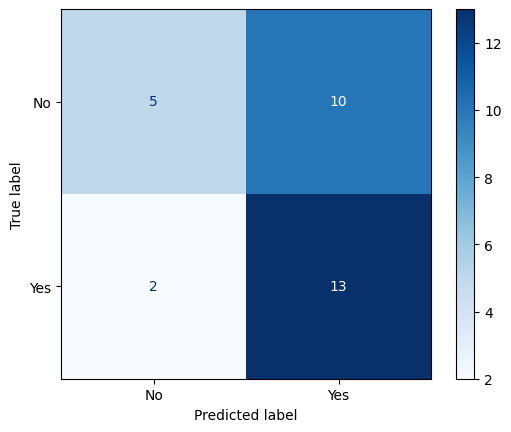

In [179]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the "Alzheimers" and "Predicted Alzheimers Status" columns are in binary format
# Calculate the confusion matrix
cm = confusion_matrix(test_results["Alzheimers"], test_results["Predicted Alzheimers"])

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optional: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
disp.plot(cmap="Blues")